In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

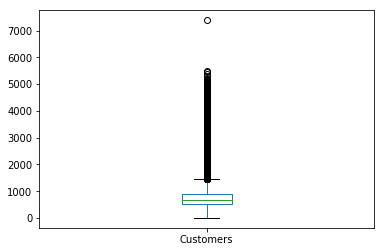

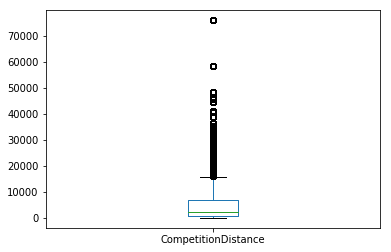

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

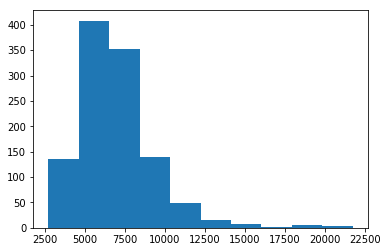

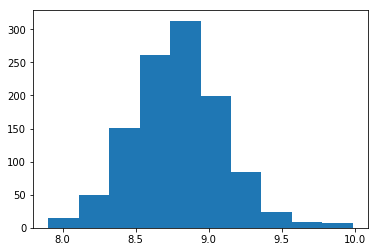

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


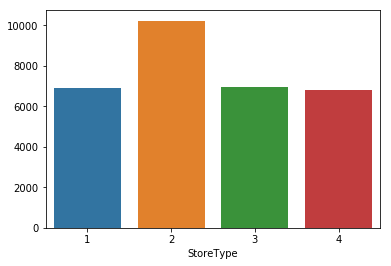

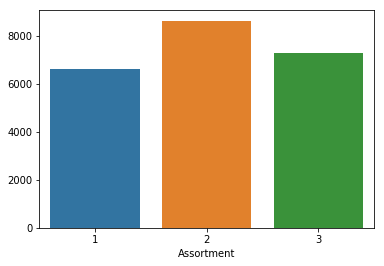

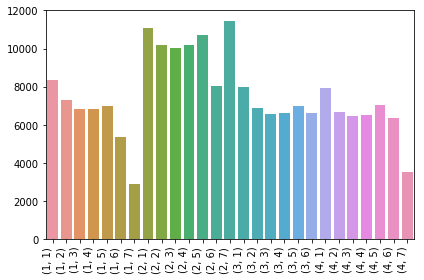

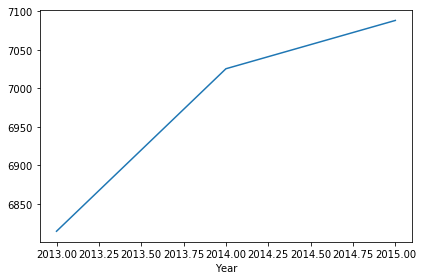

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


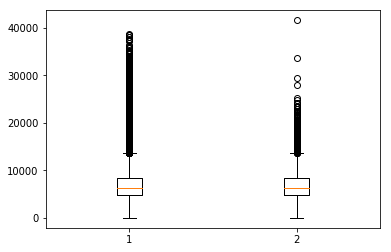

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

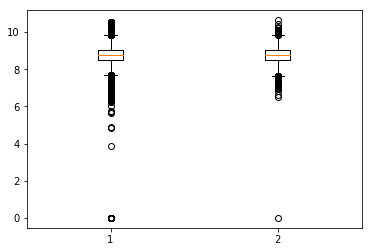

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 1000

# dtrain = xgb.DMatrix(X_train, Y_train)
# dvalid = xgb.DMatrix(X_valid, Y_valid)
# dtest = xgb.DMatrix(test)
eval_set= [(X_train, Y_train),(X_valid, Y_valid)]
#watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=num_trees,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

[0]	validation_0-rmse:7.44316	validation_1-rmse:7.43881	validation_0-rmspe:0.999496	validation_1-rmspe:0.999477
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70054	validation_1-rmse:6.69643	validation_0-rmspe:0.998795	validation_1-rmspe:0.998772
[2]	validation_0-rmse:6.03232	validation_1-rmse:6.02851	validation_0-rmspe:0.997528	validation_1-rmspe:0.997503


KeyboardInterrupt: 

In [18]:
from matplotlib import pyplot
results = estimator.evals_result()
epochs = len(results['validation_0']['rmspe'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmspe'], label='Train')
ax.plot(x_axis, results['validation_1']['rmspe'], label='Test')
ax.legend()
pyplot.ylabel('Rmspe Loss')
pyplot.title('XGBoost Rmspe Loss')
pyplot.show()

AttributeError: 'XGBRegressor' object has no attribute 'evals_result_'

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def customer_rmspe_xg(yhat, y):
    # y = y.values
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

param_test1 = {
 'max_depth':range(10,13,1),
 #'subsample': [0.7,0.8,0.9],
 #'learning_rate': [0.08,0.1,0.11]
}
params_fit = {
    'eval_metric':rmspe_xg,
    'early_stopping_rounds':20,
    'eval_set':eval_set
}
nums_round = 492
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch1.fit(X_train, Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=10 ....................................................
[0]	validation_0-rmse:7.44352	validation_1-rmse:7.43906	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70091	validation_1-rmse:6.69691	validation_0-rmspe:0.998791	validation_1-rmspe:0.998769


KeyboardInterrupt: 

In [20]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [21]:
param_test2 = {
 'subsample': [0.8,0.9],
}

nums_round = 492
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch2.fit(X_train, Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] subsample=0.8 ...................................................
[0]	validation_0-rmse:7.44352	validation_1-rmse:7.43906	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.


KeyboardInterrupt: 

In [22]:
print(gsearch2.best_params_)
print(gsearch2.best_estimator_)
best_model = gsearch2.best_estimator_
from sklearn.externals import joblib
joblib.dump(best_model, "current_model.m")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [23]:
param_test3 = {
 'eta': [0.08,0.1,0,12,0,15,0,2],
}

nums_round = 492
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch3.fit(X_train, Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] eta=0.08 ........................................................
[0]	validation_0-rmse:7.44352	validation_1-rmse:7.43906	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70091	validation_1-rmse:6.69691	validation_0-rmspe:0.998791	validation_1-rmspe:0.998769
[2]	validation_0-rmse:6.03274	validation_1-rmse:6.02916	validation_0-rmspe:0.997522	validation_1-rmspe:0.997496
[3]	validation_0-rmse:5.43178	validation_1-rmse:5.42846	validation_0-rmspe:0.995374	validation_1-rmspe:0.995343
[4]	validation_0-rmse:4.89074	validation_1-rmse:4.88789	validation_0-rmspe:0.991989	validation_1-rmspe:0.991954
[5]	validation_0-rmse:4.40427	validation_1-rmse:4.40152	validation_0-rmspe:0.986908	validation_1-rmspe:0.986865
[6]	validation_0-rmse:3.96649	valida

[70]	validation_0-rmse:0.199675	validation_1-rmse:0.206275	validation_0-rmspe:0.240857	validation_1-rmspe:0.200582
[71]	validation_0-rmse:0.198661	validation_1-rmse:0.2054	validation_0-rmspe:0.240108	validation_1-rmspe:0.199836
[72]	validation_0-rmse:0.196048	validation_1-rmse:0.202965	validation_0-rmspe:0.237735	validation_1-rmspe:0.197203
[73]	validation_0-rmse:0.193652	validation_1-rmse:0.200839	validation_0-rmspe:0.235386	validation_1-rmspe:0.19471
[74]	validation_0-rmse:0.192935	validation_1-rmse:0.200234	validation_0-rmspe:0.234103	validation_1-rmspe:0.194088
[75]	validation_0-rmse:0.190058	validation_1-rmse:0.197478	validation_0-rmspe:0.231325	validation_1-rmspe:0.190648
[76]	validation_0-rmse:0.188932	validation_1-rmse:0.19638	validation_0-rmspe:0.230225	validation_1-rmspe:0.189409
[77]	validation_0-rmse:0.187887	validation_1-rmse:0.19546	validation_0-rmspe:0.229233	validation_1-rmspe:0.188357
[78]	validation_0-rmse:0.187197	validation_1-rmse:0.194879	validation_0-rmspe:0.22855

[142]	validation_0-rmse:0.146283	validation_1-rmse:0.158273	validation_0-rmspe:0.185085	validation_1-rmspe:0.143223
[143]	validation_0-rmse:0.145562	validation_1-rmse:0.157626	validation_0-rmspe:0.184499	validation_1-rmspe:0.142467
[144]	validation_0-rmse:0.145013	validation_1-rmse:0.157114	validation_0-rmspe:0.18399	validation_1-rmspe:0.141836
[145]	validation_0-rmse:0.144706	validation_1-rmse:0.156855	validation_0-rmspe:0.183776	validation_1-rmspe:0.141502
[146]	validation_0-rmse:0.144459	validation_1-rmse:0.156701	validation_0-rmspe:0.183541	validation_1-rmspe:0.141324
[147]	validation_0-rmse:0.144276	validation_1-rmse:0.156567	validation_0-rmspe:0.183353	validation_1-rmspe:0.141152
[148]	validation_0-rmse:0.144047	validation_1-rmse:0.156425	validation_0-rmspe:0.183127	validation_1-rmspe:0.140931
[149]	validation_0-rmse:0.143741	validation_1-rmse:0.156114	validation_0-rmspe:0.182894	validation_1-rmspe:0.140462
[150]	validation_0-rmse:0.143266	validation_1-rmse:0.155788	validation_0-

[213]	validation_0-rmse:0.127144	validation_1-rmse:0.14302	validation_0-rmspe:0.166766	validation_1-rmspe:0.124353
[214]	validation_0-rmse:0.126939	validation_1-rmse:0.142883	validation_0-rmspe:0.166613	validation_1-rmspe:0.124181
[215]	validation_0-rmse:0.126773	validation_1-rmse:0.142762	validation_0-rmspe:0.166474	validation_1-rmspe:0.124093
[216]	validation_0-rmse:0.126548	validation_1-rmse:0.142598	validation_0-rmspe:0.166283	validation_1-rmspe:0.12391
[217]	validation_0-rmse:0.12653	validation_1-rmse:0.142583	validation_0-rmspe:0.166561	validation_1-rmspe:0.123894
[218]	validation_0-rmse:0.126311	validation_1-rmse:0.142427	validation_0-rmspe:0.166384	validation_1-rmspe:0.123717
[219]	validation_0-rmse:0.126221	validation_1-rmse:0.14237	validation_0-rmspe:0.16631	validation_1-rmspe:0.123658
[220]	validation_0-rmse:0.125984	validation_1-rmse:0.142267	validation_0-rmspe:0.166165	validation_1-rmspe:0.123505
[221]	validation_0-rmse:0.125828	validation_1-rmse:0.142195	validation_0-rmsp

[284]	validation_0-rmse:0.117992	validation_1-rmse:0.13753	validation_0-rmspe:0.158842	validation_1-rmspe:0.117433
[285]	validation_0-rmse:0.11792	validation_1-rmse:0.137491	validation_0-rmspe:0.158637	validation_1-rmspe:0.117379
[286]	validation_0-rmse:0.117849	validation_1-rmse:0.137436	validation_0-rmspe:0.158575	validation_1-rmspe:0.117287
[287]	validation_0-rmse:0.117728	validation_1-rmse:0.137367	validation_0-rmspe:0.158413	validation_1-rmspe:0.117206
[288]	validation_0-rmse:0.117649	validation_1-rmse:0.137323	validation_0-rmspe:0.158347	validation_1-rmspe:0.117153
[289]	validation_0-rmse:0.117535	validation_1-rmse:0.13724	validation_0-rmspe:0.158223	validation_1-rmspe:0.117073
[290]	validation_0-rmse:0.117432	validation_1-rmse:0.137177	validation_0-rmspe:0.158152	validation_1-rmspe:0.117015
[291]	validation_0-rmse:0.117385	validation_1-rmse:0.137142	validation_0-rmspe:0.158104	validation_1-rmspe:0.11697
[292]	validation_0-rmse:0.117272	validation_1-rmse:0.137083	validation_0-rms

[355]	validation_0-rmse:0.112163	validation_1-rmse:0.134724	validation_0-rmspe:0.153787	validation_1-rmspe:0.113851
[356]	validation_0-rmse:0.112084	validation_1-rmse:0.134695	validation_0-rmspe:0.153772	validation_1-rmspe:0.113801
[357]	validation_0-rmse:0.112015	validation_1-rmse:0.134653	validation_0-rmspe:0.15372	validation_1-rmspe:0.113735
[358]	validation_0-rmse:0.111958	validation_1-rmse:0.134631	validation_0-rmspe:0.153634	validation_1-rmspe:0.113747
[359]	validation_0-rmse:0.111872	validation_1-rmse:0.134584	validation_0-rmspe:0.153587	validation_1-rmspe:0.113687
[360]	validation_0-rmse:0.111755	validation_1-rmse:0.13456	validation_0-rmspe:0.153562	validation_1-rmspe:0.113654
[361]	validation_0-rmse:0.111711	validation_1-rmse:0.134529	validation_0-rmspe:0.153531	validation_1-rmspe:0.113612
[362]	validation_0-rmse:0.111678	validation_1-rmse:0.13451	validation_0-rmspe:0.153548	validation_1-rmspe:0.113605
[363]	validation_0-rmse:0.111488	validation_1-rmse:0.134489	validation_0-rm

[426]	validation_0-rmse:0.108112	validation_1-rmse:0.133221	validation_0-rmspe:0.151423	validation_1-rmspe:0.111682
[427]	validation_0-rmse:0.108063	validation_1-rmse:0.133287	validation_0-rmspe:0.151389	validation_1-rmspe:0.111733
[428]	validation_0-rmse:0.107986	validation_1-rmse:0.133248	validation_0-rmspe:0.151321	validation_1-rmspe:0.111681
[429]	validation_0-rmse:0.107943	validation_1-rmse:0.133248	validation_0-rmspe:0.151347	validation_1-rmspe:0.111682
[430]	validation_0-rmse:0.107899	validation_1-rmse:0.133238	validation_0-rmspe:0.151211	validation_1-rmspe:0.111693
[431]	validation_0-rmse:0.107881	validation_1-rmse:0.133229	validation_0-rmspe:0.151192	validation_1-rmspe:0.111686
[432]	validation_0-rmse:0.107816	validation_1-rmse:0.133162	validation_0-rmspe:0.151149	validation_1-rmspe:0.111608
[433]	validation_0-rmse:0.107783	validation_1-rmse:0.133159	validation_0-rmspe:0.151129	validation_1-rmspe:0.111598
[434]	validation_0-rmse:0.107742	validation_1-rmse:0.133249	validation_0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s


[0]	validation_0-rmse:7.44357	validation_1-rmse:7.43885	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70125	validation_1-rmse:6.69679	validation_0-rmspe:0.998787	validation_1-rmspe:0.998764
[2]	validation_0-rmse:6.03305	validation_1-rmse:6.02911	validation_0-rmspe:0.997514	validation_1-rmspe:0.997487
[3]	validation_0-rmse:5.43185	validation_1-rmse:5.42828	validation_0-rmspe:0.995367	validation_1-rmspe:0.995335
[4]	validation_0-rmse:4.89081	validation_1-rmse:4.88766	validation_0-rmspe:0.991976	validation_1-rmspe:0.991938
[5]	validation_0-rmse:4.40416	validation_1-rmse:4.40131	validation_0-rmspe:0.986895	validation_1-rmspe:0.986849
[6]	validation_0-rmse:3.96625	validation_1-rmse:3.96367	validation_0-rmspe:0.97968	validation_1-rmspe:0.979626
[7]	validation_0-rmse:3.57238	validation_1-rmse:3.57	val

[71]	validation_0-rmse:0.193483	validation_1-rmse:0.200311	validation_0-rmspe:0.235214	validation_1-rmspe:0.193091
[72]	validation_0-rmse:0.1924	validation_1-rmse:0.199322	validation_0-rmspe:0.234538	validation_1-rmspe:0.1918
[73]	validation_0-rmse:0.189409	validation_1-rmse:0.196349	validation_0-rmspe:0.232003	validation_1-rmspe:0.188362
[74]	validation_0-rmse:0.188736	validation_1-rmse:0.195825	validation_0-rmspe:0.231131	validation_1-rmspe:0.187899
[75]	validation_0-rmse:0.188049	validation_1-rmse:0.195133	validation_0-rmspe:0.230607	validation_1-rmspe:0.187244
[76]	validation_0-rmse:0.186432	validation_1-rmse:0.193723	validation_0-rmspe:0.229374	validation_1-rmspe:0.185713
[77]	validation_0-rmse:0.185495	validation_1-rmse:0.192876	validation_0-rmspe:0.228624	validation_1-rmspe:0.18487
[78]	validation_0-rmse:0.184031	validation_1-rmse:0.19148	validation_0-rmspe:0.22727	validation_1-rmspe:0.183199
[79]	validation_0-rmse:0.182963	validation_1-rmse:0.1905	validation_0-rmspe:0.226672	va

[143]	validation_0-rmse:0.142608	validation_1-rmse:0.156008	validation_0-rmspe:0.166158	validation_1-rmspe:0.140483
[144]	validation_0-rmse:0.142411	validation_1-rmse:0.155846	validation_0-rmspe:0.165997	validation_1-rmspe:0.140279
[145]	validation_0-rmse:0.141871	validation_1-rmse:0.155425	validation_0-rmspe:0.165489	validation_1-rmspe:0.139746
[146]	validation_0-rmse:0.141659	validation_1-rmse:0.155245	validation_0-rmspe:0.165282	validation_1-rmspe:0.139531
[147]	validation_0-rmse:0.140868	validation_1-rmse:0.154608	validation_0-rmspe:0.164325	validation_1-rmspe:0.138794
[148]	validation_0-rmse:0.140558	validation_1-rmse:0.15432	validation_0-rmspe:0.164365	validation_1-rmspe:0.138453
[149]	validation_0-rmse:0.140464	validation_1-rmse:0.154239	validation_0-rmspe:0.164247	validation_1-rmspe:0.138382
[150]	validation_0-rmse:0.140124	validation_1-rmse:0.154003	validation_0-rmspe:0.163946	validation_1-rmspe:0.138129
[151]	validation_0-rmse:0.140049	validation_1-rmse:0.153958	validation_0-

[214]	validation_0-rmse:0.12541	validation_1-rmse:0.143371	validation_0-rmspe:0.145754	validation_1-rmspe:0.125317
[215]	validation_0-rmse:0.125371	validation_1-rmse:0.143348	validation_0-rmspe:0.145715	validation_1-rmspe:0.125294
[216]	validation_0-rmse:0.1249	validation_1-rmse:0.143024	validation_0-rmspe:0.145273	validation_1-rmspe:0.124852
[217]	validation_0-rmse:0.124774	validation_1-rmse:0.142955	validation_0-rmspe:0.14513	validation_1-rmspe:0.124792
[218]	validation_0-rmse:0.124347	validation_1-rmse:0.142585	validation_0-rmspe:0.144709	validation_1-rmspe:0.124359
[219]	validation_0-rmse:0.12421	validation_1-rmse:0.142475	validation_0-rmspe:0.144662	validation_1-rmspe:0.124278
[220]	validation_0-rmse:0.124007	validation_1-rmse:0.142387	validation_0-rmspe:0.144459	validation_1-rmspe:0.124167
[221]	validation_0-rmse:0.12389	validation_1-rmse:0.142319	validation_0-rmspe:0.144312	validation_1-rmspe:0.124084
[222]	validation_0-rmse:0.123773	validation_1-rmse:0.14224	validation_0-rmspe:

[285]	validation_0-rmse:0.115543	validation_1-rmse:0.137696	validation_0-rmspe:0.12811	validation_1-rmspe:0.118372
[286]	validation_0-rmse:0.115453	validation_1-rmse:0.137647	validation_0-rmspe:0.127992	validation_1-rmspe:0.118303
[287]	validation_0-rmse:0.115338	validation_1-rmse:0.137596	validation_0-rmspe:0.127878	validation_1-rmspe:0.118244
[288]	validation_0-rmse:0.115266	validation_1-rmse:0.137558	validation_0-rmspe:0.127815	validation_1-rmspe:0.118175
[289]	validation_0-rmse:0.115217	validation_1-rmse:0.137557	validation_0-rmspe:0.127772	validation_1-rmspe:0.118178
[290]	validation_0-rmse:0.115147	validation_1-rmse:0.13753	validation_0-rmspe:0.127707	validation_1-rmspe:0.118136
[291]	validation_0-rmse:0.115055	validation_1-rmse:0.137468	validation_0-rmspe:0.12764	validation_1-rmspe:0.118068
[292]	validation_0-rmse:0.114958	validation_1-rmse:0.137432	validation_0-rmspe:0.127556	validation_1-rmspe:0.118009
[293]	validation_0-rmse:0.114829	validation_1-rmse:0.137362	validation_0-rm

[356]	validation_0-rmse:0.109826	validation_1-rmse:0.135089	validation_0-rmspe:0.119522	validation_1-rmspe:0.11493
[357]	validation_0-rmse:0.109774	validation_1-rmse:0.135085	validation_0-rmspe:0.119488	validation_1-rmspe:0.114953
[358]	validation_0-rmse:0.109693	validation_1-rmse:0.135026	validation_0-rmspe:0.119425	validation_1-rmspe:0.114846
[359]	validation_0-rmse:0.109665	validation_1-rmse:0.135029	validation_0-rmspe:0.119377	validation_1-rmspe:0.114787
[360]	validation_0-rmse:0.109615	validation_1-rmse:0.135033	validation_0-rmspe:0.119303	validation_1-rmspe:0.114789
[361]	validation_0-rmse:0.109529	validation_1-rmse:0.135006	validation_0-rmspe:0.119253	validation_1-rmspe:0.114749
[362]	validation_0-rmse:0.10947	validation_1-rmse:0.134992	validation_0-rmspe:0.119152	validation_1-rmspe:0.114732
[363]	validation_0-rmse:0.109413	validation_1-rmse:0.134967	validation_0-rmspe:0.118899	validation_1-rmspe:0.114698
[364]	validation_0-rmse:0.109369	validation_1-rmse:0.134913	validation_0-r

[427]	validation_0-rmse:0.105969	validation_1-rmse:0.133731	validation_0-rmspe:0.113588	validation_1-rmspe:0.112959
[428]	validation_0-rmse:0.105917	validation_1-rmse:0.133713	validation_0-rmspe:0.113557	validation_1-rmspe:0.112954
[429]	validation_0-rmse:0.105894	validation_1-rmse:0.133704	validation_0-rmspe:0.113544	validation_1-rmspe:0.112954
[430]	validation_0-rmse:0.105838	validation_1-rmse:0.133754	validation_0-rmspe:0.113506	validation_1-rmspe:0.11296
[431]	validation_0-rmse:0.105788	validation_1-rmse:0.133759	validation_0-rmspe:0.113451	validation_1-rmspe:0.112954
[432]	validation_0-rmse:0.105753	validation_1-rmse:0.13376	validation_0-rmspe:0.113377	validation_1-rmspe:0.112949
[433]	validation_0-rmse:0.10569	validation_1-rmse:0.133713	validation_0-rmspe:0.113331	validation_1-rmspe:0.112869
[434]	validation_0-rmse:0.10563	validation_1-rmse:0.133681	validation_0-rmspe:0.1133	validation_1-rmspe:0.112836
[435]	validation_0-rmse:0.105596	validation_1-rmse:0.13367	validation_0-rmspe:

[4]	validation_0-rmse:4.89094	validation_1-rmse:4.88781	validation_0-rmspe:0.99198	validation_1-rmspe:0.991941
[5]	validation_0-rmse:4.40434	validation_1-rmse:4.40154	validation_0-rmspe:0.986898	validation_1-rmspe:0.98685
[6]	validation_0-rmse:3.96645	validation_1-rmse:3.96398	validation_0-rmspe:0.979687	validation_1-rmspe:0.979632
[7]	validation_0-rmse:3.57275	validation_1-rmse:3.57058	validation_0-rmspe:0.969879	validation_1-rmspe:0.969815
[8]	validation_0-rmse:3.21859	validation_1-rmse:3.21661	validation_0-rmspe:0.957098	validation_1-rmspe:0.957019
[9]	validation_0-rmse:2.89991	validation_1-rmse:2.89821	validation_0-rmspe:0.9411	validation_1-rmspe:0.941005
[10]	validation_0-rmse:2.61316	validation_1-rmse:2.61172	validation_0-rmspe:0.921744	validation_1-rmspe:0.921636
[11]	validation_0-rmse:2.35545	validation_1-rmse:2.35417	validation_0-rmspe:0.898944	validation_1-rmspe:0.898807
[12]	validation_0-rmse:2.12382	validation_1-rmse:2.1226	validation_0-rmspe:0.872844	validation_1-rmspe:0.8

[76]	validation_0-rmse:0.190695	validation_1-rmse:0.197489	validation_0-rmspe:0.225712	validation_1-rmspe:0.189667
[77]	validation_0-rmse:0.190057	validation_1-rmse:0.196914	validation_0-rmspe:0.225246	validation_1-rmspe:0.189036
[78]	validation_0-rmse:0.188941	validation_1-rmse:0.195907	validation_0-rmspe:0.224171	validation_1-rmspe:0.187934
[79]	validation_0-rmse:0.188213	validation_1-rmse:0.19526	validation_0-rmspe:0.223528	validation_1-rmspe:0.187283
[80]	validation_0-rmse:0.188035	validation_1-rmse:0.195083	validation_0-rmspe:0.223546	validation_1-rmspe:0.187142
[81]	validation_0-rmse:0.186621	validation_1-rmse:0.19365	validation_0-rmspe:0.222144	validation_1-rmspe:0.185437
[82]	validation_0-rmse:0.185645	validation_1-rmse:0.192732	validation_0-rmspe:0.221261	validation_1-rmspe:0.184494
[83]	validation_0-rmse:0.185463	validation_1-rmse:0.192599	validation_0-rmspe:0.221139	validation_1-rmspe:0.184357
[84]	validation_0-rmse:0.183137	validation_1-rmse:0.190479	validation_0-rmspe:0.21

[148]	validation_0-rmse:0.141766	validation_1-rmse:0.154798	validation_0-rmspe:0.17526	validation_1-rmspe:0.139199
[149]	validation_0-rmse:0.141495	validation_1-rmse:0.154641	validation_0-rmspe:0.175018	validation_1-rmspe:0.139006
[150]	validation_0-rmse:0.141228	validation_1-rmse:0.154405	validation_0-rmspe:0.174752	validation_1-rmspe:0.138724
[151]	validation_0-rmse:0.140921	validation_1-rmse:0.154074	validation_0-rmspe:0.174486	validation_1-rmspe:0.138395
[152]	validation_0-rmse:0.140513	validation_1-rmse:0.153781	validation_0-rmspe:0.174351	validation_1-rmspe:0.13802
[153]	validation_0-rmse:0.139835	validation_1-rmse:0.153153	validation_0-rmspe:0.173516	validation_1-rmspe:0.137288
[154]	validation_0-rmse:0.139447	validation_1-rmse:0.152852	validation_0-rmspe:0.173164	validation_1-rmspe:0.136913
[155]	validation_0-rmse:0.138799	validation_1-rmse:0.152243	validation_0-rmspe:0.172638	validation_1-rmspe:0.1362
[156]	validation_0-rmse:0.1383	validation_1-rmse:0.151765	validation_0-rmspe

[219]	validation_0-rmse:0.12504	validation_1-rmse:0.142849	validation_0-rmspe:0.1572	validation_1-rmspe:0.124871
[220]	validation_0-rmse:0.124924	validation_1-rmse:0.14277	validation_0-rmspe:0.157028	validation_1-rmspe:0.124782
[221]	validation_0-rmse:0.124708	validation_1-rmse:0.142548	validation_0-rmspe:0.156706	validation_1-rmspe:0.12456
[222]	validation_0-rmse:0.124598	validation_1-rmse:0.142517	validation_0-rmspe:0.156635	validation_1-rmspe:0.124526
[223]	validation_0-rmse:0.124444	validation_1-rmse:0.14243	validation_0-rmspe:0.156536	validation_1-rmspe:0.124364
[224]	validation_0-rmse:0.124319	validation_1-rmse:0.14235	validation_0-rmspe:0.156424	validation_1-rmspe:0.124265
[225]	validation_0-rmse:0.124188	validation_1-rmse:0.142222	validation_0-rmspe:0.156485	validation_1-rmspe:0.124182
[226]	validation_0-rmse:0.123994	validation_1-rmse:0.142078	validation_0-rmspe:0.156386	validation_1-rmspe:0.124022
[227]	validation_0-rmse:0.123934	validation_1-rmse:0.142032	validation_0-rmspe:

[290]	validation_0-rmse:0.115739	validation_1-rmse:0.137446	validation_0-rmspe:0.146995	validation_1-rmspe:0.11799
[291]	validation_0-rmse:0.115704	validation_1-rmse:0.137434	validation_0-rmspe:0.146971	validation_1-rmspe:0.117963
[292]	validation_0-rmse:0.115615	validation_1-rmse:0.137389	validation_0-rmspe:0.146905	validation_1-rmspe:0.117918
[293]	validation_0-rmse:0.115377	validation_1-rmse:0.13723	validation_0-rmspe:0.146649	validation_1-rmspe:0.117726
[294]	validation_0-rmse:0.115297	validation_1-rmse:0.137194	validation_0-rmspe:0.14659	validation_1-rmspe:0.117667
[295]	validation_0-rmse:0.115119	validation_1-rmse:0.13722	validation_0-rmspe:0.146344	validation_1-rmspe:0.117656
[296]	validation_0-rmse:0.115013	validation_1-rmse:0.137149	validation_0-rmspe:0.146252	validation_1-rmspe:0.117574
[297]	validation_0-rmse:0.114928	validation_1-rmse:0.1371	validation_0-rmspe:0.146185	validation_1-rmspe:0.117513
[298]	validation_0-rmse:0.114827	validation_1-rmse:0.137057	validation_0-rmspe

[362]	validation_0-rmse:0.109815	validation_1-rmse:0.134933	validation_0-rmspe:0.142383	validation_1-rmspe:0.114916
[363]	validation_0-rmse:0.109781	validation_1-rmse:0.134914	validation_0-rmspe:0.142341	validation_1-rmspe:0.114888
[364]	validation_0-rmse:0.10974	validation_1-rmse:0.134911	validation_0-rmspe:0.14232	validation_1-rmspe:0.114904
[365]	validation_0-rmse:0.109695	validation_1-rmse:0.134885	validation_0-rmspe:0.142291	validation_1-rmspe:0.11488
[366]	validation_0-rmse:0.109632	validation_1-rmse:0.134852	validation_0-rmspe:0.142214	validation_1-rmspe:0.114836
[367]	validation_0-rmse:0.109537	validation_1-rmse:0.134846	validation_0-rmspe:0.142155	validation_1-rmspe:0.114838
[368]	validation_0-rmse:0.109497	validation_1-rmse:0.134818	validation_0-rmspe:0.142126	validation_1-rmspe:0.114812
[369]	validation_0-rmse:0.109385	validation_1-rmse:0.134722	validation_0-rmspe:0.142	validation_1-rmspe:0.114708
[370]	validation_0-rmse:0.109261	validation_1-rmse:0.134666	validation_0-rmspe

[433]	validation_0-rmse:0.105636	validation_1-rmse:0.133626	validation_0-rmspe:0.13752	validation_1-rmspe:0.113221
[434]	validation_0-rmse:0.105554	validation_1-rmse:0.133598	validation_0-rmspe:0.137487	validation_1-rmspe:0.113183
[435]	validation_0-rmse:0.105514	validation_1-rmse:0.133558	validation_0-rmspe:0.137449	validation_1-rmspe:0.113189
[436]	validation_0-rmse:0.105426	validation_1-rmse:0.133505	validation_0-rmspe:0.137389	validation_1-rmspe:0.11314
[437]	validation_0-rmse:0.105342	validation_1-rmse:0.133482	validation_0-rmspe:0.137359	validation_1-rmspe:0.113123
[438]	validation_0-rmse:0.105309	validation_1-rmse:0.133468	validation_0-rmspe:0.137328	validation_1-rmspe:0.113117
[439]	validation_0-rmse:0.10524	validation_1-rmse:0.133464	validation_0-rmspe:0.137321	validation_1-rmspe:0.113121
[440]	validation_0-rmse:0.10521	validation_1-rmse:0.133446	validation_0-rmspe:0.137296	validation_1-rmspe:0.11311
[441]	validation_0-rmse:0.105175	validation_1-rmse:0.133437	validation_0-rmsp

[10]	validation_0-rmse:2.6133	validation_1-rmse:2.61163	validation_0-rmspe:0.921726	validation_1-rmspe:0.921618
[11]	validation_0-rmse:2.35568	validation_1-rmse:2.35409	validation_0-rmspe:0.898894	validation_1-rmspe:0.898732
[12]	validation_0-rmse:2.12437	validation_1-rmse:2.12295	validation_0-rmspe:0.872707	validation_1-rmspe:0.872495
[13]	validation_0-rmse:1.9163	validation_1-rmse:1.91507	validation_0-rmspe:0.843584	validation_1-rmspe:0.843278
[14]	validation_0-rmse:1.72968	validation_1-rmse:1.72857	validation_0-rmspe:0.811724	validation_1-rmspe:0.811274
[15]	validation_0-rmse:1.56182	validation_1-rmse:1.56095	validation_0-rmspe:0.777796	validation_1-rmspe:0.777173
[16]	validation_0-rmse:1.41116	validation_1-rmse:1.4104	validation_0-rmspe:0.742227	validation_1-rmspe:0.741338
[17]	validation_0-rmse:1.27596	validation_1-rmse:1.27538	validation_0-rmspe:0.705599	validation_1-rmspe:0.704408
[18]	validation_0-rmse:1.15486	validation_1-rmse:1.15425	validation_0-rmspe:0.668487	validation_1-r

[82]	validation_0-rmse:0.181804	validation_1-rmse:0.189652	validation_0-rmspe:0.223481	validation_1-rmspe:0.181499
[83]	validation_0-rmse:0.180353	validation_1-rmse:0.188299	validation_0-rmspe:0.222154	validation_1-rmspe:0.179972
[84]	validation_0-rmse:0.180035	validation_1-rmse:0.18805	validation_0-rmspe:0.221603	validation_1-rmspe:0.179719
[85]	validation_0-rmse:0.178174	validation_1-rmse:0.18629	validation_0-rmspe:0.219886	validation_1-rmspe:0.177592
[86]	validation_0-rmse:0.177941	validation_1-rmse:0.186036	validation_0-rmspe:0.2198	validation_1-rmspe:0.177298
[87]	validation_0-rmse:0.177286	validation_1-rmse:0.185437	validation_0-rmspe:0.219276	validation_1-rmspe:0.176633
[88]	validation_0-rmse:0.176565	validation_1-rmse:0.184784	validation_0-rmspe:0.218641	validation_1-rmspe:0.175924
[89]	validation_0-rmse:0.176273	validation_1-rmse:0.184564	validation_0-rmspe:0.217196	validation_1-rmspe:0.175516
[90]	validation_0-rmse:0.176119	validation_1-rmse:0.184404	validation_0-rmspe:0.2173

[154]	validation_0-rmse:0.141658	validation_1-rmse:0.154299	validation_0-rmspe:0.18145	validation_1-rmspe:0.138239
[155]	validation_0-rmse:0.14117	validation_1-rmse:0.153859	validation_0-rmspe:0.181015	validation_1-rmspe:0.137684
[156]	validation_0-rmse:0.140977	validation_1-rmse:0.153717	validation_0-rmspe:0.180857	validation_1-rmspe:0.137482
[157]	validation_0-rmse:0.140634	validation_1-rmse:0.153426	validation_0-rmspe:0.180416	validation_1-rmspe:0.137173
[158]	validation_0-rmse:0.14025	validation_1-rmse:0.153123	validation_0-rmspe:0.179008	validation_1-rmspe:0.136766
[159]	validation_0-rmse:0.139808	validation_1-rmse:0.152756	validation_0-rmspe:0.178625	validation_1-rmspe:0.13628
[160]	validation_0-rmse:0.13964	validation_1-rmse:0.152656	validation_0-rmspe:0.178456	validation_1-rmspe:0.136159
[161]	validation_0-rmse:0.139406	validation_1-rmse:0.152484	validation_0-rmspe:0.178229	validation_1-rmspe:0.135955
[162]	validation_0-rmse:0.138913	validation_1-rmse:0.152021	validation_0-rmsp

[225]	validation_0-rmse:0.125275	validation_1-rmse:0.141842	validation_0-rmspe:0.165481	validation_1-rmspe:0.123001
[226]	validation_0-rmse:0.125141	validation_1-rmse:0.141739	validation_0-rmspe:0.16538	validation_1-rmspe:0.122874
[227]	validation_0-rmse:0.12501	validation_1-rmse:0.141639	validation_0-rmspe:0.16526	validation_1-rmspe:0.122739
[228]	validation_0-rmse:0.124715	validation_1-rmse:0.141481	validation_0-rmspe:0.165053	validation_1-rmspe:0.122532
[229]	validation_0-rmse:0.124547	validation_1-rmse:0.141362	validation_0-rmspe:0.164893	validation_1-rmspe:0.122374
[230]	validation_0-rmse:0.124451	validation_1-rmse:0.141337	validation_0-rmspe:0.164791	validation_1-rmspe:0.122329
[231]	validation_0-rmse:0.124192	validation_1-rmse:0.141173	validation_0-rmspe:0.164622	validation_1-rmspe:0.122191
[232]	validation_0-rmse:0.124023	validation_1-rmse:0.141062	validation_0-rmspe:0.164513	validation_1-rmspe:0.122072
[233]	validation_0-rmse:0.123884	validation_1-rmse:0.140958	validation_0-rm

[296]	validation_0-rmse:0.116892	validation_1-rmse:0.136885	validation_0-rmspe:0.157634	validation_1-rmspe:0.116595
[297]	validation_0-rmse:0.116839	validation_1-rmse:0.136853	validation_0-rmspe:0.157547	validation_1-rmspe:0.116559
[298]	validation_0-rmse:0.116739	validation_1-rmse:0.136828	validation_0-rmspe:0.15745	validation_1-rmspe:0.116514
[299]	validation_0-rmse:0.116641	validation_1-rmse:0.136775	validation_0-rmspe:0.157272	validation_1-rmspe:0.116432
[300]	validation_0-rmse:0.116528	validation_1-rmse:0.136773	validation_0-rmspe:0.157185	validation_1-rmspe:0.116364
[301]	validation_0-rmse:0.116415	validation_1-rmse:0.13669	validation_0-rmspe:0.1571	validation_1-rmspe:0.116279
[302]	validation_0-rmse:0.116358	validation_1-rmse:0.136666	validation_0-rmspe:0.157027	validation_1-rmspe:0.116266
[303]	validation_0-rmse:0.116232	validation_1-rmse:0.136622	validation_0-rmspe:0.156911	validation_1-rmspe:0.116302
[304]	validation_0-rmse:0.116079	validation_1-rmse:0.136522	validation_0-rms

[368]	validation_0-rmse:0.111148	validation_1-rmse:0.134386	validation_0-rmspe:0.152977	validation_1-rmspe:0.113408
[369]	validation_0-rmse:0.111117	validation_1-rmse:0.134379	validation_0-rmspe:0.152947	validation_1-rmspe:0.113408
[370]	validation_0-rmse:0.111066	validation_1-rmse:0.134348	validation_0-rmspe:0.15291	validation_1-rmspe:0.113364
[371]	validation_0-rmse:0.111021	validation_1-rmse:0.134345	validation_0-rmspe:0.15288	validation_1-rmspe:0.113389
[372]	validation_0-rmse:0.110937	validation_1-rmse:0.134285	validation_0-rmspe:0.152811	validation_1-rmspe:0.113313
[373]	validation_0-rmse:0.110883	validation_1-rmse:0.134284	validation_0-rmspe:0.152783	validation_1-rmspe:0.113304
[374]	validation_0-rmse:0.110842	validation_1-rmse:0.134248	validation_0-rmspe:0.152724	validation_1-rmspe:0.113247
[375]	validation_0-rmse:0.110789	validation_1-rmse:0.134232	validation_0-rmspe:0.152723	validation_1-rmspe:0.11322
[376]	validation_0-rmse:0.110731	validation_1-rmse:0.134167	validation_0-rm

[439]	validation_0-rmse:0.107497	validation_1-rmse:0.133138	validation_0-rmspe:0.150577	validation_1-rmspe:0.111437
[440]	validation_0-rmse:0.107452	validation_1-rmse:0.133097	validation_0-rmspe:0.150542	validation_1-rmspe:0.111413
[441]	validation_0-rmse:0.107398	validation_1-rmse:0.133063	validation_0-rmspe:0.150509	validation_1-rmspe:0.111269
[442]	validation_0-rmse:0.107363	validation_1-rmse:0.133051	validation_0-rmspe:0.150456	validation_1-rmspe:0.111265
[443]	validation_0-rmse:0.107332	validation_1-rmse:0.133029	validation_0-rmspe:0.150429	validation_1-rmspe:0.111244
[444]	validation_0-rmse:0.107271	validation_1-rmse:0.132993	validation_0-rmspe:0.150261	validation_1-rmspe:0.111205
[445]	validation_0-rmse:0.10724	validation_1-rmse:0.132979	validation_0-rmspe:0.150189	validation_1-rmspe:0.111186
[446]	validation_0-rmse:0.107185	validation_1-rmse:0.13296	validation_0-rmspe:0.150148	validation_1-rmspe:0.111166
[447]	validation_0-rmse:0.107135	validation_1-rmse:0.132949	validation_0-r

[16]	validation_0-rmse:1.4099	validation_1-rmse:1.40959	validation_0-rmspe:0.742497	validation_1-rmspe:0.741655
[17]	validation_0-rmse:1.27481	validation_1-rmse:1.27464	validation_0-rmspe:0.705837	validation_1-rmspe:0.704701
[18]	validation_0-rmse:1.15377	validation_1-rmse:1.15379	validation_0-rmspe:0.668612	validation_1-rmspe:0.667118
[19]	validation_0-rmse:1.04533	validation_1-rmse:1.04544	validation_0-rmspe:0.631546	validation_1-rmspe:0.629504
[20]	validation_0-rmse:0.948417	validation_1-rmse:0.948569	validation_0-rmspe:0.595059	validation_1-rmspe:0.592322
[21]	validation_0-rmse:0.861954	validation_1-rmse:0.862192	validation_0-rmspe:0.55963	validation_1-rmspe:0.556018
[22]	validation_0-rmse:0.784754	validation_1-rmse:0.785109	validation_0-rmspe:0.525655	validation_1-rmspe:0.521076
[23]	validation_0-rmse:0.716232	validation_1-rmse:0.716723	validation_0-rmspe:0.493548	validation_1-rmspe:0.487846
[24]	validation_0-rmse:0.654568	validation_1-rmse:0.655312	validation_0-rmspe:0.463446	val

[88]	validation_0-rmse:0.176153	validation_1-rmse:0.184339	validation_0-rmspe:0.210509	validation_1-rmspe:0.17492
[89]	validation_0-rmse:0.174318	validation_1-rmse:0.182693	validation_0-rmspe:0.208535	validation_1-rmspe:0.172823
[90]	validation_0-rmse:0.173719	validation_1-rmse:0.182184	validation_0-rmspe:0.205852	validation_1-rmspe:0.172197
[91]	validation_0-rmse:0.172703	validation_1-rmse:0.181374	validation_0-rmspe:0.204884	validation_1-rmspe:0.171235
[92]	validation_0-rmse:0.171585	validation_1-rmse:0.180379	validation_0-rmspe:0.204276	validation_1-rmspe:0.170096
[93]	validation_0-rmse:0.170612	validation_1-rmse:0.179504	validation_0-rmspe:0.203467	validation_1-rmspe:0.169036
[94]	validation_0-rmse:0.1689	validation_1-rmse:0.178064	validation_0-rmspe:0.201768	validation_1-rmspe:0.167387
[95]	validation_0-rmse:0.168254	validation_1-rmse:0.177471	validation_0-rmspe:0.201243	validation_1-rmspe:0.166629
[96]	validation_0-rmse:0.167758	validation_1-rmse:0.177151	validation_0-rmspe:0.200

[160]	validation_0-rmse:0.137348	validation_1-rmse:0.151911	validation_0-rmspe:0.160873	validation_1-rmspe:0.135525
[161]	validation_0-rmse:0.137119	validation_1-rmse:0.151765	validation_0-rmspe:0.160656	validation_1-rmspe:0.135342
[162]	validation_0-rmse:0.136817	validation_1-rmse:0.151545	validation_0-rmspe:0.159865	validation_1-rmspe:0.135059
[163]	validation_0-rmse:0.136426	validation_1-rmse:0.15123	validation_0-rmspe:0.159498	validation_1-rmspe:0.134689
[164]	validation_0-rmse:0.136138	validation_1-rmse:0.151	validation_0-rmspe:0.159207	validation_1-rmspe:0.134369
[165]	validation_0-rmse:0.135985	validation_1-rmse:0.150894	validation_0-rmspe:0.159089	validation_1-rmspe:0.134254
[166]	validation_0-rmse:0.135788	validation_1-rmse:0.150789	validation_0-rmspe:0.158933	validation_1-rmspe:0.134135
[167]	validation_0-rmse:0.135524	validation_1-rmse:0.150685	validation_0-rmspe:0.158751	validation_1-rmspe:0.133999
[168]	validation_0-rmse:0.135143	validation_1-rmse:0.150425	validation_0-rms

[231]	validation_0-rmse:0.12238	validation_1-rmse:0.141402	validation_0-rmspe:0.141509	validation_1-rmspe:0.122936
[232]	validation_0-rmse:0.122233	validation_1-rmse:0.141359	validation_0-rmspe:0.14142	validation_1-rmspe:0.122879
[233]	validation_0-rmse:0.12211	validation_1-rmse:0.141292	validation_0-rmspe:0.141317	validation_1-rmspe:0.122903
[234]	validation_0-rmse:0.121943	validation_1-rmse:0.141202	validation_0-rmspe:0.141008	validation_1-rmspe:0.122763
[235]	validation_0-rmse:0.121754	validation_1-rmse:0.1411	validation_0-rmspe:0.140784	validation_1-rmspe:0.122603
[236]	validation_0-rmse:0.121507	validation_1-rmse:0.140901	validation_0-rmspe:0.140515	validation_1-rmspe:0.122399
[237]	validation_0-rmse:0.121355	validation_1-rmse:0.140795	validation_0-rmspe:0.140378	validation_1-rmspe:0.122279
[238]	validation_0-rmse:0.121203	validation_1-rmse:0.140677	validation_0-rmspe:0.140185	validation_1-rmspe:0.122133
[239]	validation_0-rmse:0.121046	validation_1-rmse:0.140564	validation_0-rmsp

[302]	validation_0-rmse:0.113925	validation_1-rmse:0.136872	validation_0-rmspe:0.12524	validation_1-rmspe:0.117372
[303]	validation_0-rmse:0.113763	validation_1-rmse:0.136756	validation_0-rmspe:0.125049	validation_1-rmspe:0.117245
[304]	validation_0-rmse:0.113678	validation_1-rmse:0.136719	validation_0-rmspe:0.124967	validation_1-rmspe:0.117192
[305]	validation_0-rmse:0.113622	validation_1-rmse:0.136721	validation_0-rmspe:0.124886	validation_1-rmspe:0.117181
[306]	validation_0-rmse:0.113572	validation_1-rmse:0.136677	validation_0-rmspe:0.124838	validation_1-rmspe:0.117092
[307]	validation_0-rmse:0.113461	validation_1-rmse:0.136606	validation_0-rmspe:0.124752	validation_1-rmspe:0.117004
[308]	validation_0-rmse:0.113399	validation_1-rmse:0.136569	validation_0-rmspe:0.124706	validation_1-rmspe:0.116961
[309]	validation_0-rmse:0.113362	validation_1-rmse:0.136549	validation_0-rmspe:0.124673	validation_1-rmspe:0.116931
[310]	validation_0-rmse:0.113275	validation_1-rmse:0.136502	validation_0-

[373]	validation_0-rmse:0.108828	validation_1-rmse:0.134762	validation_0-rmspe:0.118247	validation_1-rmspe:0.114416
[374]	validation_0-rmse:0.108792	validation_1-rmse:0.134746	validation_0-rmspe:0.118222	validation_1-rmspe:0.114392
[375]	validation_0-rmse:0.108749	validation_1-rmse:0.134734	validation_0-rmspe:0.118159	validation_1-rmspe:0.114374
[376]	validation_0-rmse:0.108717	validation_1-rmse:0.134718	validation_0-rmspe:0.118123	validation_1-rmspe:0.114345
[377]	validation_0-rmse:0.108673	validation_1-rmse:0.134712	validation_0-rmspe:0.118074	validation_1-rmspe:0.114382
[378]	validation_0-rmse:0.108629	validation_1-rmse:0.134696	validation_0-rmspe:0.117299	validation_1-rmspe:0.114373
[379]	validation_0-rmse:0.108591	validation_1-rmse:0.134668	validation_0-rmspe:0.117251	validation_1-rmspe:0.114323
[380]	validation_0-rmse:0.108509	validation_1-rmse:0.134581	validation_0-rmspe:0.11714	validation_1-rmspe:0.114185
[381]	validation_0-rmse:0.108477	validation_1-rmse:0.134579	validation_0-

[444]	validation_0-rmse:0.105113	validation_1-rmse:0.13363	validation_0-rmspe:0.112966	validation_1-rmspe:0.112746
[445]	validation_0-rmse:0.10508	validation_1-rmse:0.133619	validation_0-rmspe:0.112929	validation_1-rmspe:0.112735
[446]	validation_0-rmse:0.105034	validation_1-rmse:0.133598	validation_0-rmspe:0.112901	validation_1-rmspe:0.112724
[447]	validation_0-rmse:0.104999	validation_1-rmse:0.133573	validation_0-rmspe:0.1129	validation_1-rmspe:0.11272
[448]	validation_0-rmse:0.104975	validation_1-rmse:0.133559	validation_0-rmspe:0.11288	validation_1-rmspe:0.1127
[449]	validation_0-rmse:0.104919	validation_1-rmse:0.133498	validation_0-rmspe:0.112856	validation_1-rmspe:0.112666
[450]	validation_0-rmse:0.104893	validation_1-rmse:0.133501	validation_0-rmspe:0.112817	validation_1-rmspe:0.112666
[451]	validation_0-rmse:0.104864	validation_1-rmse:0.133484	validation_0-rmspe:0.112788	validation_1-rmspe:0.112644
[452]	validation_0-rmse:0.104837	validation_1-rmse:0.133464	validation_0-rmspe:0

[21]	validation_0-rmse:0.862308	validation_1-rmse:0.862391	validation_0-rmspe:0.559425	validation_1-rmspe:0.555962
[22]	validation_0-rmse:0.785058	validation_1-rmse:0.785229	validation_0-rmspe:0.525374	validation_1-rmspe:0.520995
[23]	validation_0-rmse:0.716474	validation_1-rmse:0.716712	validation_0-rmspe:0.493208	validation_1-rmspe:0.487726
[24]	validation_0-rmse:0.655212	validation_1-rmse:0.655512	validation_0-rmspe:0.463164	validation_1-rmspe:0.456389
[25]	validation_0-rmse:0.601034	validation_1-rmse:0.601556	validation_0-rmspe:0.435474	validation_1-rmspe:0.427326
[26]	validation_0-rmse:0.553186	validation_1-rmse:0.553826	validation_0-rmspe:0.410179	validation_1-rmspe:0.400532
[27]	validation_0-rmse:0.510168	validation_1-rmse:0.510971	validation_0-rmspe:0.387115	validation_1-rmspe:0.375884
[28]	validation_0-rmse:0.473326	validation_1-rmse:0.474246	validation_0-rmspe:0.367139	validation_1-rmspe:0.354052
[29]	validation_0-rmse:0.44083	validation_1-rmse:0.442	validation_0-rmspe:0.3495

[93]	validation_0-rmse:0.174405	validation_1-rmse:0.182576	validation_0-rmspe:0.210661	validation_1-rmspe:0.172519
[94]	validation_0-rmse:0.173807	validation_1-rmse:0.182012	validation_0-rmspe:0.210076	validation_1-rmspe:0.171828
[95]	validation_0-rmse:0.17343	validation_1-rmse:0.181758	validation_0-rmspe:0.209327	validation_1-rmspe:0.171542
[96]	validation_0-rmse:0.173135	validation_1-rmse:0.181537	validation_0-rmspe:0.209055	validation_1-rmspe:0.171239
[97]	validation_0-rmse:0.17229	validation_1-rmse:0.180785	validation_0-rmspe:0.208233	validation_1-rmspe:0.170316
[98]	validation_0-rmse:0.170554	validation_1-rmse:0.17926	validation_0-rmspe:0.206548	validation_1-rmspe:0.168498
[99]	validation_0-rmse:0.170025	validation_1-rmse:0.1788	validation_0-rmspe:0.203029	validation_1-rmspe:0.167947
[100]	validation_0-rmse:0.169578	validation_1-rmse:0.178457	validation_0-rmspe:0.202455	validation_1-rmspe:0.167423
[101]	validation_0-rmse:0.168922	validation_1-rmse:0.177955	validation_0-rmspe:0.201

[164]	validation_0-rmse:0.136513	validation_1-rmse:0.150617	validation_0-rmspe:0.167605	validation_1-rmspe:0.134256
[165]	validation_0-rmse:0.136302	validation_1-rmse:0.1505	validation_0-rmspe:0.167377	validation_1-rmspe:0.134072
[166]	validation_0-rmse:0.136138	validation_1-rmse:0.150433	validation_0-rmspe:0.167289	validation_1-rmspe:0.133989
[167]	validation_0-rmse:0.135868	validation_1-rmse:0.150292	validation_0-rmspe:0.167091	validation_1-rmspe:0.13385
[168]	validation_0-rmse:0.13548	validation_1-rmse:0.15002	validation_0-rmspe:0.166641	validation_1-rmspe:0.133531
[169]	validation_0-rmse:0.135077	validation_1-rmse:0.149701	validation_0-rmspe:0.166285	validation_1-rmspe:0.133165
[170]	validation_0-rmse:0.134894	validation_1-rmse:0.14964	validation_0-rmspe:0.16622	validation_1-rmspe:0.13311
[171]	validation_0-rmse:0.134634	validation_1-rmse:0.149454	validation_0-rmspe:0.165999	validation_1-rmspe:0.132945
[172]	validation_0-rmse:0.134435	validation_1-rmse:0.149294	validation_0-rmspe:0

[235]	validation_0-rmse:0.122677	validation_1-rmse:0.141311	validation_0-rmspe:0.154764	validation_1-rmspe:0.123161
[236]	validation_0-rmse:0.122602	validation_1-rmse:0.14127	validation_0-rmspe:0.154675	validation_1-rmspe:0.123185
[237]	validation_0-rmse:0.122423	validation_1-rmse:0.141161	validation_0-rmspe:0.154527	validation_1-rmspe:0.123055
[238]	validation_0-rmse:0.122288	validation_1-rmse:0.141066	validation_0-rmspe:0.1544	validation_1-rmspe:0.122926
[239]	validation_0-rmse:0.122081	validation_1-rmse:0.140979	validation_0-rmspe:0.154137	validation_1-rmspe:0.122821
[240]	validation_0-rmse:0.121983	validation_1-rmse:0.140919	validation_0-rmspe:0.154051	validation_1-rmspe:0.122743
[241]	validation_0-rmse:0.121799	validation_1-rmse:0.14083	validation_0-rmspe:0.153807	validation_1-rmspe:0.122557
[242]	validation_0-rmse:0.121636	validation_1-rmse:0.140676	validation_0-rmspe:0.153671	validation_1-rmspe:0.122392
[243]	validation_0-rmse:0.121582	validation_1-rmse:0.140651	validation_0-rms

[306]	validation_0-rmse:0.114102	validation_1-rmse:0.136727	validation_0-rmspe:0.14549	validation_1-rmspe:0.117029
[307]	validation_0-rmse:0.114041	validation_1-rmse:0.136696	validation_0-rmspe:0.145438	validation_1-rmspe:0.117007
[308]	validation_0-rmse:0.114006	validation_1-rmse:0.13668	validation_0-rmspe:0.145413	validation_1-rmspe:0.116989
[309]	validation_0-rmse:0.113803	validation_1-rmse:0.136645	validation_0-rmspe:0.145368	validation_1-rmspe:0.116945
[310]	validation_0-rmse:0.113745	validation_1-rmse:0.136608	validation_0-rmspe:0.145304	validation_1-rmspe:0.11689
[311]	validation_0-rmse:0.11372	validation_1-rmse:0.136636	validation_0-rmspe:0.145296	validation_1-rmspe:0.116902
[312]	validation_0-rmse:0.11364	validation_1-rmse:0.136623	validation_0-rmspe:0.14523	validation_1-rmspe:0.1169
[313]	validation_0-rmse:0.113525	validation_1-rmse:0.136533	validation_0-rmspe:0.145144	validation_1-rmspe:0.116788
[314]	validation_0-rmse:0.113469	validation_1-rmse:0.136494	validation_0-rmspe:0

[377]	validation_0-rmse:0.108814	validation_1-rmse:0.134554	validation_0-rmspe:0.139552	validation_1-rmspe:0.114551
[378]	validation_0-rmse:0.108701	validation_1-rmse:0.13453	validation_0-rmspe:0.139506	validation_1-rmspe:0.114558
[379]	validation_0-rmse:0.108627	validation_1-rmse:0.134477	validation_0-rmspe:0.13946	validation_1-rmspe:0.114495
[380]	validation_0-rmse:0.108543	validation_1-rmse:0.134426	validation_0-rmspe:0.139384	validation_1-rmspe:0.114468
[381]	validation_0-rmse:0.108513	validation_1-rmse:0.134444	validation_0-rmspe:0.139359	validation_1-rmspe:0.114484
[382]	validation_0-rmse:0.10844	validation_1-rmse:0.134408	validation_0-rmspe:0.139353	validation_1-rmspe:0.114421
[383]	validation_0-rmse:0.108401	validation_1-rmse:0.134399	validation_0-rmspe:0.13932	validation_1-rmspe:0.114437
[384]	validation_0-rmse:0.108349	validation_1-rmse:0.134354	validation_0-rmspe:0.13926	validation_1-rmspe:0.114358
[385]	validation_0-rmse:0.10833	validation_1-rmse:0.134349	validation_0-rmspe

[448]	validation_0-rmse:0.104875	validation_1-rmse:0.133324	validation_0-rmspe:0.137062	validation_1-rmspe:0.112993
[449]	validation_0-rmse:0.104832	validation_1-rmse:0.13332	validation_0-rmspe:0.137039	validation_1-rmspe:0.112993
[450]	validation_0-rmse:0.104808	validation_1-rmse:0.133312	validation_0-rmspe:0.137055	validation_1-rmspe:0.11298
[451]	validation_0-rmse:0.104769	validation_1-rmse:0.133286	validation_0-rmspe:0.137032	validation_1-rmspe:0.112947
[452]	validation_0-rmse:0.104703	validation_1-rmse:0.133271	validation_0-rmspe:0.136987	validation_1-rmspe:0.11293
[453]	validation_0-rmse:0.104617	validation_1-rmse:0.133262	validation_0-rmspe:0.136962	validation_1-rmspe:0.112908
[454]	validation_0-rmse:0.104546	validation_1-rmse:0.133235	validation_0-rmspe:0.136918	validation_1-rmspe:0.112907
[455]	validation_0-rmse:0.104498	validation_1-rmse:0.133225	validation_0-rmspe:0.136894	validation_1-rmspe:0.112893
[456]	validation_0-rmse:0.104431	validation_1-rmse:0.133264	validation_0-rm

[25]	validation_0-rmse:0.60186	validation_1-rmse:0.602075	validation_0-rmspe:0.435775	validation_1-rmspe:0.427405
[26]	validation_0-rmse:0.554354	validation_1-rmse:0.554822	validation_0-rmspe:0.410777	validation_1-rmspe:0.400821
[27]	validation_0-rmse:0.512256	validation_1-rmse:0.512772	validation_0-rmspe:0.388235	validation_1-rmspe:0.37655
[28]	validation_0-rmse:0.474646	validation_1-rmse:0.475408	validation_0-rmspe:0.368028	validation_1-rmspe:0.354614
[29]	validation_0-rmse:0.442572	validation_1-rmse:0.443561	validation_0-rmspe:0.350796	validation_1-rmspe:0.335542
[30]	validation_0-rmse:0.414344	validation_1-rmse:0.415519	validation_0-rmspe:0.335922	validation_1-rmspe:0.318796
[31]	validation_0-rmse:0.388543	validation_1-rmse:0.390009	validation_0-rmspe:0.322532	validation_1-rmspe:0.30349
[32]	validation_0-rmse:0.367378	validation_1-rmse:0.369054	validation_0-rmspe:0.312071	validation_1-rmspe:0.291201
[33]	validation_0-rmse:0.348267	validation_1-rmse:0.350224	validation_0-rmspe:0.302

[97]	validation_0-rmse:0.168834	validation_1-rmse:0.177858	validation_0-rmspe:0.207372	validation_1-rmspe:0.167383
[98]	validation_0-rmse:0.168471	validation_1-rmse:0.177609	validation_0-rmspe:0.207004	validation_1-rmspe:0.167111
[99]	validation_0-rmse:0.168189	validation_1-rmse:0.177381	validation_0-rmspe:0.206691	validation_1-rmspe:0.166803
[100]	validation_0-rmse:0.167053	validation_1-rmse:0.176357	validation_0-rmspe:0.205668	validation_1-rmspe:0.165614
[101]	validation_0-rmse:0.166778	validation_1-rmse:0.176112	validation_0-rmspe:0.205764	validation_1-rmspe:0.165339
[102]	validation_0-rmse:0.165939	validation_1-rmse:0.175329	validation_0-rmspe:0.205003	validation_1-rmspe:0.164341
[103]	validation_0-rmse:0.164065	validation_1-rmse:0.17358	validation_0-rmspe:0.203195	validation_1-rmspe:0.162206
[104]	validation_0-rmse:0.163645	validation_1-rmse:0.173153	validation_0-rmspe:0.202851	validation_1-rmspe:0.161608
[105]	validation_0-rmse:0.163532	validation_1-rmse:0.173053	validation_0-rms

[168]	validation_0-rmse:0.137067	validation_1-rmse:0.150522	validation_0-rmspe:0.175949	validation_1-rmspe:0.133546
[169]	validation_0-rmse:0.136831	validation_1-rmse:0.150342	validation_0-rmspe:0.17576	validation_1-rmspe:0.133322
[170]	validation_0-rmse:0.136569	validation_1-rmse:0.150192	validation_0-rmspe:0.175543	validation_1-rmspe:0.13313
[171]	validation_0-rmse:0.136264	validation_1-rmse:0.14984	validation_0-rmspe:0.175144	validation_1-rmspe:0.132649
[172]	validation_0-rmse:0.135793	validation_1-rmse:0.149417	validation_0-rmspe:0.174664	validation_1-rmspe:0.132113
[173]	validation_0-rmse:0.135579	validation_1-rmse:0.149252	validation_0-rmspe:0.174552	validation_1-rmspe:0.131915
[174]	validation_0-rmse:0.135408	validation_1-rmse:0.149113	validation_0-rmspe:0.174386	validation_1-rmspe:0.131763
[175]	validation_0-rmse:0.135139	validation_1-rmse:0.14893	validation_0-rmspe:0.174127	validation_1-rmspe:0.131545
[176]	validation_0-rmse:0.134976	validation_1-rmse:0.148812	validation_0-rms

[239]	validation_0-rmse:0.122977	validation_1-rmse:0.140348	validation_0-rmspe:0.163684	validation_1-rmspe:0.12113
[240]	validation_0-rmse:0.122891	validation_1-rmse:0.140307	validation_0-rmspe:0.16361	validation_1-rmspe:0.121092
[241]	validation_0-rmse:0.122814	validation_1-rmse:0.140264	validation_0-rmspe:0.163562	validation_1-rmspe:0.121074
[242]	validation_0-rmse:0.122761	validation_1-rmse:0.140255	validation_0-rmspe:0.163498	validation_1-rmspe:0.121066
[243]	validation_0-rmse:0.122657	validation_1-rmse:0.140175	validation_0-rmspe:0.16341	validation_1-rmspe:0.120977
[244]	validation_0-rmse:0.122543	validation_1-rmse:0.140088	validation_0-rmspe:0.163317	validation_1-rmspe:0.12087
[245]	validation_0-rmse:0.122486	validation_1-rmse:0.140052	validation_0-rmspe:0.16326	validation_1-rmspe:0.120818
[246]	validation_0-rmse:0.122355	validation_1-rmse:0.139961	validation_0-rmspe:0.163163	validation_1-rmspe:0.120558
[247]	validation_0-rmse:0.122295	validation_1-rmse:0.139916	validation_0-rmsp

[310]	validation_0-rmse:0.115493	validation_1-rmse:0.136296	validation_0-rmspe:0.156374	validation_1-rmspe:0.115913
[311]	validation_0-rmse:0.115395	validation_1-rmse:0.13623	validation_0-rmspe:0.156288	validation_1-rmspe:0.11586
[312]	validation_0-rmse:0.115313	validation_1-rmse:0.136156	validation_0-rmspe:0.15622	validation_1-rmspe:0.115752
[313]	validation_0-rmse:0.115266	validation_1-rmse:0.136135	validation_0-rmspe:0.156135	validation_1-rmspe:0.115725
[314]	validation_0-rmse:0.115183	validation_1-rmse:0.136051	validation_0-rmspe:0.156069	validation_1-rmspe:0.115619
[315]	validation_0-rmse:0.11509	validation_1-rmse:0.136	validation_0-rmspe:0.156007	validation_1-rmspe:0.115537
[316]	validation_0-rmse:0.115032	validation_1-rmse:0.13599	validation_0-rmspe:0.155975	validation_1-rmspe:0.115487
[317]	validation_0-rmse:0.114975	validation_1-rmse:0.135937	validation_0-rmspe:0.155874	validation_1-rmspe:0.115436
[318]	validation_0-rmse:0.114895	validation_1-rmse:0.135891	validation_0-rmspe:0

[381]	validation_0-rmse:0.110428	validation_1-rmse:0.134016	validation_0-rmspe:0.152442	validation_1-rmspe:0.112895
[382]	validation_0-rmse:0.110362	validation_1-rmse:0.133998	validation_0-rmspe:0.152365	validation_1-rmspe:0.112878
[383]	validation_0-rmse:0.110329	validation_1-rmse:0.133959	validation_0-rmspe:0.152338	validation_1-rmspe:0.112822
[384]	validation_0-rmse:0.110221	validation_1-rmse:0.133891	validation_0-rmspe:0.152459	validation_1-rmspe:0.112742
[385]	validation_0-rmse:0.110198	validation_1-rmse:0.133946	validation_0-rmspe:0.152446	validation_1-rmspe:0.112754
[386]	validation_0-rmse:0.110131	validation_1-rmse:0.133917	validation_0-rmspe:0.152405	validation_1-rmspe:0.11271
[387]	validation_0-rmse:0.110088	validation_1-rmse:0.1339	validation_0-rmspe:0.152365	validation_1-rmspe:0.112722
[388]	validation_0-rmse:0.110053	validation_1-rmse:0.133891	validation_0-rmspe:0.152332	validation_1-rmspe:0.112705
[389]	validation_0-rmse:0.109987	validation_1-rmse:0.133877	validation_0-rm

[452]	validation_0-rmse:0.106894	validation_1-rmse:0.132884	validation_0-rmspe:0.149801	validation_1-rmspe:0.110968
[453]	validation_0-rmse:0.106832	validation_1-rmse:0.132862	validation_0-rmspe:0.149749	validation_1-rmspe:0.11094
[454]	validation_0-rmse:0.106785	validation_1-rmse:0.132839	validation_0-rmspe:0.149892	validation_1-rmspe:0.110913
[455]	validation_0-rmse:0.106749	validation_1-rmse:0.132808	validation_0-rmspe:0.149866	validation_1-rmspe:0.110891
[456]	validation_0-rmse:0.106715	validation_1-rmse:0.132811	validation_0-rmspe:0.149862	validation_1-rmspe:0.110903
[457]	validation_0-rmse:0.106654	validation_1-rmse:0.132855	validation_0-rmspe:0.149813	validation_1-rmspe:0.110935
[458]	validation_0-rmse:0.106615	validation_1-rmse:0.132834	validation_0-rmspe:0.14983	validation_1-rmspe:0.110913
[459]	validation_0-rmse:0.106593	validation_1-rmse:0.132809	validation_0-rmspe:0.149802	validation_1-rmspe:0.110879
[460]	validation_0-rmse:0.10657	validation_1-rmse:0.132791	validation_0-rm

[30]	validation_0-rmse:0.411356	validation_1-rmse:0.413407	validation_0-rmspe:0.334781	validation_1-rmspe:0.317764
[31]	validation_0-rmse:0.386288	validation_1-rmse:0.388594	validation_0-rmspe:0.321882	validation_1-rmspe:0.302826
[32]	validation_0-rmse:0.365212	validation_1-rmse:0.367756	validation_0-rmspe:0.311522	validation_1-rmspe:0.290505
[33]	validation_0-rmse:0.346612	validation_1-rmse:0.349279	validation_0-rmspe:0.302772	validation_1-rmspe:0.279834
[34]	validation_0-rmse:0.329289	validation_1-rmse:0.33215	validation_0-rmspe:0.294714	validation_1-rmspe:0.269982
[35]	validation_0-rmse:0.315881	validation_1-rmse:0.31896	validation_0-rmspe:0.289299	validation_1-rmspe:0.263019
[36]	validation_0-rmse:0.303703	validation_1-rmse:0.307013	validation_0-rmspe:0.28452	validation_1-rmspe:0.256781
[37]	validation_0-rmse:0.292319	validation_1-rmse:0.295696	validation_0-rmspe:0.279397	validation_1-rmspe:0.250115
[38]	validation_0-rmse:0.283929	validation_1-rmse:0.287489	validation_0-rmspe:0.277

[102]	validation_0-rmse:0.163651	validation_1-rmse:0.173633	validation_0-rmspe:0.196845	validation_1-rmspe:0.161963
[103]	validation_0-rmse:0.163181	validation_1-rmse:0.173214	validation_0-rmspe:0.191154	validation_1-rmspe:0.161392
[104]	validation_0-rmse:0.161755	validation_1-rmse:0.171978	validation_0-rmspe:0.189751	validation_1-rmspe:0.159899
[105]	validation_0-rmse:0.161344	validation_1-rmse:0.17163	validation_0-rmspe:0.185867	validation_1-rmspe:0.159422
[106]	validation_0-rmse:0.161024	validation_1-rmse:0.171361	validation_0-rmspe:0.185522	validation_1-rmspe:0.159035
[107]	validation_0-rmse:0.160351	validation_1-rmse:0.170782	validation_0-rmspe:0.184802	validation_1-rmspe:0.158206
[108]	validation_0-rmse:0.159999	validation_1-rmse:0.1705	validation_0-rmspe:0.183779	validation_1-rmspe:0.15788
[109]	validation_0-rmse:0.15963	validation_1-rmse:0.170196	validation_0-rmspe:0.183294	validation_1-rmspe:0.157486
[110]	validation_0-rmse:0.158446	validation_1-rmse:0.169195	validation_0-rmsp

[173]	validation_0-rmse:0.134038	validation_1-rmse:0.149519	validation_0-rmspe:0.154418	validation_1-rmspe:0.132639
[174]	validation_0-rmse:0.133792	validation_1-rmse:0.1494	validation_0-rmspe:0.154271	validation_1-rmspe:0.13251
[175]	validation_0-rmse:0.133471	validation_1-rmse:0.149135	validation_0-rmspe:0.153853	validation_1-rmspe:0.132158
[176]	validation_0-rmse:0.133136	validation_1-rmse:0.148885	validation_0-rmspe:0.153566	validation_1-rmspe:0.131964
[177]	validation_0-rmse:0.132925	validation_1-rmse:0.148721	validation_0-rmspe:0.153358	validation_1-rmspe:0.131784
[178]	validation_0-rmse:0.132597	validation_1-rmse:0.148498	validation_0-rmspe:0.15292	validation_1-rmspe:0.131528
[179]	validation_0-rmse:0.132077	validation_1-rmse:0.147961	validation_0-rmspe:0.152433	validation_1-rmspe:0.130917
[180]	validation_0-rmse:0.13197	validation_1-rmse:0.147869	validation_0-rmspe:0.152309	validation_1-rmspe:0.130815
[181]	validation_0-rmse:0.131419	validation_1-rmse:0.147457	validation_0-rmsp

[244]	validation_0-rmse:0.120517	validation_1-rmse:0.140284	validation_0-rmspe:0.138195	validation_1-rmspe:0.121766
[245]	validation_0-rmse:0.120344	validation_1-rmse:0.140205	validation_0-rmspe:0.138057	validation_1-rmspe:0.121666
[246]	validation_0-rmse:0.120154	validation_1-rmse:0.140134	validation_0-rmspe:0.137867	validation_1-rmspe:0.121576
[247]	validation_0-rmse:0.119901	validation_1-rmse:0.140051	validation_0-rmspe:0.137543	validation_1-rmspe:0.121314
[248]	validation_0-rmse:0.119785	validation_1-rmse:0.139977	validation_0-rmspe:0.137428	validation_1-rmspe:0.121229
[249]	validation_0-rmse:0.119722	validation_1-rmse:0.139957	validation_0-rmspe:0.137384	validation_1-rmspe:0.121213
[250]	validation_0-rmse:0.119608	validation_1-rmse:0.139881	validation_0-rmspe:0.137269	validation_1-rmspe:0.121117
[251]	validation_0-rmse:0.119502	validation_1-rmse:0.139824	validation_0-rmspe:0.136729	validation_1-rmspe:0.121044
[252]	validation_0-rmse:0.119388	validation_1-rmse:0.139827	validation_0

[315]	validation_0-rmse:0.112888	validation_1-rmse:0.136357	validation_0-rmspe:0.124243	validation_1-rmspe:0.116777
[316]	validation_0-rmse:0.112789	validation_1-rmse:0.136272	validation_0-rmspe:0.12408	validation_1-rmspe:0.11668
[317]	validation_0-rmse:0.112673	validation_1-rmse:0.136214	validation_0-rmspe:0.123984	validation_1-rmspe:0.11662
[318]	validation_0-rmse:0.112611	validation_1-rmse:0.13616	validation_0-rmspe:0.123922	validation_1-rmspe:0.116598
[319]	validation_0-rmse:0.112595	validation_1-rmse:0.136154	validation_0-rmspe:0.123908	validation_1-rmspe:0.116589
[320]	validation_0-rmse:0.112494	validation_1-rmse:0.136081	validation_0-rmspe:0.12378	validation_1-rmspe:0.11652
[321]	validation_0-rmse:0.112368	validation_1-rmse:0.136062	validation_0-rmspe:0.123672	validation_1-rmspe:0.116525
[322]	validation_0-rmse:0.112322	validation_1-rmse:0.136044	validation_0-rmspe:0.123628	validation_1-rmspe:0.116468
[323]	validation_0-rmse:0.112245	validation_1-rmse:0.13602	validation_0-rmspe:

[386]	validation_0-rmse:0.108209	validation_1-rmse:0.134423	validation_0-rmspe:0.11685	validation_1-rmspe:0.114011
[387]	validation_0-rmse:0.108147	validation_1-rmse:0.134393	validation_0-rmspe:0.116785	validation_1-rmspe:0.114025
[388]	validation_0-rmse:0.108051	validation_1-rmse:0.13438	validation_0-rmspe:0.116705	validation_1-rmspe:0.113974
[389]	validation_0-rmse:0.108013	validation_1-rmse:0.134356	validation_0-rmspe:0.116669	validation_1-rmspe:0.113895
[390]	validation_0-rmse:0.107953	validation_1-rmse:0.134315	validation_0-rmspe:0.11662	validation_1-rmspe:0.113835
[391]	validation_0-rmse:0.107885	validation_1-rmse:0.134277	validation_0-rmspe:0.116549	validation_1-rmspe:0.113739
[392]	validation_0-rmse:0.107773	validation_1-rmse:0.134273	validation_0-rmspe:0.1165	validation_1-rmspe:0.113734
[393]	validation_0-rmse:0.107719	validation_1-rmse:0.134261	validation_0-rmspe:0.116449	validation_1-rmspe:0.113702
[394]	validation_0-rmse:0.107616	validation_1-rmse:0.134221	validation_0-rmsp

[457]	validation_0-rmse:0.104632	validation_1-rmse:0.133394	validation_0-rmspe:0.112569	validation_1-rmspe:0.112567
[458]	validation_0-rmse:0.104603	validation_1-rmse:0.133397	validation_0-rmspe:0.112476	validation_1-rmspe:0.112538
[459]	validation_0-rmse:0.104541	validation_1-rmse:0.133356	validation_0-rmspe:0.112439	validation_1-rmspe:0.11251
[460]	validation_0-rmse:0.104507	validation_1-rmse:0.133342	validation_0-rmspe:0.112395	validation_1-rmspe:0.112461
[461]	validation_0-rmse:0.104482	validation_1-rmse:0.133369	validation_0-rmspe:0.1124	validation_1-rmspe:0.112475
[462]	validation_0-rmse:0.104433	validation_1-rmse:0.13336	validation_0-rmspe:0.112353	validation_1-rmspe:0.112469
[463]	validation_0-rmse:0.104321	validation_1-rmse:0.133329	validation_0-rmspe:0.111534	validation_1-rmspe:0.112439
[464]	validation_0-rmse:0.104274	validation_1-rmse:0.133327	validation_0-rmspe:0.111498	validation_1-rmspe:0.112454
[465]	validation_0-rmse:0.104222	validation_1-rmse:0.133315	validation_0-rms

[35]	validation_0-rmse:0.316946	validation_1-rmse:0.319168	validation_0-rmspe:0.287349	validation_1-rmspe:0.262056
[36]	validation_0-rmse:0.304626	validation_1-rmse:0.307186	validation_0-rmspe:0.282262	validation_1-rmspe:0.255708
[37]	validation_0-rmse:0.293324	validation_1-rmse:0.295966	validation_0-rmspe:0.277491	validation_1-rmspe:0.249678
[38]	validation_0-rmse:0.285294	validation_1-rmse:0.288114	validation_0-rmspe:0.275246	validation_1-rmspe:0.246365
[39]	validation_0-rmse:0.275608	validation_1-rmse:0.278749	validation_0-rmspe:0.271134	validation_1-rmspe:0.241034
[40]	validation_0-rmse:0.268686	validation_1-rmse:0.271911	validation_0-rmspe:0.265589	validation_1-rmspe:0.23775
[41]	validation_0-rmse:0.263443	validation_1-rmse:0.26687	validation_0-rmspe:0.264507	validation_1-rmspe:0.236043
[42]	validation_0-rmse:0.258086	validation_1-rmse:0.261735	validation_0-rmspe:0.263045	validation_1-rmspe:0.233729
[43]	validation_0-rmse:0.252516	validation_1-rmse:0.256108	validation_0-rmspe:0.26

[107]	validation_0-rmse:0.164091	validation_1-rmse:0.173775	validation_0-rmspe:0.197573	validation_1-rmspe:0.161969
[108]	validation_0-rmse:0.163644	validation_1-rmse:0.173365	validation_0-rmspe:0.196965	validation_1-rmspe:0.161408
[109]	validation_0-rmse:0.163413	validation_1-rmse:0.173162	validation_0-rmspe:0.196769	validation_1-rmspe:0.161154
[110]	validation_0-rmse:0.162255	validation_1-rmse:0.172126	validation_0-rmspe:0.195713	validation_1-rmspe:0.159965
[111]	validation_0-rmse:0.161919	validation_1-rmse:0.171899	validation_0-rmspe:0.19536	validation_1-rmspe:0.159699
[112]	validation_0-rmse:0.161396	validation_1-rmse:0.171474	validation_0-rmspe:0.194914	validation_1-rmspe:0.159323
[113]	validation_0-rmse:0.15968	validation_1-rmse:0.169854	validation_0-rmspe:0.193217	validation_1-rmspe:0.157284
[114]	validation_0-rmse:0.158879	validation_1-rmse:0.169077	validation_0-rmspe:0.192508	validation_1-rmspe:0.156387
[115]	validation_0-rmse:0.157749	validation_1-rmse:0.168009	validation_0-r

[178]	validation_0-rmse:0.133156	validation_1-rmse:0.148503	validation_0-rmspe:0.164234	validation_1-rmspe:0.131808
[179]	validation_0-rmse:0.133001	validation_1-rmse:0.148354	validation_0-rmspe:0.164089	validation_1-rmspe:0.131622
[180]	validation_0-rmse:0.132782	validation_1-rmse:0.148163	validation_0-rmspe:0.163858	validation_1-rmspe:0.131403
[181]	validation_0-rmse:0.132628	validation_1-rmse:0.148108	validation_0-rmspe:0.16374	validation_1-rmspe:0.13131
[182]	validation_0-rmse:0.132572	validation_1-rmse:0.148072	validation_0-rmspe:0.163715	validation_1-rmspe:0.131287
[183]	validation_0-rmse:0.132432	validation_1-rmse:0.147961	validation_0-rmspe:0.163581	validation_1-rmspe:0.131183
[184]	validation_0-rmse:0.132101	validation_1-rmse:0.147759	validation_0-rmspe:0.163252	validation_1-rmspe:0.130956
[185]	validation_0-rmse:0.131877	validation_1-rmse:0.147632	validation_0-rmspe:0.163074	validation_1-rmspe:0.130742
[186]	validation_0-rmse:0.131594	validation_1-rmse:0.14747	validation_0-rm

[249]	validation_0-rmse:0.12074	validation_1-rmse:0.140283	validation_0-rmspe:0.151732	validation_1-rmspe:0.12185
[250]	validation_0-rmse:0.120614	validation_1-rmse:0.140173	validation_0-rmspe:0.151611	validation_1-rmspe:0.121693
[251]	validation_0-rmse:0.120496	validation_1-rmse:0.140105	validation_0-rmspe:0.151489	validation_1-rmspe:0.121616
[252]	validation_0-rmse:0.120444	validation_1-rmse:0.14007	validation_0-rmspe:0.151447	validation_1-rmspe:0.121571
[253]	validation_0-rmse:0.120364	validation_1-rmse:0.140033	validation_0-rmspe:0.151379	validation_1-rmspe:0.121531
[254]	validation_0-rmse:0.120194	validation_1-rmse:0.139904	validation_0-rmspe:0.151232	validation_1-rmspe:0.121364
[255]	validation_0-rmse:0.120015	validation_1-rmse:0.139772	validation_0-rmspe:0.151087	validation_1-rmspe:0.121182
[256]	validation_0-rmse:0.11991	validation_1-rmse:0.139671	validation_0-rmspe:0.150945	validation_1-rmspe:0.121048
[257]	validation_0-rmse:0.119773	validation_1-rmse:0.139596	validation_0-rms

[320]	validation_0-rmse:0.113072	validation_1-rmse:0.136291	validation_0-rmspe:0.144809	validation_1-rmspe:0.116507
[321]	validation_0-rmse:0.11295	validation_1-rmse:0.136233	validation_0-rmspe:0.144659	validation_1-rmspe:0.116449
[322]	validation_0-rmse:0.112828	validation_1-rmse:0.136179	validation_0-rmspe:0.14458	validation_1-rmspe:0.116381
[323]	validation_0-rmse:0.112758	validation_1-rmse:0.136141	validation_0-rmspe:0.144523	validation_1-rmspe:0.116334
[324]	validation_0-rmse:0.112636	validation_1-rmse:0.136106	validation_0-rmspe:0.144406	validation_1-rmspe:0.116299
[325]	validation_0-rmse:0.11258	validation_1-rmse:0.136123	validation_0-rmspe:0.144364	validation_1-rmspe:0.116298
[326]	validation_0-rmse:0.112513	validation_1-rmse:0.136064	validation_0-rmspe:0.144316	validation_1-rmspe:0.116238
[327]	validation_0-rmse:0.112456	validation_1-rmse:0.136053	validation_0-rmspe:0.144281	validation_1-rmspe:0.116232
[328]	validation_0-rmse:0.112376	validation_1-rmse:0.135988	validation_0-rm

[391]	validation_0-rmse:0.108044	validation_1-rmse:0.134335	validation_0-rmspe:0.139014	validation_1-rmspe:0.114277
[392]	validation_0-rmse:0.107992	validation_1-rmse:0.134314	validation_0-rmspe:0.13893	validation_1-rmspe:0.11424
[393]	validation_0-rmse:0.107922	validation_1-rmse:0.134289	validation_0-rmspe:0.138878	validation_1-rmspe:0.114205
[394]	validation_0-rmse:0.107862	validation_1-rmse:0.134274	validation_0-rmspe:0.138814	validation_1-rmspe:0.114181
[395]	validation_0-rmse:0.107829	validation_1-rmse:0.134261	validation_0-rmspe:0.138791	validation_1-rmspe:0.114182
[396]	validation_0-rmse:0.107744	validation_1-rmse:0.134239	validation_0-rmspe:0.138737	validation_1-rmspe:0.114172
[397]	validation_0-rmse:0.107649	validation_1-rmse:0.134202	validation_0-rmspe:0.138693	validation_1-rmspe:0.114131
[398]	validation_0-rmse:0.107558	validation_1-rmse:0.134151	validation_0-rmspe:0.138644	validation_1-rmspe:0.114077
[399]	validation_0-rmse:0.107438	validation_1-rmse:0.134113	validation_0-r

[462]	validation_0-rmse:0.104095	validation_1-rmse:0.13317	validation_0-rmspe:0.136603	validation_1-rmspe:0.112824
[463]	validation_0-rmse:0.104047	validation_1-rmse:0.133148	validation_0-rmspe:0.136569	validation_1-rmspe:0.112805
[464]	validation_0-rmse:0.104011	validation_1-rmse:0.133148	validation_0-rmspe:0.136542	validation_1-rmspe:0.112804
[465]	validation_0-rmse:0.103987	validation_1-rmse:0.133127	validation_0-rmspe:0.13653	validation_1-rmspe:0.112798
[466]	validation_0-rmse:0.103927	validation_1-rmse:0.13312	validation_0-rmspe:0.136491	validation_1-rmspe:0.112786
[467]	validation_0-rmse:0.103875	validation_1-rmse:0.133102	validation_0-rmspe:0.136447	validation_1-rmspe:0.112731
[468]	validation_0-rmse:0.103809	validation_1-rmse:0.133072	validation_0-rmspe:0.13544	validation_1-rmspe:0.112699
[469]	validation_0-rmse:0.103768	validation_1-rmse:0.13306	validation_0-rmspe:0.135411	validation_1-rmspe:0.112679
[470]	validation_0-rmse:0.10373	validation_1-rmse:0.133036	validation_0-rmspe

[40]	validation_0-rmse:0.272029	validation_1-rmse:0.275132	validation_0-rmspe:0.272035	validation_1-rmspe:0.242241
[41]	validation_0-rmse:0.266991	validation_1-rmse:0.270115	validation_0-rmspe:0.271337	validation_1-rmspe:0.24068
[42]	validation_0-rmse:0.260569	validation_1-rmse:0.263905	validation_0-rmspe:0.268799	validation_1-rmspe:0.237673
[43]	validation_0-rmse:0.255738	validation_1-rmse:0.259134	validation_0-rmspe:0.267657	validation_1-rmspe:0.235587
[44]	validation_0-rmse:0.251821	validation_1-rmse:0.255389	validation_0-rmspe:0.266565	validation_1-rmspe:0.234299
[45]	validation_0-rmse:0.247115	validation_1-rmse:0.250968	validation_0-rmspe:0.264751	validation_1-rmspe:0.23194
[46]	validation_0-rmse:0.244237	validation_1-rmse:0.248217	validation_0-rmspe:0.264385	validation_1-rmspe:0.231182
[47]	validation_0-rmse:0.242333	validation_1-rmse:0.246469	validation_0-rmspe:0.264655	validation_1-rmspe:0.231282
[48]	validation_0-rmse:0.239247	validation_1-rmse:0.243543	validation_0-rmspe:0.26

[112]	validation_0-rmse:0.159273	validation_1-rmse:0.16932	validation_0-rmspe:0.199223	validation_1-rmspe:0.157032
[113]	validation_0-rmse:0.158545	validation_1-rmse:0.168661	validation_0-rmspe:0.198613	validation_1-rmspe:0.15625
[114]	validation_0-rmse:0.158052	validation_1-rmse:0.168257	validation_0-rmspe:0.198216	validation_1-rmspe:0.155765
[115]	validation_0-rmse:0.157585	validation_1-rmse:0.167872	validation_0-rmspe:0.197573	validation_1-rmspe:0.155299
[116]	validation_0-rmse:0.157327	validation_1-rmse:0.167704	validation_0-rmspe:0.19536	validation_1-rmspe:0.155054
[117]	validation_0-rmse:0.156808	validation_1-rmse:0.16723	validation_0-rmspe:0.194918	validation_1-rmspe:0.15452
[118]	validation_0-rmse:0.156663	validation_1-rmse:0.167106	validation_0-rmspe:0.195399	validation_1-rmspe:0.154384
[119]	validation_0-rmse:0.15635	validation_1-rmse:0.166813	validation_0-rmspe:0.195015	validation_1-rmspe:0.154087
[120]	validation_0-rmse:0.155415	validation_1-rmse:0.165926	validation_0-rmspe

[183]	validation_0-rmse:0.133211	validation_1-rmse:0.147367	validation_0-rmspe:0.172351	validation_1-rmspe:0.129607
[184]	validation_0-rmse:0.133091	validation_1-rmse:0.147312	validation_0-rmspe:0.172249	validation_1-rmspe:0.129511
[185]	validation_0-rmse:0.13279	validation_1-rmse:0.147146	validation_0-rmspe:0.172021	validation_1-rmspe:0.12929
[186]	validation_0-rmse:0.132592	validation_1-rmse:0.147037	validation_0-rmspe:0.171557	validation_1-rmspe:0.129159
[187]	validation_0-rmse:0.132334	validation_1-rmse:0.146841	validation_0-rmspe:0.171302	validation_1-rmspe:0.128923
[188]	validation_0-rmse:0.132141	validation_1-rmse:0.146754	validation_0-rmspe:0.171098	validation_1-rmspe:0.128805
[189]	validation_0-rmse:0.131951	validation_1-rmse:0.146632	validation_0-rmspe:0.170926	validation_1-rmspe:0.128646
[190]	validation_0-rmse:0.131673	validation_1-rmse:0.146378	validation_0-rmspe:0.170701	validation_1-rmspe:0.128338
[191]	validation_0-rmse:0.131547	validation_1-rmse:0.146317	validation_0-r

[254]	validation_0-rmse:0.121349	validation_1-rmse:0.139429	validation_0-rmspe:0.162289	validation_1-rmspe:0.119871
[255]	validation_0-rmse:0.1212	validation_1-rmse:0.139292	validation_0-rmspe:0.162162	validation_1-rmspe:0.119725
[256]	validation_0-rmse:0.121145	validation_1-rmse:0.13928	validation_0-rmspe:0.162114	validation_1-rmspe:0.119717
[257]	validation_0-rmse:0.121038	validation_1-rmse:0.13921	validation_0-rmspe:0.162026	validation_1-rmspe:0.119631
[258]	validation_0-rmse:0.120975	validation_1-rmse:0.139168	validation_0-rmspe:0.16199	validation_1-rmspe:0.119595
[259]	validation_0-rmse:0.120848	validation_1-rmse:0.139094	validation_0-rmspe:0.161888	validation_1-rmspe:0.119512
[260]	validation_0-rmse:0.120809	validation_1-rmse:0.139072	validation_0-rmspe:0.161808	validation_1-rmspe:0.1195
[261]	validation_0-rmse:0.120622	validation_1-rmse:0.138938	validation_0-rmspe:0.161489	validation_1-rmspe:0.119321
[262]	validation_0-rmse:0.120498	validation_1-rmse:0.138925	validation_0-rmspe:

[325]	validation_0-rmse:0.114418	validation_1-rmse:0.135669	validation_0-rmspe:0.155403	validation_1-rmspe:0.1151
[326]	validation_0-rmse:0.114333	validation_1-rmse:0.135633	validation_0-rmspe:0.155334	validation_1-rmspe:0.115067
[327]	validation_0-rmse:0.114278	validation_1-rmse:0.135622	validation_0-rmspe:0.155301	validation_1-rmspe:0.115025
[328]	validation_0-rmse:0.114156	validation_1-rmse:0.135588	validation_0-rmspe:0.15521	validation_1-rmspe:0.114966
[329]	validation_0-rmse:0.11414	validation_1-rmse:0.135583	validation_0-rmspe:0.1552	validation_1-rmspe:0.114963
[330]	validation_0-rmse:0.114087	validation_1-rmse:0.135551	validation_0-rmspe:0.155074	validation_1-rmspe:0.114928
[331]	validation_0-rmse:0.114019	validation_1-rmse:0.135509	validation_0-rmspe:0.154999	validation_1-rmspe:0.114901
[332]	validation_0-rmse:0.113999	validation_1-rmse:0.135492	validation_0-rmspe:0.154967	validation_1-rmspe:0.114879
[333]	validation_0-rmse:0.113919	validation_1-rmse:0.13543	validation_0-rmspe:

[396]	validation_0-rmse:0.109622	validation_1-rmse:0.133836	validation_0-rmspe:0.152274	validation_1-rmspe:0.112569
[397]	validation_0-rmse:0.10958	validation_1-rmse:0.13383	validation_0-rmspe:0.152348	validation_1-rmspe:0.11254
[398]	validation_0-rmse:0.109554	validation_1-rmse:0.13381	validation_0-rmspe:0.152327	validation_1-rmspe:0.112517
[399]	validation_0-rmse:0.109531	validation_1-rmse:0.133825	validation_0-rmspe:0.15233	validation_1-rmspe:0.112509
[400]	validation_0-rmse:0.109487	validation_1-rmse:0.133763	validation_0-rmspe:0.152296	validation_1-rmspe:0.112431
[401]	validation_0-rmse:0.109445	validation_1-rmse:0.13373	validation_0-rmspe:0.152283	validation_1-rmspe:0.112423
[402]	validation_0-rmse:0.109387	validation_1-rmse:0.1337	validation_0-rmspe:0.152231	validation_1-rmspe:0.112386
[403]	validation_0-rmse:0.109329	validation_1-rmse:0.133655	validation_0-rmspe:0.152155	validation_1-rmspe:0.11227
[404]	validation_0-rmse:0.109281	validation_1-rmse:0.133636	validation_0-rmspe:0.

[467]	validation_0-rmse:0.106269	validation_1-rmse:0.13269	validation_0-rmspe:0.149635	validation_1-rmspe:0.110703
[468]	validation_0-rmse:0.106223	validation_1-rmse:0.132694	validation_0-rmspe:0.149606	validation_1-rmspe:0.110682
[469]	validation_0-rmse:0.106186	validation_1-rmse:0.132683	validation_0-rmspe:0.149598	validation_1-rmspe:0.110675
[470]	validation_0-rmse:0.106155	validation_1-rmse:0.132675	validation_0-rmspe:0.149573	validation_1-rmspe:0.110672
[471]	validation_0-rmse:0.106098	validation_1-rmse:0.132662	validation_0-rmspe:0.149546	validation_1-rmspe:0.110673
[472]	validation_0-rmse:0.106076	validation_1-rmse:0.132649	validation_0-rmspe:0.149523	validation_1-rmspe:0.110661
[473]	validation_0-rmse:0.106045	validation_1-rmse:0.132623	validation_0-rmspe:0.149498	validation_1-rmspe:0.11063
[474]	validation_0-rmse:0.105989	validation_1-rmse:0.1326	validation_0-rmspe:0.149283	validation_1-rmspe:0.110605
[475]	validation_0-rmse:0.105959	validation_1-rmse:0.132607	validation_0-rms

[45]	validation_0-rmse:0.243901	validation_1-rmse:0.248742	validation_0-rmspe:0.264269	validation_1-rmspe:0.22898
[46]	validation_0-rmse:0.238795	validation_1-rmse:0.243667	validation_0-rmspe:0.262579	validation_1-rmspe:0.225754
[47]	validation_0-rmse:0.236562	validation_1-rmse:0.241617	validation_0-rmspe:0.262604	validation_1-rmspe:0.225472
[48]	validation_0-rmse:0.232641	validation_1-rmse:0.237804	validation_0-rmspe:0.260692	validation_1-rmspe:0.223029
[49]	validation_0-rmse:0.231286	validation_1-rmse:0.236591	validation_0-rmspe:0.261045	validation_1-rmspe:0.22332
[50]	validation_0-rmse:0.227391	validation_1-rmse:0.232829	validation_0-rmspe:0.25882	validation_1-rmspe:0.220328
[51]	validation_0-rmse:0.223374	validation_1-rmse:0.228994	validation_0-rmspe:0.256217	validation_1-rmspe:0.217265
[52]	validation_0-rmse:0.222332	validation_1-rmse:0.228062	validation_0-rmspe:0.256313	validation_1-rmspe:0.217342
[53]	validation_0-rmse:0.219207	validation_1-rmse:0.225028	validation_0-rmspe:0.254

[117]	validation_0-rmse:0.154031	validation_1-rmse:0.165515	validation_0-rmspe:0.177405	validation_1-rmspe:0.151782
[118]	validation_0-rmse:0.1538	validation_1-rmse:0.165309	validation_0-rmspe:0.177081	validation_1-rmspe:0.15151
[119]	validation_0-rmse:0.153311	validation_1-rmse:0.164899	validation_0-rmspe:0.176631	validation_1-rmspe:0.151039
[120]	validation_0-rmse:0.152517	validation_1-rmse:0.164233	validation_0-rmspe:0.175893	validation_1-rmspe:0.150249
[121]	validation_0-rmse:0.152303	validation_1-rmse:0.164078	validation_0-rmspe:0.175939	validation_1-rmspe:0.150049
[122]	validation_0-rmse:0.151875	validation_1-rmse:0.163765	validation_0-rmspe:0.175386	validation_1-rmspe:0.149623
[123]	validation_0-rmse:0.151061	validation_1-rmse:0.162925	validation_0-rmspe:0.174547	validation_1-rmspe:0.148498
[124]	validation_0-rmse:0.150638	validation_1-rmse:0.162653	validation_0-rmspe:0.174082	validation_1-rmspe:0.148188
[125]	validation_0-rmse:0.150494	validation_1-rmse:0.162555	validation_0-rm

[188]	validation_0-rmse:0.12998	validation_1-rmse:0.146422	validation_0-rmspe:0.150146	validation_1-rmspe:0.129075
[189]	validation_0-rmse:0.129813	validation_1-rmse:0.14632	validation_0-rmspe:0.150011	validation_1-rmspe:0.12897
[190]	validation_0-rmse:0.129482	validation_1-rmse:0.146023	validation_0-rmspe:0.149699	validation_1-rmspe:0.128698
[191]	validation_0-rmse:0.12929	validation_1-rmse:0.145891	validation_0-rmspe:0.149546	validation_1-rmspe:0.128568
[192]	validation_0-rmse:0.129067	validation_1-rmse:0.145708	validation_0-rmspe:0.149297	validation_1-rmspe:0.128349
[193]	validation_0-rmse:0.128949	validation_1-rmse:0.14563	validation_0-rmspe:0.149243	validation_1-rmspe:0.128262
[194]	validation_0-rmse:0.128772	validation_1-rmse:0.145483	validation_0-rmspe:0.14901	validation_1-rmspe:0.1281
[195]	validation_0-rmse:0.128637	validation_1-rmse:0.145362	validation_0-rmspe:0.148876	validation_1-rmspe:0.127966
[196]	validation_0-rmse:0.128495	validation_1-rmse:0.145242	validation_0-rmspe:0

[259]	validation_0-rmse:0.118292	validation_1-rmse:0.13903	validation_0-rmspe:0.133336	validation_1-rmspe:0.119957
[260]	validation_0-rmse:0.118139	validation_1-rmse:0.138955	validation_0-rmspe:0.132283	validation_1-rmspe:0.119899
[261]	validation_0-rmse:0.118042	validation_1-rmse:0.138898	validation_0-rmspe:0.132188	validation_1-rmspe:0.119902
[262]	validation_0-rmse:0.117886	validation_1-rmse:0.138859	validation_0-rmspe:0.132085	validation_1-rmspe:0.119838
[263]	validation_0-rmse:0.117747	validation_1-rmse:0.1388	validation_0-rmspe:0.131898	validation_1-rmspe:0.119771
[264]	validation_0-rmse:0.117623	validation_1-rmse:0.138714	validation_0-rmspe:0.131775	validation_1-rmspe:0.119671
[265]	validation_0-rmse:0.117549	validation_1-rmse:0.138609	validation_0-rmspe:0.131697	validation_1-rmspe:0.11956
[266]	validation_0-rmse:0.117467	validation_1-rmse:0.138551	validation_0-rmspe:0.130507	validation_1-rmspe:0.119491
[267]	validation_0-rmse:0.117419	validation_1-rmse:0.13852	validation_0-rmsp

[330]	validation_0-rmse:0.111723	validation_1-rmse:0.135942	validation_0-rmspe:0.121887	validation_1-rmspe:0.116152
[331]	validation_0-rmse:0.111647	validation_1-rmse:0.135921	validation_0-rmspe:0.121789	validation_1-rmspe:0.116121
[332]	validation_0-rmse:0.111578	validation_1-rmse:0.135905	validation_0-rmspe:0.121733	validation_1-rmspe:0.116101
[333]	validation_0-rmse:0.11152	validation_1-rmse:0.135895	validation_0-rmspe:0.121683	validation_1-rmspe:0.11608
[334]	validation_0-rmse:0.111473	validation_1-rmse:0.135872	validation_0-rmspe:0.121636	validation_1-rmspe:0.116056
[335]	validation_0-rmse:0.111347	validation_1-rmse:0.135886	validation_0-rmspe:0.121528	validation_1-rmspe:0.115954
[336]	validation_0-rmse:0.111298	validation_1-rmse:0.135858	validation_0-rmspe:0.121471	validation_1-rmspe:0.115933
[337]	validation_0-rmse:0.111262	validation_1-rmse:0.13583	validation_0-rmspe:0.121389	validation_1-rmspe:0.115896
[338]	validation_0-rmse:0.111195	validation_1-rmse:0.135818	validation_0-rm

[401]	validation_0-rmse:0.107325	validation_1-rmse:0.134152	validation_0-rmspe:0.115903	validation_1-rmspe:0.113618
[402]	validation_0-rmse:0.107274	validation_1-rmse:0.134119	validation_0-rmspe:0.115865	validation_1-rmspe:0.11359
[403]	validation_0-rmse:0.107243	validation_1-rmse:0.134097	validation_0-rmspe:0.115842	validation_1-rmspe:0.113567
[404]	validation_0-rmse:0.107205	validation_1-rmse:0.134081	validation_0-rmspe:0.115811	validation_1-rmspe:0.113559
[405]	validation_0-rmse:0.107153	validation_1-rmse:0.134055	validation_0-rmspe:0.115787	validation_1-rmspe:0.113512
[406]	validation_0-rmse:0.107094	validation_1-rmse:0.134033	validation_0-rmspe:0.115733	validation_1-rmspe:0.113487
[407]	validation_0-rmse:0.10705	validation_1-rmse:0.134019	validation_0-rmspe:0.115699	validation_1-rmspe:0.113469
[408]	validation_0-rmse:0.106988	validation_1-rmse:0.134185	validation_0-rmspe:0.115624	validation_1-rmspe:0.113471
[409]	validation_0-rmse:0.106918	validation_1-rmse:0.134168	validation_0-r

[472]	validation_0-rmse:0.103977	validation_1-rmse:0.133226	validation_0-rmspe:0.111212	validation_1-rmspe:0.112308
[473]	validation_0-rmse:0.103955	validation_1-rmse:0.133222	validation_0-rmspe:0.111189	validation_1-rmspe:0.112292
[474]	validation_0-rmse:0.103929	validation_1-rmse:0.133211	validation_0-rmspe:0.111146	validation_1-rmspe:0.112288
[475]	validation_0-rmse:0.103876	validation_1-rmse:0.133205	validation_0-rmspe:0.111125	validation_1-rmspe:0.112286
[476]	validation_0-rmse:0.103848	validation_1-rmse:0.133208	validation_0-rmspe:0.1111	validation_1-rmspe:0.112294
[477]	validation_0-rmse:0.103805	validation_1-rmse:0.133189	validation_0-rmspe:0.111062	validation_1-rmspe:0.112292
[478]	validation_0-rmse:0.103733	validation_1-rmse:0.133188	validation_0-rmspe:0.111012	validation_1-rmspe:0.112324
[479]	validation_0-rmse:0.103713	validation_1-rmse:0.133183	validation_0-rmspe:0.110987	validation_1-rmspe:0.112325
[480]	validation_0-rmse:0.103671	validation_1-rmse:0.133171	validation_0-r

[50]	validation_0-rmse:0.229967	validation_1-rmse:0.234631	validation_0-rmspe:0.254664	validation_1-rmspe:0.221622
[51]	validation_0-rmse:0.228373	validation_1-rmse:0.233082	validation_0-rmspe:0.254476	validation_1-rmspe:0.221093
[52]	validation_0-rmse:0.227387	validation_1-rmse:0.232217	validation_0-rmspe:0.254577	validation_1-rmspe:0.221271
[53]	validation_0-rmse:0.224879	validation_1-rmse:0.229748	validation_0-rmspe:0.253191	validation_1-rmspe:0.219516
[54]	validation_0-rmse:0.221835	validation_1-rmse:0.226715	validation_0-rmspe:0.251743	validation_1-rmspe:0.217158
[55]	validation_0-rmse:0.219176	validation_1-rmse:0.224136	validation_0-rmspe:0.250185	validation_1-rmspe:0.215243
[56]	validation_0-rmse:0.218402	validation_1-rmse:0.223552	validation_0-rmspe:0.249992	validation_1-rmspe:0.2153
[57]	validation_0-rmse:0.215948	validation_1-rmse:0.221137	validation_0-rmspe:0.248362	validation_1-rmspe:0.2131
[58]	validation_0-rmse:0.214203	validation_1-rmse:0.219516	validation_0-rmspe:0.2470

[122]	validation_0-rmse:0.154189	validation_1-rmse:0.165187	validation_0-rmspe:0.186419	validation_1-rmspe:0.151705
[123]	validation_0-rmse:0.153909	validation_1-rmse:0.16497	validation_0-rmspe:0.186111	validation_1-rmspe:0.151471
[124]	validation_0-rmse:0.153603	validation_1-rmse:0.164826	validation_0-rmspe:0.185523	validation_1-rmspe:0.151258
[125]	validation_0-rmse:0.153152	validation_1-rmse:0.16445	validation_0-rmspe:0.185271	validation_1-rmspe:0.15082
[126]	validation_0-rmse:0.152939	validation_1-rmse:0.164272	validation_0-rmspe:0.185119	validation_1-rmspe:0.150628
[127]	validation_0-rmse:0.152525	validation_1-rmse:0.163987	validation_0-rmspe:0.184792	validation_1-rmspe:0.150303
[128]	validation_0-rmse:0.152382	validation_1-rmse:0.163873	validation_0-rmspe:0.184895	validation_1-rmspe:0.150204
[129]	validation_0-rmse:0.151655	validation_1-rmse:0.16327	validation_0-rmspe:0.1842	validation_1-rmspe:0.149451
[130]	validation_0-rmse:0.151427	validation_1-rmse:0.163125	validation_0-rmspe

[193]	validation_0-rmse:0.130246	validation_1-rmse:0.146415	validation_0-rmspe:0.162046	validation_1-rmspe:0.129286
[194]	validation_0-rmse:0.130014	validation_1-rmse:0.146188	validation_0-rmspe:0.161842	validation_1-rmspe:0.129039
[195]	validation_0-rmse:0.129947	validation_1-rmse:0.146141	validation_0-rmspe:0.161769	validation_1-rmspe:0.12899
[196]	validation_0-rmse:0.12987	validation_1-rmse:0.146067	validation_0-rmspe:0.161693	validation_1-rmspe:0.128907
[197]	validation_0-rmse:0.129713	validation_1-rmse:0.146002	validation_0-rmspe:0.161642	validation_1-rmspe:0.128793
[198]	validation_0-rmse:0.129243	validation_1-rmse:0.145599	validation_0-rmspe:0.161205	validation_1-rmspe:0.128306
[199]	validation_0-rmse:0.129044	validation_1-rmse:0.145534	validation_0-rmspe:0.161035	validation_1-rmspe:0.128217
[200]	validation_0-rmse:0.128885	validation_1-rmse:0.145449	validation_0-rmspe:0.16086	validation_1-rmspe:0.128118
[201]	validation_0-rmse:0.128469	validation_1-rmse:0.145093	validation_0-rm

[264]	validation_0-rmse:0.118852	validation_1-rmse:0.138994	validation_0-rmspe:0.150006	validation_1-rmspe:0.120221
[265]	validation_0-rmse:0.118589	validation_1-rmse:0.138914	validation_0-rmspe:0.149744	validation_1-rmspe:0.120041
[266]	validation_0-rmse:0.118445	validation_1-rmse:0.138842	validation_0-rmspe:0.149663	validation_1-rmspe:0.119955
[267]	validation_0-rmse:0.118358	validation_1-rmse:0.138796	validation_0-rmspe:0.149625	validation_1-rmspe:0.119885
[268]	validation_0-rmse:0.118143	validation_1-rmse:0.138674	validation_0-rmspe:0.14942	validation_1-rmspe:0.119683
[269]	validation_0-rmse:0.117969	validation_1-rmse:0.13856	validation_0-rmspe:0.149188	validation_1-rmspe:0.119493
[270]	validation_0-rmse:0.117819	validation_1-rmse:0.138481	validation_0-rmspe:0.149009	validation_1-rmspe:0.119305
[271]	validation_0-rmse:0.117774	validation_1-rmse:0.138481	validation_0-rmspe:0.148956	validation_1-rmspe:0.1193
[272]	validation_0-rmse:0.117682	validation_1-rmse:0.138433	validation_0-rms

[335]	validation_0-rmse:0.111731	validation_1-rmse:0.13566	validation_0-rmspe:0.143636	validation_1-rmspe:0.115823
[336]	validation_0-rmse:0.111649	validation_1-rmse:0.135618	validation_0-rmspe:0.143539	validation_1-rmspe:0.11576
[337]	validation_0-rmse:0.111565	validation_1-rmse:0.135549	validation_0-rmspe:0.143458	validation_1-rmspe:0.115674
[338]	validation_0-rmse:0.111513	validation_1-rmse:0.135546	validation_0-rmspe:0.143434	validation_1-rmspe:0.115708
[339]	validation_0-rmse:0.111468	validation_1-rmse:0.13554	validation_0-rmspe:0.143406	validation_1-rmspe:0.115692
[340]	validation_0-rmse:0.111379	validation_1-rmse:0.135503	validation_0-rmspe:0.143322	validation_1-rmspe:0.115625
[341]	validation_0-rmse:0.111318	validation_1-rmse:0.135541	validation_0-rmspe:0.14318	validation_1-rmspe:0.115655
[342]	validation_0-rmse:0.111252	validation_1-rmse:0.135522	validation_0-rmspe:0.143202	validation_1-rmspe:0.115644
[343]	validation_0-rmse:0.111167	validation_1-rmse:0.135462	validation_0-rms

[406]	validation_0-rmse:0.107139	validation_1-rmse:0.134	validation_0-rmspe:0.138454	validation_1-rmspe:0.113906
[407]	validation_0-rmse:0.107099	validation_1-rmse:0.133996	validation_0-rmspe:0.138428	validation_1-rmspe:0.11396
[408]	validation_0-rmse:0.107063	validation_1-rmse:0.133976	validation_0-rmspe:0.138403	validation_1-rmspe:0.113929
[409]	validation_0-rmse:0.106996	validation_1-rmse:0.133952	validation_0-rmspe:0.138364	validation_1-rmspe:0.113904
[410]	validation_0-rmse:0.106979	validation_1-rmse:0.133941	validation_0-rmspe:0.138459	validation_1-rmspe:0.113889
[411]	validation_0-rmse:0.106919	validation_1-rmse:0.133953	validation_0-rmspe:0.138444	validation_1-rmspe:0.11385
[412]	validation_0-rmse:0.106842	validation_1-rmse:0.133886	validation_0-rmspe:0.138381	validation_1-rmspe:0.113564
[413]	validation_0-rmse:0.106804	validation_1-rmse:0.133871	validation_0-rmspe:0.138343	validation_1-rmspe:0.113545
[414]	validation_0-rmse:0.106694	validation_1-rmse:0.133867	validation_0-rmsp

[477]	validation_0-rmse:0.103456	validation_1-rmse:0.13296	validation_0-rmspe:0.13509	validation_1-rmspe:0.112496
[478]	validation_0-rmse:0.103372	validation_1-rmse:0.132941	validation_0-rmspe:0.135016	validation_1-rmspe:0.112464
[479]	validation_0-rmse:0.103309	validation_1-rmse:0.132929	validation_0-rmspe:0.134967	validation_1-rmspe:0.112441
[480]	validation_0-rmse:0.103287	validation_1-rmse:0.132961	validation_0-rmspe:0.134965	validation_1-rmspe:0.112468
[481]	validation_0-rmse:0.103239	validation_1-rmse:0.132951	validation_0-rmspe:0.13492	validation_1-rmspe:0.112446
[482]	validation_0-rmse:0.10321	validation_1-rmse:0.132949	validation_0-rmspe:0.13484	validation_1-rmspe:0.112452
[483]	validation_0-rmse:0.103162	validation_1-rmse:0.132903	validation_0-rmspe:0.134805	validation_1-rmspe:0.112416
[484]	validation_0-rmse:0.103095	validation_1-rmse:0.132881	validation_0-rmspe:0.134777	validation_1-rmspe:0.112396
[485]	validation_0-rmse:0.103067	validation_1-rmse:0.13287	validation_0-rmspe

[55]	validation_0-rmse:0.223289	validation_1-rmse:0.22826	validation_0-rmspe:0.25736	validation_1-rmspe:0.220764
[56]	validation_0-rmse:0.221217	validation_1-rmse:0.226307	validation_0-rmspe:0.2563	validation_1-rmspe:0.219513
[57]	validation_0-rmse:0.219806	validation_1-rmse:0.225082	validation_0-rmspe:0.255632	validation_1-rmspe:0.218664
[58]	validation_0-rmse:0.21762	validation_1-rmse:0.223116	validation_0-rmspe:0.254174	validation_1-rmspe:0.217065
[59]	validation_0-rmse:0.216423	validation_1-rmse:0.222011	validation_0-rmspe:0.253926	validation_1-rmspe:0.216196
[60]	validation_0-rmse:0.212942	validation_1-rmse:0.218818	validation_0-rmspe:0.250654	validation_1-rmspe:0.212777
[61]	validation_0-rmse:0.2119	validation_1-rmse:0.217847	validation_0-rmspe:0.25023	validation_1-rmspe:0.212033
[62]	validation_0-rmse:0.21099	validation_1-rmse:0.216972	validation_0-rmspe:0.249749	validation_1-rmspe:0.211307
[63]	validation_0-rmse:0.207202	validation_1-rmse:0.21322	validation_0-rmspe:0.246467	val

[127]	validation_0-rmse:0.152085	validation_1-rmse:0.163116	validation_0-rmspe:0.190932	validation_1-rmspe:0.14922
[128]	validation_0-rmse:0.15136	validation_1-rmse:0.162541	validation_0-rmspe:0.190112	validation_1-rmspe:0.148485
[129]	validation_0-rmse:0.151006	validation_1-rmse:0.162361	validation_0-rmspe:0.189671	validation_1-rmspe:0.148253
[130]	validation_0-rmse:0.150829	validation_1-rmse:0.162218	validation_0-rmspe:0.189505	validation_1-rmspe:0.148064
[131]	validation_0-rmse:0.150205	validation_1-rmse:0.161706	validation_0-rmspe:0.188913	validation_1-rmspe:0.147415
[132]	validation_0-rmse:0.149935	validation_1-rmse:0.161493	validation_0-rmspe:0.188179	validation_1-rmspe:0.147163
[133]	validation_0-rmse:0.149576	validation_1-rmse:0.161232	validation_0-rmspe:0.187862	validation_1-rmspe:0.146858
[134]	validation_0-rmse:0.149276	validation_1-rmse:0.160905	validation_0-rmspe:0.187528	validation_1-rmspe:0.146444
[135]	validation_0-rmse:0.14854	validation_1-rmse:0.160156	validation_0-rm

[198]	validation_0-rmse:0.130046	validation_1-rmse:0.145345	validation_0-rmspe:0.169985	validation_1-rmspe:0.127055
[199]	validation_0-rmse:0.129901	validation_1-rmse:0.145274	validation_0-rmspe:0.169942	validation_1-rmspe:0.126985
[200]	validation_0-rmse:0.129645	validation_1-rmse:0.145045	validation_0-rmspe:0.169752	validation_1-rmspe:0.126675
[201]	validation_0-rmse:0.129471	validation_1-rmse:0.144897	validation_0-rmspe:0.16961	validation_1-rmspe:0.126505
[202]	validation_0-rmse:0.129305	validation_1-rmse:0.144737	validation_0-rmspe:0.169451	validation_1-rmspe:0.126308
[203]	validation_0-rmse:0.129113	validation_1-rmse:0.144558	validation_0-rmspe:0.169297	validation_1-rmspe:0.126121
[204]	validation_0-rmse:0.128883	validation_1-rmse:0.144385	validation_0-rmspe:0.169115	validation_1-rmspe:0.125926
[205]	validation_0-rmse:0.128696	validation_1-rmse:0.144204	validation_0-rmspe:0.168963	validation_1-rmspe:0.125705
[206]	validation_0-rmse:0.128401	validation_1-rmse:0.143905	validation_0-

[269]	validation_0-rmse:0.119524	validation_1-rmse:0.138252	validation_0-rmspe:0.160548	validation_1-rmspe:0.118449
[270]	validation_0-rmse:0.119405	validation_1-rmse:0.138267	validation_0-rmspe:0.16046	validation_1-rmspe:0.118413
[271]	validation_0-rmse:0.119296	validation_1-rmse:0.138211	validation_0-rmspe:0.160357	validation_1-rmspe:0.118345
[272]	validation_0-rmse:0.119266	validation_1-rmse:0.138201	validation_0-rmspe:0.160331	validation_1-rmspe:0.118339
[273]	validation_0-rmse:0.119194	validation_1-rmse:0.138139	validation_0-rmspe:0.160274	validation_1-rmspe:0.118283
[274]	validation_0-rmse:0.119114	validation_1-rmse:0.138093	validation_0-rmspe:0.160172	validation_1-rmspe:0.118201
[275]	validation_0-rmse:0.11898	validation_1-rmse:0.13803	validation_0-rmspe:0.160038	validation_1-rmspe:0.118132
[276]	validation_0-rmse:0.118773	validation_1-rmse:0.137854	validation_0-rmspe:0.159877	validation_1-rmspe:0.117905
[277]	validation_0-rmse:0.11865	validation_1-rmse:0.137778	validation_0-rms

[341]	validation_0-rmse:0.113189	validation_1-rmse:0.135068	validation_0-rmspe:0.154429	validation_1-rmspe:0.114396
[342]	validation_0-rmse:0.113131	validation_1-rmse:0.135041	validation_0-rmspe:0.154381	validation_1-rmspe:0.114343
[343]	validation_0-rmse:0.113061	validation_1-rmse:0.135019	validation_0-rmspe:0.154336	validation_1-rmspe:0.114313
[344]	validation_0-rmse:0.113008	validation_1-rmse:0.135031	validation_0-rmspe:0.154295	validation_1-rmspe:0.114331
[345]	validation_0-rmse:0.112937	validation_1-rmse:0.135028	validation_0-rmspe:0.154225	validation_1-rmspe:0.114305
[346]	validation_0-rmse:0.112838	validation_1-rmse:0.134972	validation_0-rmspe:0.154123	validation_1-rmspe:0.114171
[347]	validation_0-rmse:0.112786	validation_1-rmse:0.134938	validation_0-rmspe:0.154089	validation_1-rmspe:0.114123
[348]	validation_0-rmse:0.112712	validation_1-rmse:0.134926	validation_0-rmspe:0.154032	validation_1-rmspe:0.114104
[349]	validation_0-rmse:0.112546	validation_1-rmse:0.134861	validation_0

[412]	validation_0-rmse:0.108815	validation_1-rmse:0.133495	validation_0-rmspe:0.151958	validation_1-rmspe:0.112041
[413]	validation_0-rmse:0.10874	validation_1-rmse:0.133458	validation_0-rmspe:0.151905	validation_1-rmspe:0.112
[414]	validation_0-rmse:0.108695	validation_1-rmse:0.133437	validation_0-rmspe:0.151874	validation_1-rmspe:0.111974
[415]	validation_0-rmse:0.108663	validation_1-rmse:0.133422	validation_0-rmspe:0.15185	validation_1-rmspe:0.111952
[416]	validation_0-rmse:0.108602	validation_1-rmse:0.13341	validation_0-rmspe:0.151804	validation_1-rmspe:0.111903
[417]	validation_0-rmse:0.10856	validation_1-rmse:0.133385	validation_0-rmspe:0.151806	validation_1-rmspe:0.111868
[418]	validation_0-rmse:0.108494	validation_1-rmse:0.133335	validation_0-rmspe:0.151712	validation_1-rmspe:0.111785
[419]	validation_0-rmse:0.108468	validation_1-rmse:0.133339	validation_0-rmspe:0.151691	validation_1-rmspe:0.111783
[420]	validation_0-rmse:0.108429	validation_1-rmse:0.133343	validation_0-rmspe:

[483]	validation_0-rmse:0.105656	validation_1-rmse:0.132517	validation_0-rmspe:0.148492	validation_1-rmspe:0.110438
[484]	validation_0-rmse:0.105622	validation_1-rmse:0.1325	validation_0-rmspe:0.148467	validation_1-rmspe:0.11042
[485]	validation_0-rmse:0.10559	validation_1-rmse:0.132483	validation_0-rmspe:0.148448	validation_1-rmspe:0.110402
[486]	validation_0-rmse:0.105567	validation_1-rmse:0.132467	validation_0-rmspe:0.149065	validation_1-rmspe:0.110387
[487]	validation_0-rmse:0.105533	validation_1-rmse:0.132465	validation_0-rmspe:0.149038	validation_1-rmspe:0.110386
[488]	validation_0-rmse:0.105465	validation_1-rmse:0.132491	validation_0-rmspe:0.148899	validation_1-rmspe:0.110396
[489]	validation_0-rmse:0.105433	validation_1-rmse:0.132507	validation_0-rmspe:0.148877	validation_1-rmspe:0.110474
[490]	validation_0-rmse:0.105369	validation_1-rmse:0.132488	validation_0-rmspe:0.148845	validation_1-rmspe:0.11046
[491]	validation_0-rmse:0.105339	validation_1-rmse:0.132477	validation_0-rmsp

[61]	validation_0-rmse:0.206741	validation_1-rmse:0.212957	validation_0-rmspe:0.248084	validation_1-rmspe:0.206218
[62]	validation_0-rmse:0.205731	validation_1-rmse:0.212006	validation_0-rmspe:0.247239	validation_1-rmspe:0.205228
[63]	validation_0-rmse:0.203823	validation_1-rmse:0.210053	validation_0-rmspe:0.244859	validation_1-rmspe:0.203064
[64]	validation_0-rmse:0.201367	validation_1-rmse:0.207583	validation_0-rmspe:0.243348	validation_1-rmspe:0.200552
[65]	validation_0-rmse:0.198967	validation_1-rmse:0.205163	validation_0-rmspe:0.241601	validation_1-rmspe:0.19784
[66]	validation_0-rmse:0.198564	validation_1-rmse:0.204916	validation_0-rmspe:0.24133	validation_1-rmspe:0.19777
[67]	validation_0-rmse:0.196649	validation_1-rmse:0.203079	validation_0-rmspe:0.239194	validation_1-rmspe:0.195788
[68]	validation_0-rmse:0.195733	validation_1-rmse:0.202242	validation_0-rmspe:0.237109	validation_1-rmspe:0.194925
[69]	validation_0-rmse:0.194849	validation_1-rmse:0.201463	validation_0-rmspe:0.236

[133]	validation_0-rmse:0.146457	validation_1-rmse:0.159064	validation_0-rmspe:0.170035	validation_1-rmspe:0.144123
[134]	validation_0-rmse:0.146219	validation_1-rmse:0.158879	validation_0-rmspe:0.1698	validation_1-rmspe:0.143912
[135]	validation_0-rmse:0.146024	validation_1-rmse:0.158737	validation_0-rmspe:0.169583	validation_1-rmspe:0.143709
[136]	validation_0-rmse:0.145817	validation_1-rmse:0.15857	validation_0-rmspe:0.169348	validation_1-rmspe:0.143483
[137]	validation_0-rmse:0.145391	validation_1-rmse:0.158242	validation_0-rmspe:0.168909	validation_1-rmspe:0.143064
[138]	validation_0-rmse:0.145148	validation_1-rmse:0.158013	validation_0-rmspe:0.168644	validation_1-rmspe:0.142779
[139]	validation_0-rmse:0.144485	validation_1-rmse:0.157539	validation_0-rmspe:0.167967	validation_1-rmspe:0.1422
[140]	validation_0-rmse:0.144259	validation_1-rmse:0.157407	validation_0-rmspe:0.167753	validation_1-rmspe:0.14207
[141]	validation_0-rmse:0.143725	validation_1-rmse:0.157024	validation_0-rmspe

[204]	validation_0-rmse:0.127234	validation_1-rmse:0.144624	validation_0-rmspe:0.147497	validation_1-rmspe:0.126883
[205]	validation_0-rmse:0.12689	validation_1-rmse:0.144281	validation_0-rmspe:0.147156	validation_1-rmspe:0.126464
[206]	validation_0-rmse:0.126674	validation_1-rmse:0.144147	validation_0-rmspe:0.146983	validation_1-rmspe:0.126305
[207]	validation_0-rmse:0.126511	validation_1-rmse:0.144089	validation_0-rmspe:0.146822	validation_1-rmspe:0.126189
[208]	validation_0-rmse:0.126203	validation_1-rmse:0.143897	validation_0-rmspe:0.146552	validation_1-rmspe:0.125919
[209]	validation_0-rmse:0.126089	validation_1-rmse:0.143836	validation_0-rmspe:0.146402	validation_1-rmspe:0.125854
[210]	validation_0-rmse:0.125836	validation_1-rmse:0.143635	validation_0-rmspe:0.146148	validation_1-rmspe:0.125604
[211]	validation_0-rmse:0.125762	validation_1-rmse:0.143594	validation_0-rmspe:0.146055	validation_1-rmspe:0.125533
[212]	validation_0-rmse:0.125692	validation_1-rmse:0.14355	validation_0-r

[275]	validation_0-rmse:0.116567	validation_1-rmse:0.138268	validation_0-rmspe:0.129096	validation_1-rmspe:0.119015
[276]	validation_0-rmse:0.116485	validation_1-rmse:0.138232	validation_0-rmspe:0.129008	validation_1-rmspe:0.118969
[277]	validation_0-rmse:0.116374	validation_1-rmse:0.138197	validation_0-rmspe:0.12893	validation_1-rmspe:0.118939
[278]	validation_0-rmse:0.116328	validation_1-rmse:0.138157	validation_0-rmspe:0.128855	validation_1-rmspe:0.118884
[279]	validation_0-rmse:0.116212	validation_1-rmse:0.138078	validation_0-rmspe:0.128721	validation_1-rmspe:0.118839
[280]	validation_0-rmse:0.116171	validation_1-rmse:0.138055	validation_0-rmspe:0.128656	validation_1-rmspe:0.118793
[281]	validation_0-rmse:0.116086	validation_1-rmse:0.137991	validation_0-rmspe:0.128566	validation_1-rmspe:0.118708
[282]	validation_0-rmse:0.115972	validation_1-rmse:0.137948	validation_0-rmspe:0.12849	validation_1-rmspe:0.118676
[283]	validation_0-rmse:0.115853	validation_1-rmse:0.137892	validation_0-r

[346]	validation_0-rmse:0.110583	validation_1-rmse:0.135513	validation_0-rmspe:0.120237	validation_1-rmspe:0.115482
[347]	validation_0-rmse:0.110513	validation_1-rmse:0.135478	validation_0-rmspe:0.120166	validation_1-rmspe:0.115427
[348]	validation_0-rmse:0.110405	validation_1-rmse:0.135372	validation_0-rmspe:0.120077	validation_1-rmspe:0.115282
[349]	validation_0-rmse:0.110295	validation_1-rmse:0.135296	validation_0-rmspe:0.119971	validation_1-rmspe:0.115183
[350]	validation_0-rmse:0.110221	validation_1-rmse:0.135254	validation_0-rmspe:0.119913	validation_1-rmspe:0.115117
[351]	validation_0-rmse:0.110156	validation_1-rmse:0.135249	validation_0-rmspe:0.119852	validation_1-rmspe:0.115108
[352]	validation_0-rmse:0.110004	validation_1-rmse:0.135166	validation_0-rmspe:0.119728	validation_1-rmspe:0.114999
[353]	validation_0-rmse:0.109972	validation_1-rmse:0.135174	validation_0-rmspe:0.119698	validation_1-rmspe:0.115003
[354]	validation_0-rmse:0.10993	validation_1-rmse:0.135145	validation_0-

[417]	validation_0-rmse:0.106486	validation_1-rmse:0.133926	validation_0-rmspe:0.114076	validation_1-rmspe:0.113287
[418]	validation_0-rmse:0.106431	validation_1-rmse:0.133884	validation_0-rmspe:0.114015	validation_1-rmspe:0.113226
[419]	validation_0-rmse:0.106378	validation_1-rmse:0.133865	validation_0-rmspe:0.113964	validation_1-rmspe:0.113192
[420]	validation_0-rmse:0.106343	validation_1-rmse:0.133857	validation_0-rmspe:0.113933	validation_1-rmspe:0.113177
[421]	validation_0-rmse:0.106309	validation_1-rmse:0.133847	validation_0-rmspe:0.113901	validation_1-rmspe:0.113166
[422]	validation_0-rmse:0.106261	validation_1-rmse:0.133829	validation_0-rmspe:0.11386	validation_1-rmspe:0.113155
[423]	validation_0-rmse:0.106217	validation_1-rmse:0.133812	validation_0-rmspe:0.11383	validation_1-rmspe:0.113128
[424]	validation_0-rmse:0.106164	validation_1-rmse:0.133788	validation_0-rmspe:0.11379	validation_1-rmspe:0.113095
[425]	validation_0-rmse:0.106094	validation_1-rmse:0.133758	validation_0-rm

[488]	validation_0-rmse:0.103357	validation_1-rmse:0.133414	validation_0-rmspe:0.110035	validation_1-rmspe:0.1122
[489]	validation_0-rmse:0.103319	validation_1-rmse:0.133406	validation_0-rmspe:0.109997	validation_1-rmspe:0.112191
[490]	validation_0-rmse:0.103284	validation_1-rmse:0.133391	validation_0-rmspe:0.10996	validation_1-rmspe:0.11218
[491]	validation_0-rmse:0.103241	validation_1-rmse:0.133363	validation_0-rmspe:0.109903	validation_1-rmspe:0.112116
[CV] ............................................ eta=0, total= 6.1min
[CV] eta=0 ...........................................................
[0]	validation_0-rmse:7.44362	validation_1-rmse:7.439	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70137	validation_1-rmse:6.69705	validation_0-rmspe:0.998787	validation_1-rmspe:0.998765
[2]	validation_

[66]	validation_0-rmse:0.202939	validation_1-rmse:0.208906	validation_0-rmspe:0.238365	validation_1-rmspe:0.201752
[67]	validation_0-rmse:0.201943	validation_1-rmse:0.207978	validation_0-rmspe:0.237591	validation_1-rmspe:0.200916
[68]	validation_0-rmse:0.200765	validation_1-rmse:0.206873	validation_0-rmspe:0.234094	validation_1-rmspe:0.199691
[69]	validation_0-rmse:0.199573	validation_1-rmse:0.205761	validation_0-rmspe:0.233308	validation_1-rmspe:0.19844
[70]	validation_0-rmse:0.197628	validation_1-rmse:0.203919	validation_0-rmspe:0.231678	validation_1-rmspe:0.196397
[71]	validation_0-rmse:0.196648	validation_1-rmse:0.20298	validation_0-rmspe:0.231104	validation_1-rmspe:0.195347
[72]	validation_0-rmse:0.194454	validation_1-rmse:0.200872	validation_0-rmspe:0.229191	validation_1-rmspe:0.193098
[73]	validation_0-rmse:0.193419	validation_1-rmse:0.199839	validation_0-rmspe:0.228237	validation_1-rmspe:0.191985
[74]	validation_0-rmse:0.192829	validation_1-rmse:0.199467	validation_0-rmspe:0.22

[138]	validation_0-rmse:0.145655	validation_1-rmse:0.157978	validation_0-rmspe:0.178982	validation_1-rmspe:0.143074
[139]	validation_0-rmse:0.145295	validation_1-rmse:0.157654	validation_0-rmspe:0.178643	validation_1-rmspe:0.142704
[140]	validation_0-rmse:0.144906	validation_1-rmse:0.157359	validation_0-rmspe:0.178394	validation_1-rmspe:0.142295
[141]	validation_0-rmse:0.144181	validation_1-rmse:0.156777	validation_0-rmspe:0.177742	validation_1-rmspe:0.141639
[142]	validation_0-rmse:0.143636	validation_1-rmse:0.156269	validation_0-rmspe:0.177301	validation_1-rmspe:0.141009
[143]	validation_0-rmse:0.143285	validation_1-rmse:0.155995	validation_0-rmspe:0.177004	validation_1-rmspe:0.140688
[144]	validation_0-rmse:0.143031	validation_1-rmse:0.155796	validation_0-rmspe:0.176737	validation_1-rmspe:0.140441
[145]	validation_0-rmse:0.142697	validation_1-rmse:0.155564	validation_0-rmspe:0.176258	validation_1-rmspe:0.14021
[146]	validation_0-rmse:0.142509	validation_1-rmse:0.155422	validation_0-

[209]	validation_0-rmse:0.127122	validation_1-rmse:0.144234	validation_0-rmspe:0.159221	validation_1-rmspe:0.126629
[210]	validation_0-rmse:0.126961	validation_1-rmse:0.144121	validation_0-rmspe:0.159055	validation_1-rmspe:0.126484
[211]	validation_0-rmse:0.126544	validation_1-rmse:0.143761	validation_0-rmspe:0.158701	validation_1-rmspe:0.12603
[212]	validation_0-rmse:0.126414	validation_1-rmse:0.143669	validation_0-rmspe:0.158546	validation_1-rmspe:0.125921
[213]	validation_0-rmse:0.126325	validation_1-rmse:0.143621	validation_0-rmspe:0.158413	validation_1-rmspe:0.125849
[214]	validation_0-rmse:0.125992	validation_1-rmse:0.143369	validation_0-rmspe:0.158086	validation_1-rmspe:0.125527
[215]	validation_0-rmse:0.125824	validation_1-rmse:0.143283	validation_0-rmspe:0.157958	validation_1-rmspe:0.12544
[216]	validation_0-rmse:0.125606	validation_1-rmse:0.14316	validation_0-rmspe:0.157735	validation_1-rmspe:0.125289
[217]	validation_0-rmse:0.125488	validation_1-rmse:0.143123	validation_0-rm

[280]	validation_0-rmse:0.116824	validation_1-rmse:0.137965	validation_0-rmspe:0.147994	validation_1-rmspe:0.118727
[281]	validation_0-rmse:0.116707	validation_1-rmse:0.137901	validation_0-rmspe:0.147905	validation_1-rmspe:0.118647
[282]	validation_0-rmse:0.116556	validation_1-rmse:0.137792	validation_0-rmspe:0.147757	validation_1-rmspe:0.118554
[283]	validation_0-rmse:0.116419	validation_1-rmse:0.137743	validation_0-rmspe:0.147662	validation_1-rmspe:0.118502
[284]	validation_0-rmse:0.116252	validation_1-rmse:0.137662	validation_0-rmspe:0.14754	validation_1-rmspe:0.118384
[285]	validation_0-rmse:0.116164	validation_1-rmse:0.137607	validation_0-rmspe:0.147414	validation_1-rmspe:0.118301
[286]	validation_0-rmse:0.116082	validation_1-rmse:0.137553	validation_0-rmspe:0.147358	validation_1-rmspe:0.118236
[287]	validation_0-rmse:0.115983	validation_1-rmse:0.137495	validation_0-rmspe:0.147267	validation_1-rmspe:0.118158
[288]	validation_0-rmse:0.115872	validation_1-rmse:0.13749	validation_0-r

[351]	validation_0-rmse:0.110453	validation_1-rmse:0.135147	validation_0-rmspe:0.142864	validation_1-rmspe:0.115198
[352]	validation_0-rmse:0.110376	validation_1-rmse:0.135109	validation_0-rmspe:0.142801	validation_1-rmspe:0.115145
[353]	validation_0-rmse:0.110331	validation_1-rmse:0.135094	validation_0-rmspe:0.142766	validation_1-rmspe:0.115122
[354]	validation_0-rmse:0.110275	validation_1-rmse:0.135062	validation_0-rmspe:0.142719	validation_1-rmspe:0.115078
[355]	validation_0-rmse:0.11024	validation_1-rmse:0.135043	validation_0-rmspe:0.142661	validation_1-rmspe:0.115053
[356]	validation_0-rmse:0.110188	validation_1-rmse:0.135053	validation_0-rmspe:0.142635	validation_1-rmspe:0.115052
[357]	validation_0-rmse:0.110116	validation_1-rmse:0.135016	validation_0-rmspe:0.142587	validation_1-rmspe:0.114991
[358]	validation_0-rmse:0.110082	validation_1-rmse:0.134991	validation_0-rmspe:0.142536	validation_1-rmspe:0.11496
[359]	validation_0-rmse:0.110026	validation_1-rmse:0.134946	validation_0-r

[422]	validation_0-rmse:0.106322	validation_1-rmse:0.133824	validation_0-rmspe:0.137942	validation_1-rmspe:0.11344
[423]	validation_0-rmse:0.106268	validation_1-rmse:0.133786	validation_0-rmspe:0.137821	validation_1-rmspe:0.113394
[424]	validation_0-rmse:0.106195	validation_1-rmse:0.133769	validation_0-rmspe:0.137766	validation_1-rmspe:0.113368
[425]	validation_0-rmse:0.106121	validation_1-rmse:0.13374	validation_0-rmspe:0.137739	validation_1-rmspe:0.113339
[426]	validation_0-rmse:0.106066	validation_1-rmse:0.133728	validation_0-rmspe:0.13768	validation_1-rmspe:0.113334
[427]	validation_0-rmse:0.105989	validation_1-rmse:0.133683	validation_0-rmspe:0.137703	validation_1-rmspe:0.113274
[428]	validation_0-rmse:0.105954	validation_1-rmse:0.133655	validation_0-rmspe:0.137668	validation_1-rmspe:0.113247
[429]	validation_0-rmse:0.105869	validation_1-rmse:0.133641	validation_0-rmspe:0.13762	validation_1-rmspe:0.113228
[430]	validation_0-rmse:0.105807	validation_1-rmse:0.133625	validation_0-rms

[0]	validation_0-rmse:7.44352	validation_1-rmse:7.43906	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70091	validation_1-rmse:6.69691	validation_0-rmspe:0.998791	validation_1-rmspe:0.998769
[2]	validation_0-rmse:6.03274	validation_1-rmse:6.02916	validation_0-rmspe:0.997522	validation_1-rmspe:0.997496
[3]	validation_0-rmse:5.43178	validation_1-rmse:5.42846	validation_0-rmspe:0.995374	validation_1-rmspe:0.995343
[4]	validation_0-rmse:4.89074	validation_1-rmse:4.88789	validation_0-rmspe:0.991989	validation_1-rmspe:0.991954
[5]	validation_0-rmse:4.40427	validation_1-rmse:4.40152	validation_0-rmspe:0.986908	validation_1-rmspe:0.986865
[6]	validation_0-rmse:3.96649	validation_1-rmse:3.96404	validation_0-rmspe:0.979695	validation_1-rmspe:0.979644
[7]	validation_0-rmse:3.57252	validation_1-rmse:3.57023

[71]	validation_0-rmse:0.198661	validation_1-rmse:0.2054	validation_0-rmspe:0.240108	validation_1-rmspe:0.199836
[72]	validation_0-rmse:0.196048	validation_1-rmse:0.202965	validation_0-rmspe:0.237735	validation_1-rmspe:0.197203
[73]	validation_0-rmse:0.193652	validation_1-rmse:0.200839	validation_0-rmspe:0.235386	validation_1-rmspe:0.19471
[74]	validation_0-rmse:0.192935	validation_1-rmse:0.200234	validation_0-rmspe:0.234103	validation_1-rmspe:0.194088
[75]	validation_0-rmse:0.190058	validation_1-rmse:0.197478	validation_0-rmspe:0.231325	validation_1-rmspe:0.190648
[76]	validation_0-rmse:0.188932	validation_1-rmse:0.19638	validation_0-rmspe:0.230225	validation_1-rmspe:0.189409
[77]	validation_0-rmse:0.187887	validation_1-rmse:0.19546	validation_0-rmspe:0.229233	validation_1-rmspe:0.188357
[78]	validation_0-rmse:0.187197	validation_1-rmse:0.194879	validation_0-rmspe:0.228553	validation_1-rmspe:0.187655
[79]	validation_0-rmse:0.186844	validation_1-rmse:0.194627	validation_0-rmspe:0.22818

[143]	validation_0-rmse:0.145562	validation_1-rmse:0.157626	validation_0-rmspe:0.184499	validation_1-rmspe:0.142467
[144]	validation_0-rmse:0.145013	validation_1-rmse:0.157114	validation_0-rmspe:0.18399	validation_1-rmspe:0.141836
[145]	validation_0-rmse:0.144706	validation_1-rmse:0.156855	validation_0-rmspe:0.183776	validation_1-rmspe:0.141502
[146]	validation_0-rmse:0.144459	validation_1-rmse:0.156701	validation_0-rmspe:0.183541	validation_1-rmspe:0.141324
[147]	validation_0-rmse:0.144276	validation_1-rmse:0.156567	validation_0-rmspe:0.183353	validation_1-rmspe:0.141152
[148]	validation_0-rmse:0.144047	validation_1-rmse:0.156425	validation_0-rmspe:0.183127	validation_1-rmspe:0.140931
[149]	validation_0-rmse:0.143741	validation_1-rmse:0.156114	validation_0-rmspe:0.182894	validation_1-rmspe:0.140462
[150]	validation_0-rmse:0.143266	validation_1-rmse:0.155788	validation_0-rmspe:0.182545	validation_1-rmspe:0.140076
[151]	validation_0-rmse:0.142629	validation_1-rmse:0.155239	validation_0-

[214]	validation_0-rmse:0.126939	validation_1-rmse:0.142883	validation_0-rmspe:0.166613	validation_1-rmspe:0.124181
[215]	validation_0-rmse:0.126773	validation_1-rmse:0.142762	validation_0-rmspe:0.166474	validation_1-rmspe:0.124093
[216]	validation_0-rmse:0.126548	validation_1-rmse:0.142598	validation_0-rmspe:0.166283	validation_1-rmspe:0.12391
[217]	validation_0-rmse:0.12653	validation_1-rmse:0.142583	validation_0-rmspe:0.166561	validation_1-rmspe:0.123894
[218]	validation_0-rmse:0.126311	validation_1-rmse:0.142427	validation_0-rmspe:0.166384	validation_1-rmspe:0.123717
[219]	validation_0-rmse:0.126221	validation_1-rmse:0.14237	validation_0-rmspe:0.16631	validation_1-rmspe:0.123658
[220]	validation_0-rmse:0.125984	validation_1-rmse:0.142267	validation_0-rmspe:0.166165	validation_1-rmspe:0.123505
[221]	validation_0-rmse:0.125828	validation_1-rmse:0.142195	validation_0-rmspe:0.166005	validation_1-rmspe:0.12343
[222]	validation_0-rmse:0.125698	validation_1-rmse:0.142152	validation_0-rmsp

[285]	validation_0-rmse:0.11792	validation_1-rmse:0.137491	validation_0-rmspe:0.158637	validation_1-rmspe:0.117379
[286]	validation_0-rmse:0.117849	validation_1-rmse:0.137436	validation_0-rmspe:0.158575	validation_1-rmspe:0.117287
[287]	validation_0-rmse:0.117728	validation_1-rmse:0.137367	validation_0-rmspe:0.158413	validation_1-rmspe:0.117206
[288]	validation_0-rmse:0.117649	validation_1-rmse:0.137323	validation_0-rmspe:0.158347	validation_1-rmspe:0.117153
[289]	validation_0-rmse:0.117535	validation_1-rmse:0.13724	validation_0-rmspe:0.158223	validation_1-rmspe:0.117073
[290]	validation_0-rmse:0.117432	validation_1-rmse:0.137177	validation_0-rmspe:0.158152	validation_1-rmspe:0.117015
[291]	validation_0-rmse:0.117385	validation_1-rmse:0.137142	validation_0-rmspe:0.158104	validation_1-rmspe:0.11697
[292]	validation_0-rmse:0.117272	validation_1-rmse:0.137083	validation_0-rmspe:0.158004	validation_1-rmspe:0.116877
[293]	validation_0-rmse:0.117172	validation_1-rmse:0.137012	validation_0-rm

[356]	validation_0-rmse:0.112084	validation_1-rmse:0.134695	validation_0-rmspe:0.153772	validation_1-rmspe:0.113801
[357]	validation_0-rmse:0.112015	validation_1-rmse:0.134653	validation_0-rmspe:0.15372	validation_1-rmspe:0.113735
[358]	validation_0-rmse:0.111958	validation_1-rmse:0.134631	validation_0-rmspe:0.153634	validation_1-rmspe:0.113747
[359]	validation_0-rmse:0.111872	validation_1-rmse:0.134584	validation_0-rmspe:0.153587	validation_1-rmspe:0.113687
[360]	validation_0-rmse:0.111755	validation_1-rmse:0.13456	validation_0-rmspe:0.153562	validation_1-rmspe:0.113654
[361]	validation_0-rmse:0.111711	validation_1-rmse:0.134529	validation_0-rmspe:0.153531	validation_1-rmspe:0.113612
[362]	validation_0-rmse:0.111678	validation_1-rmse:0.13451	validation_0-rmspe:0.153548	validation_1-rmspe:0.113605
[363]	validation_0-rmse:0.111488	validation_1-rmse:0.134489	validation_0-rmspe:0.153238	validation_1-rmspe:0.113544
[364]	validation_0-rmse:0.111429	validation_1-rmse:0.134471	validation_0-rm

[427]	validation_0-rmse:0.108063	validation_1-rmse:0.133287	validation_0-rmspe:0.151389	validation_1-rmspe:0.111733
[428]	validation_0-rmse:0.107986	validation_1-rmse:0.133248	validation_0-rmspe:0.151321	validation_1-rmspe:0.111681
[429]	validation_0-rmse:0.107943	validation_1-rmse:0.133248	validation_0-rmspe:0.151347	validation_1-rmspe:0.111682
[430]	validation_0-rmse:0.107899	validation_1-rmse:0.133238	validation_0-rmspe:0.151211	validation_1-rmspe:0.111693
[431]	validation_0-rmse:0.107881	validation_1-rmse:0.133229	validation_0-rmspe:0.151192	validation_1-rmspe:0.111686
[432]	validation_0-rmse:0.107816	validation_1-rmse:0.133162	validation_0-rmspe:0.151149	validation_1-rmspe:0.111608
[433]	validation_0-rmse:0.107783	validation_1-rmse:0.133159	validation_0-rmspe:0.151129	validation_1-rmspe:0.111598
[434]	validation_0-rmse:0.107742	validation_1-rmse:0.133249	validation_0-rmspe:0.151093	validation_1-rmspe:0.111625
[435]	validation_0-rmse:0.1077	validation_1-rmse:0.133211	validation_0-r

[4]	validation_0-rmse:4.89081	validation_1-rmse:4.88766	validation_0-rmspe:0.991976	validation_1-rmspe:0.991938
[5]	validation_0-rmse:4.40416	validation_1-rmse:4.40131	validation_0-rmspe:0.986895	validation_1-rmspe:0.986849
[6]	validation_0-rmse:3.96625	validation_1-rmse:3.96367	validation_0-rmspe:0.97968	validation_1-rmspe:0.979626
[7]	validation_0-rmse:3.57238	validation_1-rmse:3.57	validation_0-rmspe:0.969889	validation_1-rmspe:0.96982
[8]	validation_0-rmse:3.21817	validation_1-rmse:3.216	validation_0-rmspe:0.957113	validation_1-rmspe:0.957032
[9]	validation_0-rmse:2.89951	validation_1-rmse:2.89766	validation_0-rmspe:0.941122	validation_1-rmspe:0.941026
[10]	validation_0-rmse:2.61274	validation_1-rmse:2.61109	validation_0-rmspe:0.921766	validation_1-rmspe:0.921641
[11]	validation_0-rmse:2.355	validation_1-rmse:2.35367	validation_0-rmspe:0.89899	validation_1-rmspe:0.898846
[12]	validation_0-rmse:2.12333	validation_1-rmse:2.12218	validation_0-rmspe:0.872897	validation_1-rmspe:0.872694

[76]	validation_0-rmse:0.186432	validation_1-rmse:0.193723	validation_0-rmspe:0.229374	validation_1-rmspe:0.185713
[77]	validation_0-rmse:0.185495	validation_1-rmse:0.192876	validation_0-rmspe:0.228624	validation_1-rmspe:0.18487
[78]	validation_0-rmse:0.184031	validation_1-rmse:0.19148	validation_0-rmspe:0.22727	validation_1-rmspe:0.183199
[79]	validation_0-rmse:0.182963	validation_1-rmse:0.1905	validation_0-rmspe:0.226672	validation_1-rmspe:0.182193
[80]	validation_0-rmse:0.182483	validation_1-rmse:0.190101	validation_0-rmspe:0.226032	validation_1-rmspe:0.181772
[81]	validation_0-rmse:0.181553	validation_1-rmse:0.189325	validation_0-rmspe:0.224645	validation_1-rmspe:0.180627
[82]	validation_0-rmse:0.180339	validation_1-rmse:0.188129	validation_0-rmspe:0.223585	validation_1-rmspe:0.179265
[83]	validation_0-rmse:0.180012	validation_1-rmse:0.187895	validation_0-rmspe:0.223263	validation_1-rmspe:0.179036
[84]	validation_0-rmse:0.179269	validation_1-rmse:0.187238	validation_0-rmspe:0.22263

[148]	validation_0-rmse:0.140558	validation_1-rmse:0.15432	validation_0-rmspe:0.164365	validation_1-rmspe:0.138453
[149]	validation_0-rmse:0.140464	validation_1-rmse:0.154239	validation_0-rmspe:0.164247	validation_1-rmspe:0.138382
[150]	validation_0-rmse:0.140124	validation_1-rmse:0.154003	validation_0-rmspe:0.163946	validation_1-rmspe:0.138129
[151]	validation_0-rmse:0.140049	validation_1-rmse:0.153958	validation_0-rmspe:0.163844	validation_1-rmspe:0.138088
[152]	validation_0-rmse:0.139724	validation_1-rmse:0.153891	validation_0-rmspe:0.163407	validation_1-rmspe:0.137912
[153]	validation_0-rmse:0.138915	validation_1-rmse:0.15319	validation_0-rmspe:0.162602	validation_1-rmspe:0.136981
[154]	validation_0-rmse:0.138568	validation_1-rmse:0.152876	validation_0-rmspe:0.162231	validation_1-rmspe:0.136647
[155]	validation_0-rmse:0.138276	validation_1-rmse:0.152619	validation_0-rmspe:0.161862	validation_1-rmspe:0.136326
[156]	validation_0-rmse:0.138076	validation_1-rmse:0.152464	validation_0-r

[219]	validation_0-rmse:0.12421	validation_1-rmse:0.142475	validation_0-rmspe:0.144662	validation_1-rmspe:0.124278
[220]	validation_0-rmse:0.124007	validation_1-rmse:0.142387	validation_0-rmspe:0.144459	validation_1-rmspe:0.124167
[221]	validation_0-rmse:0.12389	validation_1-rmse:0.142319	validation_0-rmspe:0.144312	validation_1-rmspe:0.124084
[222]	validation_0-rmse:0.123773	validation_1-rmse:0.14224	validation_0-rmspe:0.14422	validation_1-rmspe:0.123998
[223]	validation_0-rmse:0.123593	validation_1-rmse:0.142154	validation_0-rmspe:0.142427	validation_1-rmspe:0.123857
[224]	validation_0-rmse:0.12339	validation_1-rmse:0.14201	validation_0-rmspe:0.142254	validation_1-rmspe:0.123669
[225]	validation_0-rmse:0.123151	validation_1-rmse:0.141807	validation_0-rmspe:0.142089	validation_1-rmspe:0.123425
[226]	validation_0-rmse:0.123028	validation_1-rmse:0.141763	validation_0-rmspe:0.142029	validation_1-rmspe:0.123379
[227]	validation_0-rmse:0.122981	validation_1-rmse:0.141711	validation_0-rmspe

[290]	validation_0-rmse:0.115147	validation_1-rmse:0.13753	validation_0-rmspe:0.127707	validation_1-rmspe:0.118136
[291]	validation_0-rmse:0.115055	validation_1-rmse:0.137468	validation_0-rmspe:0.12764	validation_1-rmspe:0.118068
[292]	validation_0-rmse:0.114958	validation_1-rmse:0.137432	validation_0-rmspe:0.127556	validation_1-rmspe:0.118009
[293]	validation_0-rmse:0.114829	validation_1-rmse:0.137362	validation_0-rmspe:0.12745	validation_1-rmspe:0.117921
[294]	validation_0-rmse:0.114748	validation_1-rmse:0.137324	validation_0-rmspe:0.127107	validation_1-rmspe:0.117927
[295]	validation_0-rmse:0.114625	validation_1-rmse:0.137284	validation_0-rmspe:0.125926	validation_1-rmspe:0.117852
[296]	validation_0-rmse:0.114548	validation_1-rmse:0.137254	validation_0-rmspe:0.125851	validation_1-rmspe:0.117817
[297]	validation_0-rmse:0.114452	validation_1-rmse:0.137218	validation_0-rmspe:0.125764	validation_1-rmspe:0.117778
[298]	validation_0-rmse:0.11431	validation_1-rmse:0.13715	validation_0-rmsp

[361]	validation_0-rmse:0.109529	validation_1-rmse:0.135006	validation_0-rmspe:0.119253	validation_1-rmspe:0.114749
[362]	validation_0-rmse:0.10947	validation_1-rmse:0.134992	validation_0-rmspe:0.119152	validation_1-rmspe:0.114732
[363]	validation_0-rmse:0.109413	validation_1-rmse:0.134967	validation_0-rmspe:0.118899	validation_1-rmspe:0.114698
[364]	validation_0-rmse:0.109369	validation_1-rmse:0.134913	validation_0-rmspe:0.118849	validation_1-rmspe:0.114644
[365]	validation_0-rmse:0.109329	validation_1-rmse:0.134884	validation_0-rmspe:0.118802	validation_1-rmspe:0.1146
[366]	validation_0-rmse:0.109314	validation_1-rmse:0.134878	validation_0-rmspe:0.118748	validation_1-rmspe:0.114593
[367]	validation_0-rmse:0.109258	validation_1-rmse:0.134845	validation_0-rmspe:0.118667	validation_1-rmspe:0.114543
[368]	validation_0-rmse:0.109186	validation_1-rmse:0.13483	validation_0-rmspe:0.118624	validation_1-rmspe:0.114569
[369]	validation_0-rmse:0.109122	validation_1-rmse:0.134807	validation_0-rms

[432]	validation_0-rmse:0.105753	validation_1-rmse:0.13376	validation_0-rmspe:0.113377	validation_1-rmspe:0.112949
[433]	validation_0-rmse:0.10569	validation_1-rmse:0.133713	validation_0-rmspe:0.113331	validation_1-rmspe:0.112869
[434]	validation_0-rmse:0.10563	validation_1-rmse:0.133681	validation_0-rmspe:0.1133	validation_1-rmspe:0.112836
[435]	validation_0-rmse:0.105596	validation_1-rmse:0.13367	validation_0-rmspe:0.113263	validation_1-rmspe:0.112815
[436]	validation_0-rmse:0.105513	validation_1-rmse:0.133631	validation_0-rmspe:0.113247	validation_1-rmspe:0.1128
[437]	validation_0-rmse:0.105448	validation_1-rmse:0.133683	validation_0-rmspe:0.113219	validation_1-rmspe:0.112831
[438]	validation_0-rmse:0.105415	validation_1-rmse:0.133675	validation_0-rmspe:0.113189	validation_1-rmspe:0.112819
[439]	validation_0-rmse:0.105367	validation_1-rmse:0.133662	validation_0-rmspe:0.113156	validation_1-rmspe:0.112819
[440]	validation_0-rmse:0.105313	validation_1-rmse:0.133675	validation_0-rmspe:0

[9]	validation_0-rmse:2.89991	validation_1-rmse:2.89821	validation_0-rmspe:0.9411	validation_1-rmspe:0.941005
[10]	validation_0-rmse:2.61316	validation_1-rmse:2.61172	validation_0-rmspe:0.921744	validation_1-rmspe:0.921636
[11]	validation_0-rmse:2.35545	validation_1-rmse:2.35417	validation_0-rmspe:0.898944	validation_1-rmspe:0.898807
[12]	validation_0-rmse:2.12382	validation_1-rmse:2.1226	validation_0-rmspe:0.872844	validation_1-rmspe:0.872645
[13]	validation_0-rmse:1.91557	validation_1-rmse:1.9146	validation_0-rmspe:0.843759	validation_1-rmspe:0.843484
[14]	validation_0-rmse:1.72884	validation_1-rmse:1.72807	validation_0-rmspe:0.811907	validation_1-rmspe:0.811502
[15]	validation_0-rmse:1.56077	validation_1-rmse:1.56022	validation_0-rmspe:0.778015	validation_1-rmspe:0.777448
[16]	validation_0-rmse:1.41011	validation_1-rmse:1.40984	validation_0-rmspe:0.74246	validation_1-rmspe:0.741695
[17]	validation_0-rmse:1.27507	validation_1-rmse:1.27492	validation_0-rmspe:0.705769	validation_1-rmsp

[81]	validation_0-rmse:0.186621	validation_1-rmse:0.19365	validation_0-rmspe:0.222144	validation_1-rmspe:0.185437
[82]	validation_0-rmse:0.185645	validation_1-rmse:0.192732	validation_0-rmspe:0.221261	validation_1-rmspe:0.184494
[83]	validation_0-rmse:0.185463	validation_1-rmse:0.192599	validation_0-rmspe:0.221139	validation_1-rmspe:0.184357
[84]	validation_0-rmse:0.183137	validation_1-rmse:0.190479	validation_0-rmspe:0.218877	validation_1-rmspe:0.181777
[85]	validation_0-rmse:0.182297	validation_1-rmse:0.189671	validation_0-rmspe:0.218042	validation_1-rmspe:0.180859
[86]	validation_0-rmse:0.181414	validation_1-rmse:0.188871	validation_0-rmspe:0.217083	validation_1-rmspe:0.179866
[87]	validation_0-rmse:0.180784	validation_1-rmse:0.188368	validation_0-rmspe:0.21652	validation_1-rmspe:0.179407
[88]	validation_0-rmse:0.180086	validation_1-rmse:0.187887	validation_0-rmspe:0.215673	validation_1-rmspe:0.17884
[89]	validation_0-rmse:0.179202	validation_1-rmse:0.187036	validation_0-rmspe:0.214

[153]	validation_0-rmse:0.139835	validation_1-rmse:0.153153	validation_0-rmspe:0.173516	validation_1-rmspe:0.137288
[154]	validation_0-rmse:0.139447	validation_1-rmse:0.152852	validation_0-rmspe:0.173164	validation_1-rmspe:0.136913
[155]	validation_0-rmse:0.138799	validation_1-rmse:0.152243	validation_0-rmspe:0.172638	validation_1-rmspe:0.1362
[156]	validation_0-rmse:0.1383	validation_1-rmse:0.151765	validation_0-rmspe:0.172203	validation_1-rmspe:0.135526
[157]	validation_0-rmse:0.138071	validation_1-rmse:0.151572	validation_0-rmspe:0.171933	validation_1-rmspe:0.135303
[158]	validation_0-rmse:0.137828	validation_1-rmse:0.151319	validation_0-rmspe:0.171695	validation_1-rmspe:0.135042
[159]	validation_0-rmse:0.137519	validation_1-rmse:0.151324	validation_0-rmspe:0.171579	validation_1-rmspe:0.134951
[160]	validation_0-rmse:0.13725	validation_1-rmse:0.151152	validation_0-rmspe:0.171352	validation_1-rmspe:0.134767
[161]	validation_0-rmse:0.137042	validation_1-rmse:0.150898	validation_0-rmsp

[224]	validation_0-rmse:0.124319	validation_1-rmse:0.14235	validation_0-rmspe:0.156424	validation_1-rmspe:0.124265
[225]	validation_0-rmse:0.124188	validation_1-rmse:0.142222	validation_0-rmspe:0.156485	validation_1-rmspe:0.124182
[226]	validation_0-rmse:0.123994	validation_1-rmse:0.142078	validation_0-rmspe:0.156386	validation_1-rmspe:0.124022
[227]	validation_0-rmse:0.123934	validation_1-rmse:0.142032	validation_0-rmspe:0.1563	validation_1-rmspe:0.123969
[228]	validation_0-rmse:0.123739	validation_1-rmse:0.14193	validation_0-rmspe:0.156138	validation_1-rmspe:0.123856
[229]	validation_0-rmse:0.123576	validation_1-rmse:0.14185	validation_0-rmspe:0.156047	validation_1-rmspe:0.123766
[230]	validation_0-rmse:0.123332	validation_1-rmse:0.141715	validation_0-rmspe:0.155878	validation_1-rmspe:0.123606
[231]	validation_0-rmse:0.123196	validation_1-rmse:0.141585	validation_0-rmspe:0.155757	validation_1-rmspe:0.123484
[232]	validation_0-rmse:0.123107	validation_1-rmse:0.14157	validation_0-rmspe

[295]	validation_0-rmse:0.115119	validation_1-rmse:0.13722	validation_0-rmspe:0.146344	validation_1-rmspe:0.117656
[296]	validation_0-rmse:0.115013	validation_1-rmse:0.137149	validation_0-rmspe:0.146252	validation_1-rmspe:0.117574
[297]	validation_0-rmse:0.114928	validation_1-rmse:0.1371	validation_0-rmspe:0.146185	validation_1-rmspe:0.117513
[298]	validation_0-rmse:0.114827	validation_1-rmse:0.137057	validation_0-rmspe:0.146155	validation_1-rmspe:0.117479
[299]	validation_0-rmse:0.114737	validation_1-rmse:0.13702	validation_0-rmspe:0.14609	validation_1-rmspe:0.117432
[300]	validation_0-rmse:0.114657	validation_1-rmse:0.137037	validation_0-rmspe:0.146019	validation_1-rmspe:0.117431
[301]	validation_0-rmse:0.114595	validation_1-rmse:0.137008	validation_0-rmspe:0.14597	validation_1-rmspe:0.117377
[302]	validation_0-rmse:0.114558	validation_1-rmse:0.136981	validation_0-rmspe:0.145934	validation_1-rmspe:0.117356
[303]	validation_0-rmse:0.114449	validation_1-rmse:0.1369	validation_0-rmspe:0

[367]	validation_0-rmse:0.109537	validation_1-rmse:0.134846	validation_0-rmspe:0.142155	validation_1-rmspe:0.114838
[368]	validation_0-rmse:0.109497	validation_1-rmse:0.134818	validation_0-rmspe:0.142126	validation_1-rmspe:0.114812
[369]	validation_0-rmse:0.109385	validation_1-rmse:0.134722	validation_0-rmspe:0.142	validation_1-rmspe:0.114708
[370]	validation_0-rmse:0.109261	validation_1-rmse:0.134666	validation_0-rmspe:0.14194	validation_1-rmspe:0.114642
[371]	validation_0-rmse:0.109163	validation_1-rmse:0.134596	validation_0-rmspe:0.141687	validation_1-rmspe:0.114563
[372]	validation_0-rmse:0.109086	validation_1-rmse:0.134616	validation_0-rmspe:0.139796	validation_1-rmspe:0.114623
[373]	validation_0-rmse:0.109013	validation_1-rmse:0.134585	validation_0-rmspe:0.139738	validation_1-rmspe:0.114568
[374]	validation_0-rmse:0.108937	validation_1-rmse:0.134603	validation_0-rmspe:0.139695	validation_1-rmspe:0.114571
[375]	validation_0-rmse:0.108901	validation_1-rmse:0.134603	validation_0-rms

[438]	validation_0-rmse:0.105309	validation_1-rmse:0.133468	validation_0-rmspe:0.137328	validation_1-rmspe:0.113117
[439]	validation_0-rmse:0.10524	validation_1-rmse:0.133464	validation_0-rmspe:0.137321	validation_1-rmspe:0.113121
[440]	validation_0-rmse:0.10521	validation_1-rmse:0.133446	validation_0-rmspe:0.137296	validation_1-rmspe:0.11311
[441]	validation_0-rmse:0.105175	validation_1-rmse:0.133437	validation_0-rmspe:0.137233	validation_1-rmspe:0.113102
[442]	validation_0-rmse:0.10511	validation_1-rmse:0.1334	validation_0-rmspe:0.137174	validation_1-rmspe:0.113056
[443]	validation_0-rmse:0.105074	validation_1-rmse:0.133449	validation_0-rmspe:0.137222	validation_1-rmspe:0.11313
[444]	validation_0-rmse:0.105044	validation_1-rmse:0.133442	validation_0-rmspe:0.137206	validation_1-rmspe:0.113128
[445]	validation_0-rmse:0.105001	validation_1-rmse:0.133417	validation_0-rmspe:0.137167	validation_1-rmspe:0.113102
[446]	validation_0-rmse:0.104918	validation_1-rmse:0.133358	validation_0-rmspe:

[15]	validation_0-rmse:1.56182	validation_1-rmse:1.56095	validation_0-rmspe:0.777796	validation_1-rmspe:0.777173
[16]	validation_0-rmse:1.41116	validation_1-rmse:1.4104	validation_0-rmspe:0.742227	validation_1-rmspe:0.741338
[17]	validation_0-rmse:1.27596	validation_1-rmse:1.27538	validation_0-rmspe:0.705599	validation_1-rmspe:0.704408
[18]	validation_0-rmse:1.15486	validation_1-rmse:1.15425	validation_0-rmspe:0.668487	validation_1-rmspe:0.66682
[19]	validation_0-rmse:1.04669	validation_1-rmse:1.04615	validation_0-rmspe:0.631351	validation_1-rmspe:0.629149
[20]	validation_0-rmse:0.949771	validation_1-rmse:0.949451	validation_0-rmspe:0.594878	validation_1-rmspe:0.592044
[21]	validation_0-rmse:0.863282	validation_1-rmse:0.862941	validation_0-rmspe:0.559452	validation_1-rmspe:0.555786
[22]	validation_0-rmse:0.785759	validation_1-rmse:0.785598	validation_0-rmspe:0.525529	validation_1-rmspe:0.520914
[23]	validation_0-rmse:0.717252	validation_1-rmse:0.717177	validation_0-rmspe:0.493462	valid

[87]	validation_0-rmse:0.177286	validation_1-rmse:0.185437	validation_0-rmspe:0.219276	validation_1-rmspe:0.176633
[88]	validation_0-rmse:0.176565	validation_1-rmse:0.184784	validation_0-rmspe:0.218641	validation_1-rmspe:0.175924
[89]	validation_0-rmse:0.176273	validation_1-rmse:0.184564	validation_0-rmspe:0.217196	validation_1-rmspe:0.175516
[90]	validation_0-rmse:0.176119	validation_1-rmse:0.184404	validation_0-rmspe:0.217301	validation_1-rmspe:0.175343
[91]	validation_0-rmse:0.174605	validation_1-rmse:0.183003	validation_0-rmspe:0.215897	validation_1-rmspe:0.173635
[92]	validation_0-rmse:0.172988	validation_1-rmse:0.1815	validation_0-rmspe:0.214425	validation_1-rmspe:0.171693
[93]	validation_0-rmse:0.172578	validation_1-rmse:0.181158	validation_0-rmspe:0.214066	validation_1-rmspe:0.171338
[94]	validation_0-rmse:0.170731	validation_1-rmse:0.179486	validation_0-rmspe:0.212271	validation_1-rmspe:0.169308
[95]	validation_0-rmse:0.170388	validation_1-rmse:0.17928	validation_0-rmspe:0.208

[158]	validation_0-rmse:0.14025	validation_1-rmse:0.153123	validation_0-rmspe:0.179008	validation_1-rmspe:0.136766
[159]	validation_0-rmse:0.139808	validation_1-rmse:0.152756	validation_0-rmspe:0.178625	validation_1-rmspe:0.13628
[160]	validation_0-rmse:0.13964	validation_1-rmse:0.152656	validation_0-rmspe:0.178456	validation_1-rmspe:0.136159
[161]	validation_0-rmse:0.139406	validation_1-rmse:0.152484	validation_0-rmspe:0.178229	validation_1-rmspe:0.135955
[162]	validation_0-rmse:0.138913	validation_1-rmse:0.152021	validation_0-rmspe:0.177833	validation_1-rmspe:0.135445
[163]	validation_0-rmse:0.138325	validation_1-rmse:0.151554	validation_0-rmspe:0.177378	validation_1-rmspe:0.134846
[164]	validation_0-rmse:0.138036	validation_1-rmse:0.151313	validation_0-rmspe:0.177087	validation_1-rmspe:0.134526
[165]	validation_0-rmse:0.137803	validation_1-rmse:0.151086	validation_0-rmspe:0.176792	validation_1-rmspe:0.134287
[166]	validation_0-rmse:0.137725	validation_1-rmse:0.151018	validation_0-rm

[229]	validation_0-rmse:0.124547	validation_1-rmse:0.141362	validation_0-rmspe:0.164893	validation_1-rmspe:0.122374
[230]	validation_0-rmse:0.124451	validation_1-rmse:0.141337	validation_0-rmspe:0.164791	validation_1-rmspe:0.122329
[231]	validation_0-rmse:0.124192	validation_1-rmse:0.141173	validation_0-rmspe:0.164622	validation_1-rmspe:0.122191
[232]	validation_0-rmse:0.124023	validation_1-rmse:0.141062	validation_0-rmspe:0.164513	validation_1-rmspe:0.122072
[233]	validation_0-rmse:0.123884	validation_1-rmse:0.140958	validation_0-rmspe:0.164368	validation_1-rmspe:0.121886
[234]	validation_0-rmse:0.123681	validation_1-rmse:0.140782	validation_0-rmspe:0.164185	validation_1-rmspe:0.121691
[235]	validation_0-rmse:0.123603	validation_1-rmse:0.140738	validation_0-rmspe:0.164177	validation_1-rmspe:0.121661
[236]	validation_0-rmse:0.123341	validation_1-rmse:0.140535	validation_0-rmspe:0.163995	validation_1-rmspe:0.121445
[237]	validation_0-rmse:0.123122	validation_1-rmse:0.140398	validation_0

[300]	validation_0-rmse:0.116528	validation_1-rmse:0.136773	validation_0-rmspe:0.157185	validation_1-rmspe:0.116364
[301]	validation_0-rmse:0.116415	validation_1-rmse:0.13669	validation_0-rmspe:0.1571	validation_1-rmspe:0.116279
[302]	validation_0-rmse:0.116358	validation_1-rmse:0.136666	validation_0-rmspe:0.157027	validation_1-rmspe:0.116266
[303]	validation_0-rmse:0.116232	validation_1-rmse:0.136622	validation_0-rmspe:0.156911	validation_1-rmspe:0.116302
[304]	validation_0-rmse:0.116079	validation_1-rmse:0.136522	validation_0-rmspe:0.156776	validation_1-rmspe:0.116157
[305]	validation_0-rmse:0.116011	validation_1-rmse:0.13648	validation_0-rmspe:0.156716	validation_1-rmspe:0.116104
[306]	validation_0-rmse:0.115845	validation_1-rmse:0.136441	validation_0-rmspe:0.156619	validation_1-rmspe:0.116047
[307]	validation_0-rmse:0.115738	validation_1-rmse:0.136394	validation_0-rmspe:0.15657	validation_1-rmspe:0.116
[308]	validation_0-rmse:0.115675	validation_1-rmse:0.136355	validation_0-rmspe:0

[372]	validation_0-rmse:0.110937	validation_1-rmse:0.134285	validation_0-rmspe:0.152811	validation_1-rmspe:0.113313
[373]	validation_0-rmse:0.110883	validation_1-rmse:0.134284	validation_0-rmspe:0.152783	validation_1-rmspe:0.113304
[374]	validation_0-rmse:0.110842	validation_1-rmse:0.134248	validation_0-rmspe:0.152724	validation_1-rmspe:0.113247
[375]	validation_0-rmse:0.110789	validation_1-rmse:0.134232	validation_0-rmspe:0.152723	validation_1-rmspe:0.11322
[376]	validation_0-rmse:0.110731	validation_1-rmse:0.134167	validation_0-rmspe:0.152687	validation_1-rmspe:0.113117
[377]	validation_0-rmse:0.110673	validation_1-rmse:0.134134	validation_0-rmspe:0.152666	validation_1-rmspe:0.113078
[378]	validation_0-rmse:0.110631	validation_1-rmse:0.13411	validation_0-rmspe:0.152629	validation_1-rmspe:0.11306
[379]	validation_0-rmse:0.110604	validation_1-rmse:0.134092	validation_0-rmspe:0.152598	validation_1-rmspe:0.113006
[380]	validation_0-rmse:0.110481	validation_1-rmse:0.134046	validation_0-rm

[443]	validation_0-rmse:0.107332	validation_1-rmse:0.133029	validation_0-rmspe:0.150429	validation_1-rmspe:0.111244
[444]	validation_0-rmse:0.107271	validation_1-rmse:0.132993	validation_0-rmspe:0.150261	validation_1-rmspe:0.111205
[445]	validation_0-rmse:0.10724	validation_1-rmse:0.132979	validation_0-rmspe:0.150189	validation_1-rmspe:0.111186
[446]	validation_0-rmse:0.107185	validation_1-rmse:0.13296	validation_0-rmspe:0.150148	validation_1-rmspe:0.111166
[447]	validation_0-rmse:0.107135	validation_1-rmse:0.132949	validation_0-rmspe:0.15012	validation_1-rmspe:0.111125
[448]	validation_0-rmse:0.107077	validation_1-rmse:0.132911	validation_0-rmspe:0.150096	validation_1-rmspe:0.111059
[449]	validation_0-rmse:0.107039	validation_1-rmse:0.132888	validation_0-rmspe:0.150038	validation_1-rmspe:0.111034
[450]	validation_0-rmse:0.107006	validation_1-rmse:0.132874	validation_0-rmspe:0.150001	validation_1-rmspe:0.111026
[451]	validation_0-rmse:0.106962	validation_1-rmse:0.132856	validation_0-rm

[20]	validation_0-rmse:0.948417	validation_1-rmse:0.948569	validation_0-rmspe:0.595059	validation_1-rmspe:0.592322
[21]	validation_0-rmse:0.861954	validation_1-rmse:0.862192	validation_0-rmspe:0.55963	validation_1-rmspe:0.556018
[22]	validation_0-rmse:0.784754	validation_1-rmse:0.785109	validation_0-rmspe:0.525655	validation_1-rmspe:0.521076
[23]	validation_0-rmse:0.716232	validation_1-rmse:0.716723	validation_0-rmspe:0.493548	validation_1-rmspe:0.487846
[24]	validation_0-rmse:0.654568	validation_1-rmse:0.655312	validation_0-rmspe:0.463446	validation_1-rmspe:0.456513
[25]	validation_0-rmse:0.600085	validation_1-rmse:0.601026	validation_0-rmspe:0.435706	validation_1-rmspe:0.427332
[26]	validation_0-rmse:0.552405	validation_1-rmse:0.553615	validation_0-rmspe:0.410592	validation_1-rmspe:0.400639
[27]	validation_0-rmse:0.50934	validation_1-rmse:0.51068	validation_0-rmspe:0.38749	validation_1-rmspe:0.375969
[28]	validation_0-rmse:0.472462	validation_1-rmse:0.474063	validation_0-rmspe:0.3674

[92]	validation_0-rmse:0.171585	validation_1-rmse:0.180379	validation_0-rmspe:0.204276	validation_1-rmspe:0.170096
[93]	validation_0-rmse:0.170612	validation_1-rmse:0.179504	validation_0-rmspe:0.203467	validation_1-rmspe:0.169036
[94]	validation_0-rmse:0.1689	validation_1-rmse:0.178064	validation_0-rmspe:0.201768	validation_1-rmspe:0.167387
[95]	validation_0-rmse:0.168254	validation_1-rmse:0.177471	validation_0-rmspe:0.201243	validation_1-rmspe:0.166629
[96]	validation_0-rmse:0.167758	validation_1-rmse:0.177151	validation_0-rmspe:0.200914	validation_1-rmspe:0.166213
[97]	validation_0-rmse:0.166492	validation_1-rmse:0.175948	validation_0-rmspe:0.199692	validation_1-rmspe:0.164773
[98]	validation_0-rmse:0.165597	validation_1-rmse:0.175109	validation_0-rmspe:0.19883	validation_1-rmspe:0.163711
[99]	validation_0-rmse:0.164814	validation_1-rmse:0.174452	validation_0-rmspe:0.198121	validation_1-rmspe:0.16297
[100]	validation_0-rmse:0.164423	validation_1-rmse:0.174158	validation_0-rmspe:0.197

[163]	validation_0-rmse:0.136426	validation_1-rmse:0.15123	validation_0-rmspe:0.159498	validation_1-rmspe:0.134689
[164]	validation_0-rmse:0.136138	validation_1-rmse:0.151	validation_0-rmspe:0.159207	validation_1-rmspe:0.134369
[165]	validation_0-rmse:0.135985	validation_1-rmse:0.150894	validation_0-rmspe:0.159089	validation_1-rmspe:0.134254
[166]	validation_0-rmse:0.135788	validation_1-rmse:0.150789	validation_0-rmspe:0.158933	validation_1-rmspe:0.134135
[167]	validation_0-rmse:0.135524	validation_1-rmse:0.150685	validation_0-rmspe:0.158751	validation_1-rmspe:0.133999
[168]	validation_0-rmse:0.135143	validation_1-rmse:0.150425	validation_0-rmspe:0.15821	validation_1-rmspe:0.133688
[169]	validation_0-rmse:0.134975	validation_1-rmse:0.150294	validation_0-rmspe:0.15795	validation_1-rmspe:0.133545
[170]	validation_0-rmse:0.134675	validation_1-rmse:0.150026	validation_0-rmspe:0.157701	validation_1-rmspe:0.133256
[171]	validation_0-rmse:0.134552	validation_1-rmse:0.149946	validation_0-rmspe

[235]	validation_0-rmse:0.121754	validation_1-rmse:0.1411	validation_0-rmspe:0.140784	validation_1-rmspe:0.122603
[236]	validation_0-rmse:0.121507	validation_1-rmse:0.140901	validation_0-rmspe:0.140515	validation_1-rmspe:0.122399
[237]	validation_0-rmse:0.121355	validation_1-rmse:0.140795	validation_0-rmspe:0.140378	validation_1-rmspe:0.122279
[238]	validation_0-rmse:0.121203	validation_1-rmse:0.140677	validation_0-rmspe:0.140185	validation_1-rmspe:0.122133
[239]	validation_0-rmse:0.121046	validation_1-rmse:0.140564	validation_0-rmspe:0.138666	validation_1-rmspe:0.122057
[240]	validation_0-rmse:0.12093	validation_1-rmse:0.140497	validation_0-rmspe:0.138558	validation_1-rmspe:0.121979
[241]	validation_0-rmse:0.120827	validation_1-rmse:0.140459	validation_0-rmspe:0.138474	validation_1-rmspe:0.121927
[242]	validation_0-rmse:0.120745	validation_1-rmse:0.140424	validation_0-rmspe:0.138397	validation_1-rmspe:0.121898
[243]	validation_0-rmse:0.120605	validation_1-rmse:0.140357	validation_0-rm

[306]	validation_0-rmse:0.113572	validation_1-rmse:0.136677	validation_0-rmspe:0.124838	validation_1-rmspe:0.117092
[307]	validation_0-rmse:0.113461	validation_1-rmse:0.136606	validation_0-rmspe:0.124752	validation_1-rmspe:0.117004
[308]	validation_0-rmse:0.113399	validation_1-rmse:0.136569	validation_0-rmspe:0.124706	validation_1-rmspe:0.116961
[309]	validation_0-rmse:0.113362	validation_1-rmse:0.136549	validation_0-rmspe:0.124673	validation_1-rmspe:0.116931
[310]	validation_0-rmse:0.113275	validation_1-rmse:0.136502	validation_0-rmspe:0.124586	validation_1-rmspe:0.116903
[311]	validation_0-rmse:0.113193	validation_1-rmse:0.136464	validation_0-rmspe:0.124498	validation_1-rmspe:0.116851
[312]	validation_0-rmse:0.113137	validation_1-rmse:0.136439	validation_0-rmspe:0.12445	validation_1-rmspe:0.116827
[313]	validation_0-rmse:0.113068	validation_1-rmse:0.136404	validation_0-rmspe:0.124365	validation_1-rmspe:0.116775
[314]	validation_0-rmse:0.113018	validation_1-rmse:0.136388	validation_0-

[377]	validation_0-rmse:0.108673	validation_1-rmse:0.134712	validation_0-rmspe:0.118074	validation_1-rmspe:0.114382
[378]	validation_0-rmse:0.108629	validation_1-rmse:0.134696	validation_0-rmspe:0.117299	validation_1-rmspe:0.114373
[379]	validation_0-rmse:0.108591	validation_1-rmse:0.134668	validation_0-rmspe:0.117251	validation_1-rmspe:0.114323
[380]	validation_0-rmse:0.108509	validation_1-rmse:0.134581	validation_0-rmspe:0.11714	validation_1-rmspe:0.114185
[381]	validation_0-rmse:0.108477	validation_1-rmse:0.134579	validation_0-rmspe:0.117097	validation_1-rmspe:0.114187
[382]	validation_0-rmse:0.108403	validation_1-rmse:0.134526	validation_0-rmspe:0.11701	validation_1-rmspe:0.114101
[383]	validation_0-rmse:0.108351	validation_1-rmse:0.134508	validation_0-rmspe:0.116949	validation_1-rmspe:0.114106
[384]	validation_0-rmse:0.10832	validation_1-rmse:0.134503	validation_0-rmspe:0.116927	validation_1-rmspe:0.114082
[385]	validation_0-rmse:0.108269	validation_1-rmse:0.134465	validation_0-rm

[448]	validation_0-rmse:0.104975	validation_1-rmse:0.133559	validation_0-rmspe:0.11288	validation_1-rmspe:0.1127
[449]	validation_0-rmse:0.104919	validation_1-rmse:0.133498	validation_0-rmspe:0.112856	validation_1-rmspe:0.112666
[450]	validation_0-rmse:0.104893	validation_1-rmse:0.133501	validation_0-rmspe:0.112817	validation_1-rmspe:0.112666
[451]	validation_0-rmse:0.104864	validation_1-rmse:0.133484	validation_0-rmspe:0.112788	validation_1-rmspe:0.112644
[452]	validation_0-rmse:0.104837	validation_1-rmse:0.133464	validation_0-rmspe:0.112959	validation_1-rmspe:0.112604
[453]	validation_0-rmse:0.104799	validation_1-rmse:0.133444	validation_0-rmspe:0.112876	validation_1-rmspe:0.112581
[454]	validation_0-rmse:0.104754	validation_1-rmse:0.133428	validation_0-rmspe:0.11282	validation_1-rmspe:0.11256
[455]	validation_0-rmse:0.104722	validation_1-rmse:0.133404	validation_0-rmspe:0.112789	validation_1-rmspe:0.112531
[456]	validation_0-rmse:0.104659	validation_1-rmse:0.133404	validation_0-rmsp

[25]	validation_0-rmse:0.601034	validation_1-rmse:0.601556	validation_0-rmspe:0.435474	validation_1-rmspe:0.427326
[26]	validation_0-rmse:0.553186	validation_1-rmse:0.553826	validation_0-rmspe:0.410179	validation_1-rmspe:0.400532
[27]	validation_0-rmse:0.510168	validation_1-rmse:0.510971	validation_0-rmspe:0.387115	validation_1-rmspe:0.375884
[28]	validation_0-rmse:0.473326	validation_1-rmse:0.474246	validation_0-rmspe:0.367139	validation_1-rmspe:0.354052
[29]	validation_0-rmse:0.44083	validation_1-rmse:0.442	validation_0-rmspe:0.34952	validation_1-rmspe:0.334646
[30]	validation_0-rmse:0.412644	validation_1-rmse:0.413972	validation_0-rmspe:0.334316	validation_1-rmspe:0.317708
[31]	validation_0-rmse:0.387388	validation_1-rmse:0.388806	validation_0-rmspe:0.320947	validation_1-rmspe:0.302384
[32]	validation_0-rmse:0.366141	validation_1-rmse:0.367781	validation_0-rmspe:0.310162	validation_1-rmspe:0.289887
[33]	validation_0-rmse:0.347683	validation_1-rmse:0.349451	validation_0-rmspe:0.30128

[97]	validation_0-rmse:0.17229	validation_1-rmse:0.180785	validation_0-rmspe:0.208233	validation_1-rmspe:0.170316
[98]	validation_0-rmse:0.170554	validation_1-rmse:0.17926	validation_0-rmspe:0.206548	validation_1-rmspe:0.168498
[99]	validation_0-rmse:0.170025	validation_1-rmse:0.1788	validation_0-rmspe:0.203029	validation_1-rmspe:0.167947
[100]	validation_0-rmse:0.169578	validation_1-rmse:0.178457	validation_0-rmspe:0.202455	validation_1-rmspe:0.167423
[101]	validation_0-rmse:0.168922	validation_1-rmse:0.177955	validation_0-rmspe:0.201849	validation_1-rmspe:0.166829
[102]	validation_0-rmse:0.16698	validation_1-rmse:0.176225	validation_0-rmspe:0.200092	validation_1-rmspe:0.164851
[103]	validation_0-rmse:0.166532	validation_1-rmse:0.175836	validation_0-rmspe:0.199641	validation_1-rmspe:0.164397
[104]	validation_0-rmse:0.166395	validation_1-rmse:0.175704	validation_0-rmspe:0.199571	validation_1-rmspe:0.164249
[105]	validation_0-rmse:0.166246	validation_1-rmse:0.175589	validation_0-rmspe:0

[168]	validation_0-rmse:0.13548	validation_1-rmse:0.15002	validation_0-rmspe:0.166641	validation_1-rmspe:0.133531
[169]	validation_0-rmse:0.135077	validation_1-rmse:0.149701	validation_0-rmspe:0.166285	validation_1-rmspe:0.133165
[170]	validation_0-rmse:0.134894	validation_1-rmse:0.14964	validation_0-rmspe:0.16622	validation_1-rmspe:0.13311
[171]	validation_0-rmse:0.134634	validation_1-rmse:0.149454	validation_0-rmspe:0.165999	validation_1-rmspe:0.132945
[172]	validation_0-rmse:0.134435	validation_1-rmse:0.149294	validation_0-rmspe:0.1658	validation_1-rmspe:0.132768
[173]	validation_0-rmse:0.134283	validation_1-rmse:0.149205	validation_0-rmspe:0.165477	validation_1-rmspe:0.132667
[174]	validation_0-rmse:0.134066	validation_1-rmse:0.149116	validation_0-rmspe:0.165357	validation_1-rmspe:0.132574
[175]	validation_0-rmse:0.133787	validation_1-rmse:0.148908	validation_0-rmspe:0.165107	validation_1-rmspe:0.132317
[176]	validation_0-rmse:0.133571	validation_1-rmse:0.148739	validation_0-rmspe:

[239]	validation_0-rmse:0.122081	validation_1-rmse:0.140979	validation_0-rmspe:0.154137	validation_1-rmspe:0.122821
[240]	validation_0-rmse:0.121983	validation_1-rmse:0.140919	validation_0-rmspe:0.154051	validation_1-rmspe:0.122743
[241]	validation_0-rmse:0.121799	validation_1-rmse:0.14083	validation_0-rmspe:0.153807	validation_1-rmspe:0.122557
[242]	validation_0-rmse:0.121636	validation_1-rmse:0.140676	validation_0-rmspe:0.153671	validation_1-rmspe:0.122392
[243]	validation_0-rmse:0.121582	validation_1-rmse:0.140651	validation_0-rmspe:0.153613	validation_1-rmspe:0.122373
[244]	validation_0-rmse:0.121487	validation_1-rmse:0.140601	validation_0-rmspe:0.153387	validation_1-rmspe:0.12228
[245]	validation_0-rmse:0.121353	validation_1-rmse:0.140558	validation_0-rmspe:0.152172	validation_1-rmspe:0.122244
[246]	validation_0-rmse:0.121182	validation_1-rmse:0.140543	validation_0-rmspe:0.152057	validation_1-rmspe:0.122181
[247]	validation_0-rmse:0.121077	validation_1-rmse:0.140492	validation_0-r

[310]	validation_0-rmse:0.113745	validation_1-rmse:0.136608	validation_0-rmspe:0.145304	validation_1-rmspe:0.11689
[311]	validation_0-rmse:0.11372	validation_1-rmse:0.136636	validation_0-rmspe:0.145296	validation_1-rmspe:0.116902
[312]	validation_0-rmse:0.11364	validation_1-rmse:0.136623	validation_0-rmspe:0.14523	validation_1-rmspe:0.1169
[313]	validation_0-rmse:0.113525	validation_1-rmse:0.136533	validation_0-rmspe:0.145144	validation_1-rmspe:0.116788
[314]	validation_0-rmse:0.113469	validation_1-rmse:0.136494	validation_0-rmspe:0.145097	validation_1-rmspe:0.116745
[315]	validation_0-rmse:0.113394	validation_1-rmse:0.136419	validation_0-rmspe:0.145034	validation_1-rmspe:0.116657
[316]	validation_0-rmse:0.113332	validation_1-rmse:0.1364	validation_0-rmspe:0.144983	validation_1-rmspe:0.116622
[317]	validation_0-rmse:0.113312	validation_1-rmse:0.136393	validation_0-rmspe:0.145023	validation_1-rmspe:0.116611
[318]	validation_0-rmse:0.113222	validation_1-rmse:0.136325	validation_0-rmspe:0

[381]	validation_0-rmse:0.108513	validation_1-rmse:0.134444	validation_0-rmspe:0.139359	validation_1-rmspe:0.114484
[382]	validation_0-rmse:0.10844	validation_1-rmse:0.134408	validation_0-rmspe:0.139353	validation_1-rmspe:0.114421
[383]	validation_0-rmse:0.108401	validation_1-rmse:0.134399	validation_0-rmspe:0.13932	validation_1-rmspe:0.114437
[384]	validation_0-rmse:0.108349	validation_1-rmse:0.134354	validation_0-rmspe:0.13926	validation_1-rmspe:0.114358
[385]	validation_0-rmse:0.10833	validation_1-rmse:0.134349	validation_0-rmspe:0.139239	validation_1-rmspe:0.114344
[386]	validation_0-rmse:0.108295	validation_1-rmse:0.134351	validation_0-rmspe:0.139216	validation_1-rmspe:0.114349
[387]	validation_0-rmse:0.108211	validation_1-rmse:0.13432	validation_0-rmspe:0.139195	validation_1-rmspe:0.114327
[388]	validation_0-rmse:0.108162	validation_1-rmse:0.134384	validation_0-rmspe:0.139112	validation_1-rmspe:0.114366
[389]	validation_0-rmse:0.108104	validation_1-rmse:0.134366	validation_0-rmsp

[452]	validation_0-rmse:0.104703	validation_1-rmse:0.133271	validation_0-rmspe:0.136987	validation_1-rmspe:0.11293
[453]	validation_0-rmse:0.104617	validation_1-rmse:0.133262	validation_0-rmspe:0.136962	validation_1-rmspe:0.112908
[454]	validation_0-rmse:0.104546	validation_1-rmse:0.133235	validation_0-rmspe:0.136918	validation_1-rmspe:0.112907
[455]	validation_0-rmse:0.104498	validation_1-rmse:0.133225	validation_0-rmspe:0.136894	validation_1-rmspe:0.112893
[456]	validation_0-rmse:0.104431	validation_1-rmse:0.133264	validation_0-rmspe:0.136868	validation_1-rmspe:0.112909
[457]	validation_0-rmse:0.104376	validation_1-rmse:0.133259	validation_0-rmspe:0.136842	validation_1-rmspe:0.112907
[458]	validation_0-rmse:0.104304	validation_1-rmse:0.133245	validation_0-rmspe:0.136816	validation_1-rmspe:0.112898
[459]	validation_0-rmse:0.104234	validation_1-rmse:0.133222	validation_0-rmspe:0.136689	validation_1-rmspe:0.112866
[460]	validation_0-rmse:0.104174	validation_1-rmse:0.13321	validation_0-r

[29]	validation_0-rmse:0.442572	validation_1-rmse:0.443561	validation_0-rmspe:0.350796	validation_1-rmspe:0.335542
[30]	validation_0-rmse:0.414344	validation_1-rmse:0.415519	validation_0-rmspe:0.335922	validation_1-rmspe:0.318796
[31]	validation_0-rmse:0.388543	validation_1-rmse:0.390009	validation_0-rmspe:0.322532	validation_1-rmspe:0.30349
[32]	validation_0-rmse:0.367378	validation_1-rmse:0.369054	validation_0-rmspe:0.312071	validation_1-rmspe:0.291201
[33]	validation_0-rmse:0.348267	validation_1-rmse:0.350224	validation_0-rmspe:0.302954	validation_1-rmspe:0.27999
[34]	validation_0-rmse:0.331388	validation_1-rmse:0.333433	validation_0-rmspe:0.294938	validation_1-rmspe:0.270436
[35]	validation_0-rmse:0.317927	validation_1-rmse:0.320177	validation_0-rmspe:0.288696	validation_1-rmspe:0.263343
[36]	validation_0-rmse:0.305189	validation_1-rmse:0.307639	validation_0-rmspe:0.283349	validation_1-rmspe:0.256638
[37]	validation_0-rmse:0.295316	validation_1-rmse:0.297932	validation_0-rmspe:0.27

[101]	validation_0-rmse:0.166778	validation_1-rmse:0.176112	validation_0-rmspe:0.205764	validation_1-rmspe:0.165339
[102]	validation_0-rmse:0.165939	validation_1-rmse:0.175329	validation_0-rmspe:0.205003	validation_1-rmspe:0.164341
[103]	validation_0-rmse:0.164065	validation_1-rmse:0.17358	validation_0-rmspe:0.203195	validation_1-rmspe:0.162206
[104]	validation_0-rmse:0.163645	validation_1-rmse:0.173153	validation_0-rmspe:0.202851	validation_1-rmspe:0.161608
[105]	validation_0-rmse:0.163532	validation_1-rmse:0.173053	validation_0-rmspe:0.20305	validation_1-rmspe:0.161507
[106]	validation_0-rmse:0.162889	validation_1-rmse:0.172426	validation_0-rmspe:0.202514	validation_1-rmspe:0.160887
[107]	validation_0-rmse:0.162135	validation_1-rmse:0.171857	validation_0-rmspe:0.201844	validation_1-rmspe:0.160084
[108]	validation_0-rmse:0.161057	validation_1-rmse:0.170928	validation_0-rmspe:0.200865	validation_1-rmspe:0.158952
[109]	validation_0-rmse:0.160664	validation_1-rmse:0.170504	validation_0-r

[172]	validation_0-rmse:0.135793	validation_1-rmse:0.149417	validation_0-rmspe:0.174664	validation_1-rmspe:0.132113
[173]	validation_0-rmse:0.135579	validation_1-rmse:0.149252	validation_0-rmspe:0.174552	validation_1-rmspe:0.131915
[174]	validation_0-rmse:0.135408	validation_1-rmse:0.149113	validation_0-rmspe:0.174386	validation_1-rmspe:0.131763
[175]	validation_0-rmse:0.135139	validation_1-rmse:0.14893	validation_0-rmspe:0.174127	validation_1-rmspe:0.131545
[176]	validation_0-rmse:0.134976	validation_1-rmse:0.148812	validation_0-rmspe:0.174058	validation_1-rmspe:0.131394
[177]	validation_0-rmse:0.134756	validation_1-rmse:0.148646	validation_0-rmspe:0.173792	validation_1-rmspe:0.131191
[178]	validation_0-rmse:0.134242	validation_1-rmse:0.148097	validation_0-rmspe:0.173346	validation_1-rmspe:0.130469
[179]	validation_0-rmse:0.13404	validation_1-rmse:0.147917	validation_0-rmspe:0.173173	validation_1-rmspe:0.130256
[180]	validation_0-rmse:0.133812	validation_1-rmse:0.14778	validation_0-rm

[243]	validation_0-rmse:0.122657	validation_1-rmse:0.140175	validation_0-rmspe:0.16341	validation_1-rmspe:0.120977
[244]	validation_0-rmse:0.122543	validation_1-rmse:0.140088	validation_0-rmspe:0.163317	validation_1-rmspe:0.12087
[245]	validation_0-rmse:0.122486	validation_1-rmse:0.140052	validation_0-rmspe:0.16326	validation_1-rmspe:0.120818
[246]	validation_0-rmse:0.122355	validation_1-rmse:0.139961	validation_0-rmspe:0.163163	validation_1-rmspe:0.120558
[247]	validation_0-rmse:0.122295	validation_1-rmse:0.139916	validation_0-rmspe:0.163104	validation_1-rmspe:0.120496
[248]	validation_0-rmse:0.122095	validation_1-rmse:0.139802	validation_0-rmspe:0.162953	validation_1-rmspe:0.120389
[249]	validation_0-rmse:0.122023	validation_1-rmse:0.139788	validation_0-rmspe:0.16291	validation_1-rmspe:0.120314
[250]	validation_0-rmse:0.121927	validation_1-rmse:0.139732	validation_0-rmspe:0.162819	validation_1-rmspe:0.120245
[251]	validation_0-rmse:0.121811	validation_1-rmse:0.139676	validation_0-rms

[314]	validation_0-rmse:0.115183	validation_1-rmse:0.136051	validation_0-rmspe:0.156069	validation_1-rmspe:0.115619
[315]	validation_0-rmse:0.11509	validation_1-rmse:0.136	validation_0-rmspe:0.156007	validation_1-rmspe:0.115537
[316]	validation_0-rmse:0.115032	validation_1-rmse:0.13599	validation_0-rmspe:0.155975	validation_1-rmspe:0.115487
[317]	validation_0-rmse:0.114975	validation_1-rmse:0.135937	validation_0-rmspe:0.155874	validation_1-rmspe:0.115436
[318]	validation_0-rmse:0.114895	validation_1-rmse:0.135891	validation_0-rmspe:0.155792	validation_1-rmspe:0.115363
[319]	validation_0-rmse:0.114842	validation_1-rmse:0.135859	validation_0-rmspe:0.155766	validation_1-rmspe:0.115349
[320]	validation_0-rmse:0.114722	validation_1-rmse:0.135797	validation_0-rmspe:0.155681	validation_1-rmspe:0.115281
[321]	validation_0-rmse:0.11463	validation_1-rmse:0.135759	validation_0-rmspe:0.155626	validation_1-rmspe:0.11522
[322]	validation_0-rmse:0.114584	validation_1-rmse:0.135727	validation_0-rmspe:

[385]	validation_0-rmse:0.110198	validation_1-rmse:0.133946	validation_0-rmspe:0.152446	validation_1-rmspe:0.112754
[386]	validation_0-rmse:0.110131	validation_1-rmse:0.133917	validation_0-rmspe:0.152405	validation_1-rmspe:0.11271
[387]	validation_0-rmse:0.110088	validation_1-rmse:0.1339	validation_0-rmspe:0.152365	validation_1-rmspe:0.112722
[388]	validation_0-rmse:0.110053	validation_1-rmse:0.133891	validation_0-rmspe:0.152332	validation_1-rmspe:0.112705
[389]	validation_0-rmse:0.109987	validation_1-rmse:0.133877	validation_0-rmspe:0.152386	validation_1-rmspe:0.112684
[390]	validation_0-rmse:0.109939	validation_1-rmse:0.133898	validation_0-rmspe:0.152357	validation_1-rmspe:0.112709
[391]	validation_0-rmse:0.109881	validation_1-rmse:0.133871	validation_0-rmspe:0.152306	validation_1-rmspe:0.11269
[392]	validation_0-rmse:0.109819	validation_1-rmse:0.133843	validation_0-rmspe:0.152278	validation_1-rmspe:0.112638
[393]	validation_0-rmse:0.109724	validation_1-rmse:0.133819	validation_0-rms

[456]	validation_0-rmse:0.106715	validation_1-rmse:0.132811	validation_0-rmspe:0.149862	validation_1-rmspe:0.110903
[457]	validation_0-rmse:0.106654	validation_1-rmse:0.132855	validation_0-rmspe:0.149813	validation_1-rmspe:0.110935
[458]	validation_0-rmse:0.106615	validation_1-rmse:0.132834	validation_0-rmspe:0.14983	validation_1-rmspe:0.110913
[459]	validation_0-rmse:0.106593	validation_1-rmse:0.132809	validation_0-rmspe:0.149802	validation_1-rmspe:0.110879
[460]	validation_0-rmse:0.10657	validation_1-rmse:0.132791	validation_0-rmspe:0.149797	validation_1-rmspe:0.11087
[461]	validation_0-rmse:0.10653	validation_1-rmse:0.132776	validation_0-rmspe:0.149785	validation_1-rmspe:0.11087
[462]	validation_0-rmse:0.106511	validation_1-rmse:0.132771	validation_0-rmspe:0.149757	validation_1-rmspe:0.110876
[463]	validation_0-rmse:0.106449	validation_1-rmse:0.132761	validation_0-rmspe:0.14972	validation_1-rmspe:0.110853
[464]	validation_0-rmse:0.106412	validation_1-rmse:0.132737	validation_0-rmspe

[34]	validation_0-rmse:0.329289	validation_1-rmse:0.33215	validation_0-rmspe:0.294714	validation_1-rmspe:0.269982
[35]	validation_0-rmse:0.315881	validation_1-rmse:0.31896	validation_0-rmspe:0.289299	validation_1-rmspe:0.263019
[36]	validation_0-rmse:0.303703	validation_1-rmse:0.307013	validation_0-rmspe:0.28452	validation_1-rmspe:0.256781
[37]	validation_0-rmse:0.292319	validation_1-rmse:0.295696	validation_0-rmspe:0.279397	validation_1-rmspe:0.250115
[38]	validation_0-rmse:0.283929	validation_1-rmse:0.287489	validation_0-rmspe:0.27737	validation_1-rmspe:0.246556
[39]	validation_0-rmse:0.273881	validation_1-rmse:0.27784	validation_0-rmspe:0.273105	validation_1-rmspe:0.240977
[40]	validation_0-rmse:0.26763	validation_1-rmse:0.271724	validation_0-rmspe:0.27157	validation_1-rmspe:0.238686
[41]	validation_0-rmse:0.260356	validation_1-rmse:0.26474	validation_0-rmspe:0.267914	validation_1-rmspe:0.234923
[42]	validation_0-rmse:0.255609	validation_1-rmse:0.260175	validation_0-rmspe:0.26715	va

[106]	validation_0-rmse:0.161024	validation_1-rmse:0.171361	validation_0-rmspe:0.185522	validation_1-rmspe:0.159035
[107]	validation_0-rmse:0.160351	validation_1-rmse:0.170782	validation_0-rmspe:0.184802	validation_1-rmspe:0.158206
[108]	validation_0-rmse:0.159999	validation_1-rmse:0.1705	validation_0-rmspe:0.183779	validation_1-rmspe:0.15788
[109]	validation_0-rmse:0.15963	validation_1-rmse:0.170196	validation_0-rmspe:0.183294	validation_1-rmspe:0.157486
[110]	validation_0-rmse:0.158446	validation_1-rmse:0.169195	validation_0-rmspe:0.182144	validation_1-rmspe:0.156293
[111]	validation_0-rmse:0.158068	validation_1-rmse:0.168914	validation_0-rmspe:0.181569	validation_1-rmspe:0.155935
[112]	validation_0-rmse:0.15699	validation_1-rmse:0.167933	validation_0-rmspe:0.18055	validation_1-rmspe:0.154714
[113]	validation_0-rmse:0.155849	validation_1-rmse:0.166953	validation_0-rmspe:0.179474	validation_1-rmspe:0.153499
[114]	validation_0-rmse:0.155521	validation_1-rmse:0.166736	validation_0-rmspe

[177]	validation_0-rmse:0.132925	validation_1-rmse:0.148721	validation_0-rmspe:0.153358	validation_1-rmspe:0.131784
[178]	validation_0-rmse:0.132597	validation_1-rmse:0.148498	validation_0-rmspe:0.15292	validation_1-rmspe:0.131528
[179]	validation_0-rmse:0.132077	validation_1-rmse:0.147961	validation_0-rmspe:0.152433	validation_1-rmspe:0.130917
[180]	validation_0-rmse:0.13197	validation_1-rmse:0.147869	validation_0-rmspe:0.152309	validation_1-rmspe:0.130815
[181]	validation_0-rmse:0.131419	validation_1-rmse:0.147457	validation_0-rmspe:0.15173	validation_1-rmspe:0.130298
[182]	validation_0-rmse:0.131338	validation_1-rmse:0.14739	validation_0-rmspe:0.151669	validation_1-rmspe:0.130222
[183]	validation_0-rmse:0.131169	validation_1-rmse:0.147238	validation_0-rmspe:0.151494	validation_1-rmspe:0.130051
[184]	validation_0-rmse:0.130984	validation_1-rmse:0.147108	validation_0-rmspe:0.151185	validation_1-rmspe:0.129892
[185]	validation_0-rmse:0.130818	validation_1-rmse:0.146987	validation_0-rms

[248]	validation_0-rmse:0.119785	validation_1-rmse:0.139977	validation_0-rmspe:0.137428	validation_1-rmspe:0.121229
[249]	validation_0-rmse:0.119722	validation_1-rmse:0.139957	validation_0-rmspe:0.137384	validation_1-rmspe:0.121213
[250]	validation_0-rmse:0.119608	validation_1-rmse:0.139881	validation_0-rmspe:0.137269	validation_1-rmspe:0.121117
[251]	validation_0-rmse:0.119502	validation_1-rmse:0.139824	validation_0-rmspe:0.136729	validation_1-rmspe:0.121044
[252]	validation_0-rmse:0.119388	validation_1-rmse:0.139827	validation_0-rmspe:0.136653	validation_1-rmspe:0.121019
[253]	validation_0-rmse:0.11926	validation_1-rmse:0.139756	validation_0-rmspe:0.136538	validation_1-rmspe:0.120937
[254]	validation_0-rmse:0.119088	validation_1-rmse:0.139609	validation_0-rmspe:0.136338	validation_1-rmspe:0.120676
[255]	validation_0-rmse:0.118901	validation_1-rmse:0.139427	validation_0-rmspe:0.136146	validation_1-rmspe:0.120471
[256]	validation_0-rmse:0.118722	validation_1-rmse:0.139302	validation_0-

[319]	validation_0-rmse:0.112595	validation_1-rmse:0.136154	validation_0-rmspe:0.123908	validation_1-rmspe:0.116589
[320]	validation_0-rmse:0.112494	validation_1-rmse:0.136081	validation_0-rmspe:0.12378	validation_1-rmspe:0.11652
[321]	validation_0-rmse:0.112368	validation_1-rmse:0.136062	validation_0-rmspe:0.123672	validation_1-rmspe:0.116525
[322]	validation_0-rmse:0.112322	validation_1-rmse:0.136044	validation_0-rmspe:0.123628	validation_1-rmspe:0.116468
[323]	validation_0-rmse:0.112245	validation_1-rmse:0.13602	validation_0-rmspe:0.123565	validation_1-rmspe:0.116437
[324]	validation_0-rmse:0.112183	validation_1-rmse:0.135994	validation_0-rmspe:0.123479	validation_1-rmspe:0.116406
[325]	validation_0-rmse:0.112125	validation_1-rmse:0.13596	validation_0-rmspe:0.122281	validation_1-rmspe:0.116367
[326]	validation_0-rmse:0.112091	validation_1-rmse:0.13595	validation_0-rmspe:0.122246	validation_1-rmspe:0.11636
[327]	validation_0-rmse:0.112006	validation_1-rmse:0.135905	validation_0-rmspe

[390]	validation_0-rmse:0.107953	validation_1-rmse:0.134315	validation_0-rmspe:0.11662	validation_1-rmspe:0.113835
[391]	validation_0-rmse:0.107885	validation_1-rmse:0.134277	validation_0-rmspe:0.116549	validation_1-rmspe:0.113739
[392]	validation_0-rmse:0.107773	validation_1-rmse:0.134273	validation_0-rmspe:0.1165	validation_1-rmspe:0.113734
[393]	validation_0-rmse:0.107719	validation_1-rmse:0.134261	validation_0-rmspe:0.116449	validation_1-rmspe:0.113702
[394]	validation_0-rmse:0.107616	validation_1-rmse:0.134221	validation_0-rmspe:0.116379	validation_1-rmspe:0.113643
[395]	validation_0-rmse:0.107561	validation_1-rmse:0.134209	validation_0-rmspe:0.116164	validation_1-rmspe:0.113628
[396]	validation_0-rmse:0.107506	validation_1-rmse:0.134192	validation_0-rmspe:0.116098	validation_1-rmspe:0.113615
[397]	validation_0-rmse:0.10748	validation_1-rmse:0.134183	validation_0-rmspe:0.116065	validation_1-rmspe:0.11361
[398]	validation_0-rmse:0.107438	validation_1-rmse:0.134167	validation_0-rmsp

[461]	validation_0-rmse:0.104482	validation_1-rmse:0.133369	validation_0-rmspe:0.1124	validation_1-rmspe:0.112475
[462]	validation_0-rmse:0.104433	validation_1-rmse:0.13336	validation_0-rmspe:0.112353	validation_1-rmspe:0.112469
[463]	validation_0-rmse:0.104321	validation_1-rmse:0.133329	validation_0-rmspe:0.111534	validation_1-rmspe:0.112439
[464]	validation_0-rmse:0.104274	validation_1-rmse:0.133327	validation_0-rmspe:0.111498	validation_1-rmspe:0.112454
[465]	validation_0-rmse:0.104222	validation_1-rmse:0.133315	validation_0-rmspe:0.111445	validation_1-rmspe:0.112428
[466]	validation_0-rmse:0.104197	validation_1-rmse:0.133285	validation_0-rmspe:0.111391	validation_1-rmspe:0.112344
[467]	validation_0-rmse:0.104152	validation_1-rmse:0.133282	validation_0-rmspe:0.11136	validation_1-rmspe:0.112339
[468]	validation_0-rmse:0.10412	validation_1-rmse:0.133294	validation_0-rmspe:0.111345	validation_1-rmspe:0.112331
[469]	validation_0-rmse:0.10406	validation_1-rmse:0.133268	validation_0-rmspe

[39]	validation_0-rmse:0.275608	validation_1-rmse:0.278749	validation_0-rmspe:0.271134	validation_1-rmspe:0.241034
[40]	validation_0-rmse:0.268686	validation_1-rmse:0.271911	validation_0-rmspe:0.265589	validation_1-rmspe:0.23775
[41]	validation_0-rmse:0.263443	validation_1-rmse:0.26687	validation_0-rmspe:0.264507	validation_1-rmspe:0.236043
[42]	validation_0-rmse:0.258086	validation_1-rmse:0.261735	validation_0-rmspe:0.263045	validation_1-rmspe:0.233729
[43]	validation_0-rmse:0.252516	validation_1-rmse:0.256108	validation_0-rmspe:0.261133	validation_1-rmspe:0.23091
[44]	validation_0-rmse:0.247557	validation_1-rmse:0.251322	validation_0-rmspe:0.259372	validation_1-rmspe:0.228587
[45]	validation_0-rmse:0.24318	validation_1-rmse:0.247097	validation_0-rmspe:0.257545	validation_1-rmspe:0.226323
[46]	validation_0-rmse:0.240927	validation_1-rmse:0.244879	validation_0-rmspe:0.25769	validation_1-rmspe:0.226031
[47]	validation_0-rmse:0.238383	validation_1-rmse:0.242575	validation_0-rmspe:0.25734

[111]	validation_0-rmse:0.161919	validation_1-rmse:0.171899	validation_0-rmspe:0.19536	validation_1-rmspe:0.159699
[112]	validation_0-rmse:0.161396	validation_1-rmse:0.171474	validation_0-rmspe:0.194914	validation_1-rmspe:0.159323
[113]	validation_0-rmse:0.15968	validation_1-rmse:0.169854	validation_0-rmspe:0.193217	validation_1-rmspe:0.157284
[114]	validation_0-rmse:0.158879	validation_1-rmse:0.169077	validation_0-rmspe:0.192508	validation_1-rmspe:0.156387
[115]	validation_0-rmse:0.157749	validation_1-rmse:0.168009	validation_0-rmspe:0.191532	validation_1-rmspe:0.155126
[116]	validation_0-rmse:0.157457	validation_1-rmse:0.167848	validation_0-rmspe:0.191335	validation_1-rmspe:0.154961
[117]	validation_0-rmse:0.156825	validation_1-rmse:0.167403	validation_0-rmspe:0.190765	validation_1-rmspe:0.154353
[118]	validation_0-rmse:0.155468	validation_1-rmse:0.166136	validation_0-rmspe:0.18957	validation_1-rmspe:0.152803
[119]	validation_0-rmse:0.155248	validation_1-rmse:0.165967	validation_0-rm

[182]	validation_0-rmse:0.132572	validation_1-rmse:0.148072	validation_0-rmspe:0.163715	validation_1-rmspe:0.131287
[183]	validation_0-rmse:0.132432	validation_1-rmse:0.147961	validation_0-rmspe:0.163581	validation_1-rmspe:0.131183
[184]	validation_0-rmse:0.132101	validation_1-rmse:0.147759	validation_0-rmspe:0.163252	validation_1-rmspe:0.130956
[185]	validation_0-rmse:0.131877	validation_1-rmse:0.147632	validation_0-rmspe:0.163074	validation_1-rmspe:0.130742
[186]	validation_0-rmse:0.131594	validation_1-rmse:0.14747	validation_0-rmspe:0.162774	validation_1-rmspe:0.130533
[187]	validation_0-rmse:0.131455	validation_1-rmse:0.147373	validation_0-rmspe:0.16267	validation_1-rmspe:0.130408
[188]	validation_0-rmse:0.131224	validation_1-rmse:0.147159	validation_0-rmspe:0.162475	validation_1-rmspe:0.130158
[189]	validation_0-rmse:0.13099	validation_1-rmse:0.146959	validation_0-rmspe:0.162277	validation_1-rmspe:0.129937
[190]	validation_0-rmse:0.130695	validation_1-rmse:0.146738	validation_0-rm

[253]	validation_0-rmse:0.120364	validation_1-rmse:0.140033	validation_0-rmspe:0.151379	validation_1-rmspe:0.121531
[254]	validation_0-rmse:0.120194	validation_1-rmse:0.139904	validation_0-rmspe:0.151232	validation_1-rmspe:0.121364
[255]	validation_0-rmse:0.120015	validation_1-rmse:0.139772	validation_0-rmspe:0.151087	validation_1-rmspe:0.121182
[256]	validation_0-rmse:0.11991	validation_1-rmse:0.139671	validation_0-rmspe:0.150945	validation_1-rmspe:0.121048
[257]	validation_0-rmse:0.119773	validation_1-rmse:0.139596	validation_0-rmspe:0.150838	validation_1-rmspe:0.120951
[258]	validation_0-rmse:0.119685	validation_1-rmse:0.139535	validation_0-rmspe:0.150778	validation_1-rmspe:0.120883
[259]	validation_0-rmse:0.119604	validation_1-rmse:0.13947	validation_0-rmspe:0.150657	validation_1-rmspe:0.120804
[260]	validation_0-rmse:0.119505	validation_1-rmse:0.139402	validation_0-rmspe:0.150551	validation_1-rmspe:0.12073
[261]	validation_0-rmse:0.119434	validation_1-rmse:0.139398	validation_0-rm

[324]	validation_0-rmse:0.112636	validation_1-rmse:0.136106	validation_0-rmspe:0.144406	validation_1-rmspe:0.116299
[325]	validation_0-rmse:0.11258	validation_1-rmse:0.136123	validation_0-rmspe:0.144364	validation_1-rmspe:0.116298
[326]	validation_0-rmse:0.112513	validation_1-rmse:0.136064	validation_0-rmspe:0.144316	validation_1-rmspe:0.116238
[327]	validation_0-rmse:0.112456	validation_1-rmse:0.136053	validation_0-rmspe:0.144281	validation_1-rmspe:0.116232
[328]	validation_0-rmse:0.112376	validation_1-rmse:0.135988	validation_0-rmspe:0.144198	validation_1-rmspe:0.116155
[329]	validation_0-rmse:0.112331	validation_1-rmse:0.135937	validation_0-rmspe:0.144158	validation_1-rmspe:0.116155
[330]	validation_0-rmse:0.112267	validation_1-rmse:0.135887	validation_0-rmspe:0.144057	validation_1-rmspe:0.11612
[331]	validation_0-rmse:0.112121	validation_1-rmse:0.13581	validation_0-rmspe:0.143943	validation_1-rmspe:0.11603
[332]	validation_0-rmse:0.112044	validation_1-rmse:0.135761	validation_0-rms

[395]	validation_0-rmse:0.107829	validation_1-rmse:0.134261	validation_0-rmspe:0.138791	validation_1-rmspe:0.114182
[396]	validation_0-rmse:0.107744	validation_1-rmse:0.134239	validation_0-rmspe:0.138737	validation_1-rmspe:0.114172
[397]	validation_0-rmse:0.107649	validation_1-rmse:0.134202	validation_0-rmspe:0.138693	validation_1-rmspe:0.114131
[398]	validation_0-rmse:0.107558	validation_1-rmse:0.134151	validation_0-rmspe:0.138644	validation_1-rmspe:0.114077
[399]	validation_0-rmse:0.107438	validation_1-rmse:0.134113	validation_0-rmspe:0.138575	validation_1-rmspe:0.114021
[400]	validation_0-rmse:0.107388	validation_1-rmse:0.134092	validation_0-rmspe:0.138516	validation_1-rmspe:0.113999
[401]	validation_0-rmse:0.107316	validation_1-rmse:0.134048	validation_0-rmspe:0.138466	validation_1-rmspe:0.113958
[402]	validation_0-rmse:0.107289	validation_1-rmse:0.134041	validation_0-rmspe:0.138464	validation_1-rmspe:0.113944
[403]	validation_0-rmse:0.107248	validation_1-rmse:0.134012	validation_0

[466]	validation_0-rmse:0.103927	validation_1-rmse:0.13312	validation_0-rmspe:0.136491	validation_1-rmspe:0.112786
[467]	validation_0-rmse:0.103875	validation_1-rmse:0.133102	validation_0-rmspe:0.136447	validation_1-rmspe:0.112731
[468]	validation_0-rmse:0.103809	validation_1-rmse:0.133072	validation_0-rmspe:0.13544	validation_1-rmspe:0.112699
[469]	validation_0-rmse:0.103768	validation_1-rmse:0.13306	validation_0-rmspe:0.135411	validation_1-rmspe:0.112679
[470]	validation_0-rmse:0.10373	validation_1-rmse:0.133036	validation_0-rmspe:0.135348	validation_1-rmspe:0.112648
[471]	validation_0-rmse:0.103675	validation_1-rmse:0.133011	validation_0-rmspe:0.13531	validation_1-rmspe:0.112619
[472]	validation_0-rmse:0.103642	validation_1-rmse:0.133007	validation_0-rmspe:0.135285	validation_1-rmspe:0.112585
[473]	validation_0-rmse:0.103614	validation_1-rmse:0.132998	validation_0-rmspe:0.135249	validation_1-rmspe:0.11256
[474]	validation_0-rmse:0.103566	validation_1-rmse:0.132982	validation_0-rmspe

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 158.5min finished


[0]	validation_0-rmse:7.44319	validation_1-rmse:7.43877	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.7006	validation_1-rmse:6.69642	validation_0-rmspe:0.998793	validation_1-rmspe:0.998771
[2]	validation_0-rmse:6.03242	validation_1-rmse:6.02854	validation_0-rmspe:0.997525	validation_1-rmspe:0.997498
[3]	validation_0-rmse:5.43117	validation_1-rmse:5.42768	validation_0-rmspe:0.995387	validation_1-rmspe:0.995356
[4]	validation_0-rmse:4.89031	validation_1-rmse:4.88709	validation_0-rmspe:0.992	validation_1-rmspe:0.991962
[5]	validation_0-rmse:4.40342	validation_1-rmse:4.40049	validation_0-rmspe:0.986948	validation_1-rmspe:0.986902
[6]	validation_0-rmse:3.96544	validation_1-rmse:3.96298	validation_0-rmspe:0.979762	validation_1-rmspe:0.979714
[7]	validation_0-rmse:3.57165	validation_1-rmse:3.56944	val

[71]	validation_0-rmse:0.193493	validation_1-rmse:0.200556	validation_0-rmspe:0.236974	validation_1-rmspe:0.192551
[72]	validation_0-rmse:0.191657	validation_1-rmse:0.198813	validation_0-rmspe:0.235092	validation_1-rmspe:0.190632
[73]	validation_0-rmse:0.190187	validation_1-rmse:0.197461	validation_0-rmspe:0.233765	validation_1-rmspe:0.189035
[74]	validation_0-rmse:0.189219	validation_1-rmse:0.196643	validation_0-rmspe:0.23295	validation_1-rmspe:0.188153
[75]	validation_0-rmse:0.18877	validation_1-rmse:0.196198	validation_0-rmspe:0.232635	validation_1-rmspe:0.187735
[76]	validation_0-rmse:0.188542	validation_1-rmse:0.195967	validation_0-rmspe:0.232512	validation_1-rmspe:0.187522
[77]	validation_0-rmse:0.187183	validation_1-rmse:0.194663	validation_0-rmspe:0.231384	validation_1-rmspe:0.186093
[78]	validation_0-rmse:0.186725	validation_1-rmse:0.194329	validation_0-rmspe:0.230733	validation_1-rmspe:0.185714
[79]	validation_0-rmse:0.185819	validation_1-rmse:0.193455	validation_0-rmspe:0.22

[143]	validation_0-rmse:0.141994	validation_1-rmse:0.154525	validation_0-rmspe:0.179458	validation_1-rmspe:0.138198
[144]	validation_0-rmse:0.141718	validation_1-rmse:0.15432	validation_0-rmspe:0.179014	validation_1-rmspe:0.13786
[145]	validation_0-rmse:0.14153	validation_1-rmse:0.154288	validation_0-rmspe:0.178811	validation_1-rmspe:0.137649
[146]	validation_0-rmse:0.141477	validation_1-rmse:0.154243	validation_0-rmspe:0.178767	validation_1-rmspe:0.1376
[147]	validation_0-rmse:0.141102	validation_1-rmse:0.153947	validation_0-rmspe:0.17844	validation_1-rmspe:0.137276
[148]	validation_0-rmse:0.141008	validation_1-rmse:0.153886	validation_0-rmspe:0.178238	validation_1-rmspe:0.137191
[149]	validation_0-rmse:0.140753	validation_1-rmse:0.153653	validation_0-rmspe:0.17805	validation_1-rmspe:0.1369
[150]	validation_0-rmse:0.140141	validation_1-rmse:0.15317	validation_0-rmspe:0.177135	validation_1-rmspe:0.136285
[151]	validation_0-rmse:0.140097	validation_1-rmse:0.15313	validation_0-rmspe:0.17

[214]	validation_0-rmse:0.124457	validation_1-rmse:0.141327	validation_0-rmspe:0.156074	validation_1-rmspe:0.122262
[215]	validation_0-rmse:0.124309	validation_1-rmse:0.141193	validation_0-rmspe:0.155929	validation_1-rmspe:0.122098
[216]	validation_0-rmse:0.124175	validation_1-rmse:0.141162	validation_0-rmspe:0.155864	validation_1-rmspe:0.122073
[217]	validation_0-rmse:0.124098	validation_1-rmse:0.141122	validation_0-rmspe:0.155759	validation_1-rmspe:0.122013
[218]	validation_0-rmse:0.12385	validation_1-rmse:0.140929	validation_0-rmspe:0.15548	validation_1-rmspe:0.121763
[219]	validation_0-rmse:0.123697	validation_1-rmse:0.140858	validation_0-rmspe:0.155324	validation_1-rmspe:0.121683
[220]	validation_0-rmse:0.123462	validation_1-rmse:0.140672	validation_0-rmspe:0.155148	validation_1-rmspe:0.121531
[221]	validation_0-rmse:0.123351	validation_1-rmse:0.140585	validation_0-rmspe:0.154985	validation_1-rmspe:0.121418
[222]	validation_0-rmse:0.12316	validation_1-rmse:0.140518	validation_0-rm

[285]	validation_0-rmse:0.114787	validation_1-rmse:0.135799	validation_0-rmspe:0.144179	validation_1-rmspe:0.115209
[286]	validation_0-rmse:0.114738	validation_1-rmse:0.135797	validation_0-rmspe:0.144129	validation_1-rmspe:0.115206
[287]	validation_0-rmse:0.114683	validation_1-rmse:0.13579	validation_0-rmspe:0.144047	validation_1-rmspe:0.115153
[288]	validation_0-rmse:0.114436	validation_1-rmse:0.135725	validation_0-rmspe:0.143758	validation_1-rmspe:0.11508
[289]	validation_0-rmse:0.114374	validation_1-rmse:0.135683	validation_0-rmspe:0.143679	validation_1-rmspe:0.115034
[290]	validation_0-rmse:0.114197	validation_1-rmse:0.135543	validation_0-rmspe:0.14246	validation_1-rmspe:0.114842
[291]	validation_0-rmse:0.114064	validation_1-rmse:0.135517	validation_0-rmspe:0.142132	validation_1-rmspe:0.114791
[292]	validation_0-rmse:0.113936	validation_1-rmse:0.135437	validation_0-rmspe:0.142032	validation_1-rmspe:0.114673
[293]	validation_0-rmse:0.113765	validation_1-rmse:0.135411	validation_0-rm

[356]	validation_0-rmse:0.107366	validation_1-rmse:0.132705	validation_0-rmspe:0.132005	validation_1-rmspe:0.111373
[357]	validation_0-rmse:0.107282	validation_1-rmse:0.132652	validation_0-rmspe:0.131946	validation_1-rmspe:0.111339
[358]	validation_0-rmse:0.107236	validation_1-rmse:0.132631	validation_0-rmspe:0.131914	validation_1-rmspe:0.111298
[359]	validation_0-rmse:0.10713	validation_1-rmse:0.132571	validation_0-rmspe:0.131839	validation_1-rmspe:0.11125
[360]	validation_0-rmse:0.106968	validation_1-rmse:0.132513	validation_0-rmspe:0.131675	validation_1-rmspe:0.111161
[361]	validation_0-rmse:0.106861	validation_1-rmse:0.132517	validation_0-rmspe:0.13162	validation_1-rmspe:0.111136
[362]	validation_0-rmse:0.106795	validation_1-rmse:0.132477	validation_0-rmspe:0.13157	validation_1-rmspe:0.111086
[363]	validation_0-rmse:0.106718	validation_1-rmse:0.132432	validation_0-rmspe:0.131512	validation_1-rmspe:0.111054
[364]	validation_0-rmse:0.106583	validation_1-rmse:0.132375	validation_0-rms

[427]	validation_0-rmse:0.101804	validation_1-rmse:0.131343	validation_0-rmspe:0.120394	validation_1-rmspe:0.109232
[428]	validation_0-rmse:0.101758	validation_1-rmse:0.131313	validation_0-rmspe:0.120347	validation_1-rmspe:0.10919
[429]	validation_0-rmse:0.10172	validation_1-rmse:0.131295	validation_0-rmspe:0.120309	validation_1-rmspe:0.109171
[430]	validation_0-rmse:0.10167	validation_1-rmse:0.131275	validation_0-rmspe:0.120264	validation_1-rmspe:0.109145
[431]	validation_0-rmse:0.10162	validation_1-rmse:0.131258	validation_0-rmspe:0.120204	validation_1-rmspe:0.109129
[432]	validation_0-rmse:0.101539	validation_1-rmse:0.13125	validation_0-rmspe:0.120148	validation_1-rmspe:0.109074
[433]	validation_0-rmse:0.101487	validation_1-rmse:0.131226	validation_0-rmspe:0.120118	validation_1-rmspe:0.109044
[434]	validation_0-rmse:0.101401	validation_1-rmse:0.131204	validation_0-rmspe:0.120072	validation_1-rmspe:0.109021
[435]	validation_0-rmse:0.10132	validation_1-rmse:0.13117	validation_0-rmspe:

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=492,
       n_jobs=4, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params={'eval_metric': <function rmspe_xg at 0x107563f28>, 'early_stopping_rounds': 20, 'eval_set': [(        DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
656783          3      0             0              0          3           1
603705          2      1          ...3305    8.396381
38838     8.925321
800724    9.416948
Name: Sales, Length: 10133, dtype: float64)]},
       iid='warn', n_jobs=None,
       param_grid={'eta': [0.08, 0.1, 0, 12, 0, 15, 0, 2]},
       pre_dispatch='2*n_jobs', refit=Tr

In [24]:
print(gsearch3.best_params_)

{'eta': 0.08}


In [26]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

nums_round = 492
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test4,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch4.fit(X_train, Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................
[0]	validation_0-rmse:7.44352	validation_1-rmse:7.43906	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70091	validation_1-rmse:6.69691	validation_0-rmspe:0.998791	validation_1-rmspe:0.998769
[2]	validation_0-rmse:6.03274	validation_1-rmse:6.02916	validation_0-rmspe:0.997522	validation_1-rmspe:0.997496
[3]	validation_0-rmse:5.43178	validation_1-rmse:5.42846	validation_0-rmspe:0.995374	validation_1-rmspe:0.995343
[4]	validation_0-rmse:4.89074	validation_1-rmse:4.88789	validation_0-rmspe:0.991989	validation_1-rmspe:0.991954
[5]	validation_0-rmse:4.40427	validation_1-rmse:4.40152	validation_0-rmspe:0.986908	validation_1-rmspe:0.986865
[6]	validation_0-rmse:3.96649	valida

[70]	validation_0-rmse:0.199675	validation_1-rmse:0.206275	validation_0-rmspe:0.240857	validation_1-rmspe:0.200582
[71]	validation_0-rmse:0.198661	validation_1-rmse:0.2054	validation_0-rmspe:0.240108	validation_1-rmspe:0.199836
[72]	validation_0-rmse:0.196048	validation_1-rmse:0.202965	validation_0-rmspe:0.237735	validation_1-rmspe:0.197203
[73]	validation_0-rmse:0.193652	validation_1-rmse:0.200839	validation_0-rmspe:0.235386	validation_1-rmspe:0.19471
[74]	validation_0-rmse:0.192935	validation_1-rmse:0.200234	validation_0-rmspe:0.234103	validation_1-rmspe:0.194088
[75]	validation_0-rmse:0.190058	validation_1-rmse:0.197478	validation_0-rmspe:0.231325	validation_1-rmspe:0.190648
[76]	validation_0-rmse:0.188932	validation_1-rmse:0.19638	validation_0-rmspe:0.230225	validation_1-rmspe:0.189409
[77]	validation_0-rmse:0.187887	validation_1-rmse:0.19546	validation_0-rmspe:0.229233	validation_1-rmspe:0.188357
[78]	validation_0-rmse:0.187197	validation_1-rmse:0.194879	validation_0-rmspe:0.22855

[142]	validation_0-rmse:0.146283	validation_1-rmse:0.158273	validation_0-rmspe:0.185085	validation_1-rmspe:0.143223
[143]	validation_0-rmse:0.145562	validation_1-rmse:0.157626	validation_0-rmspe:0.184499	validation_1-rmspe:0.142467
[144]	validation_0-rmse:0.145013	validation_1-rmse:0.157114	validation_0-rmspe:0.18399	validation_1-rmspe:0.141836
[145]	validation_0-rmse:0.144706	validation_1-rmse:0.156855	validation_0-rmspe:0.183776	validation_1-rmspe:0.141502
[146]	validation_0-rmse:0.144459	validation_1-rmse:0.156701	validation_0-rmspe:0.183541	validation_1-rmspe:0.141324
[147]	validation_0-rmse:0.144276	validation_1-rmse:0.156567	validation_0-rmspe:0.183353	validation_1-rmspe:0.141152
[148]	validation_0-rmse:0.144047	validation_1-rmse:0.156425	validation_0-rmspe:0.183127	validation_1-rmspe:0.140931
[149]	validation_0-rmse:0.143741	validation_1-rmse:0.156114	validation_0-rmspe:0.182894	validation_1-rmspe:0.140462
[150]	validation_0-rmse:0.143266	validation_1-rmse:0.155788	validation_0-

[213]	validation_0-rmse:0.127144	validation_1-rmse:0.14302	validation_0-rmspe:0.166766	validation_1-rmspe:0.124353
[214]	validation_0-rmse:0.126939	validation_1-rmse:0.142883	validation_0-rmspe:0.166613	validation_1-rmspe:0.124181
[215]	validation_0-rmse:0.126773	validation_1-rmse:0.142762	validation_0-rmspe:0.166474	validation_1-rmspe:0.124093
[216]	validation_0-rmse:0.126548	validation_1-rmse:0.142598	validation_0-rmspe:0.166283	validation_1-rmspe:0.12391
[217]	validation_0-rmse:0.12653	validation_1-rmse:0.142583	validation_0-rmspe:0.166561	validation_1-rmspe:0.123894
[218]	validation_0-rmse:0.126311	validation_1-rmse:0.142427	validation_0-rmspe:0.166384	validation_1-rmspe:0.123717
[219]	validation_0-rmse:0.126221	validation_1-rmse:0.14237	validation_0-rmspe:0.16631	validation_1-rmspe:0.123658
[220]	validation_0-rmse:0.125984	validation_1-rmse:0.142267	validation_0-rmspe:0.166165	validation_1-rmspe:0.123505
[221]	validation_0-rmse:0.125828	validation_1-rmse:0.142195	validation_0-rmsp

[284]	validation_0-rmse:0.117992	validation_1-rmse:0.13753	validation_0-rmspe:0.158842	validation_1-rmspe:0.117433
[285]	validation_0-rmse:0.11792	validation_1-rmse:0.137491	validation_0-rmspe:0.158637	validation_1-rmspe:0.117379
[286]	validation_0-rmse:0.117849	validation_1-rmse:0.137436	validation_0-rmspe:0.158575	validation_1-rmspe:0.117287
[287]	validation_0-rmse:0.117728	validation_1-rmse:0.137367	validation_0-rmspe:0.158413	validation_1-rmspe:0.117206
[288]	validation_0-rmse:0.117649	validation_1-rmse:0.137323	validation_0-rmspe:0.158347	validation_1-rmspe:0.117153
[289]	validation_0-rmse:0.117535	validation_1-rmse:0.13724	validation_0-rmspe:0.158223	validation_1-rmspe:0.117073
[290]	validation_0-rmse:0.117432	validation_1-rmse:0.137177	validation_0-rmspe:0.158152	validation_1-rmspe:0.117015
[291]	validation_0-rmse:0.117385	validation_1-rmse:0.137142	validation_0-rmspe:0.158104	validation_1-rmspe:0.11697
[292]	validation_0-rmse:0.117272	validation_1-rmse:0.137083	validation_0-rms

[355]	validation_0-rmse:0.112163	validation_1-rmse:0.134724	validation_0-rmspe:0.153787	validation_1-rmspe:0.113851
[356]	validation_0-rmse:0.112084	validation_1-rmse:0.134695	validation_0-rmspe:0.153772	validation_1-rmspe:0.113801
[357]	validation_0-rmse:0.112015	validation_1-rmse:0.134653	validation_0-rmspe:0.15372	validation_1-rmspe:0.113735
[358]	validation_0-rmse:0.111958	validation_1-rmse:0.134631	validation_0-rmspe:0.153634	validation_1-rmspe:0.113747
[359]	validation_0-rmse:0.111872	validation_1-rmse:0.134584	validation_0-rmspe:0.153587	validation_1-rmspe:0.113687
[360]	validation_0-rmse:0.111755	validation_1-rmse:0.13456	validation_0-rmspe:0.153562	validation_1-rmspe:0.113654
[361]	validation_0-rmse:0.111711	validation_1-rmse:0.134529	validation_0-rmspe:0.153531	validation_1-rmspe:0.113612
[362]	validation_0-rmse:0.111678	validation_1-rmse:0.13451	validation_0-rmspe:0.153548	validation_1-rmspe:0.113605
[363]	validation_0-rmse:0.111488	validation_1-rmse:0.134489	validation_0-rm

[426]	validation_0-rmse:0.108112	validation_1-rmse:0.133221	validation_0-rmspe:0.151423	validation_1-rmspe:0.111682
[427]	validation_0-rmse:0.108063	validation_1-rmse:0.133287	validation_0-rmspe:0.151389	validation_1-rmspe:0.111733
[428]	validation_0-rmse:0.107986	validation_1-rmse:0.133248	validation_0-rmspe:0.151321	validation_1-rmspe:0.111681
[429]	validation_0-rmse:0.107943	validation_1-rmse:0.133248	validation_0-rmspe:0.151347	validation_1-rmspe:0.111682
[430]	validation_0-rmse:0.107899	validation_1-rmse:0.133238	validation_0-rmspe:0.151211	validation_1-rmspe:0.111693
[431]	validation_0-rmse:0.107881	validation_1-rmse:0.133229	validation_0-rmspe:0.151192	validation_1-rmspe:0.111686
[432]	validation_0-rmse:0.107816	validation_1-rmse:0.133162	validation_0-rmspe:0.151149	validation_1-rmspe:0.111608
[433]	validation_0-rmse:0.107783	validation_1-rmse:0.133159	validation_0-rmspe:0.151129	validation_1-rmspe:0.111598
[434]	validation_0-rmse:0.107742	validation_1-rmse:0.133249	validation_0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s


[0]	validation_0-rmse:7.44357	validation_1-rmse:7.43885	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70125	validation_1-rmse:6.69679	validation_0-rmspe:0.998787	validation_1-rmspe:0.998764
[2]	validation_0-rmse:6.03305	validation_1-rmse:6.02911	validation_0-rmspe:0.997514	validation_1-rmspe:0.997487
[3]	validation_0-rmse:5.43185	validation_1-rmse:5.42828	validation_0-rmspe:0.995367	validation_1-rmspe:0.995335
[4]	validation_0-rmse:4.89081	validation_1-rmse:4.88766	validation_0-rmspe:0.991976	validation_1-rmspe:0.991938
[5]	validation_0-rmse:4.40416	validation_1-rmse:4.40131	validation_0-rmspe:0.986895	validation_1-rmspe:0.986849
[6]	validation_0-rmse:3.96625	validation_1-rmse:3.96367	validation_0-rmspe:0.97968	validation_1-rmspe:0.979626
[7]	validation_0-rmse:3.57238	validation_1-rmse:3.57	val

[71]	validation_0-rmse:0.193483	validation_1-rmse:0.200311	validation_0-rmspe:0.235214	validation_1-rmspe:0.193091
[72]	validation_0-rmse:0.1924	validation_1-rmse:0.199322	validation_0-rmspe:0.234538	validation_1-rmspe:0.1918
[73]	validation_0-rmse:0.189409	validation_1-rmse:0.196349	validation_0-rmspe:0.232003	validation_1-rmspe:0.188362
[74]	validation_0-rmse:0.188736	validation_1-rmse:0.195825	validation_0-rmspe:0.231131	validation_1-rmspe:0.187899
[75]	validation_0-rmse:0.188049	validation_1-rmse:0.195133	validation_0-rmspe:0.230607	validation_1-rmspe:0.187244
[76]	validation_0-rmse:0.186432	validation_1-rmse:0.193723	validation_0-rmspe:0.229374	validation_1-rmspe:0.185713
[77]	validation_0-rmse:0.185495	validation_1-rmse:0.192876	validation_0-rmspe:0.228624	validation_1-rmspe:0.18487
[78]	validation_0-rmse:0.184031	validation_1-rmse:0.19148	validation_0-rmspe:0.22727	validation_1-rmspe:0.183199
[79]	validation_0-rmse:0.182963	validation_1-rmse:0.1905	validation_0-rmspe:0.226672	va

[143]	validation_0-rmse:0.142608	validation_1-rmse:0.156008	validation_0-rmspe:0.166158	validation_1-rmspe:0.140483
[144]	validation_0-rmse:0.142411	validation_1-rmse:0.155846	validation_0-rmspe:0.165997	validation_1-rmspe:0.140279
[145]	validation_0-rmse:0.141871	validation_1-rmse:0.155425	validation_0-rmspe:0.165489	validation_1-rmspe:0.139746
[146]	validation_0-rmse:0.141659	validation_1-rmse:0.155245	validation_0-rmspe:0.165282	validation_1-rmspe:0.139531
[147]	validation_0-rmse:0.140868	validation_1-rmse:0.154608	validation_0-rmspe:0.164325	validation_1-rmspe:0.138794
[148]	validation_0-rmse:0.140558	validation_1-rmse:0.15432	validation_0-rmspe:0.164365	validation_1-rmspe:0.138453
[149]	validation_0-rmse:0.140464	validation_1-rmse:0.154239	validation_0-rmspe:0.164247	validation_1-rmspe:0.138382
[150]	validation_0-rmse:0.140124	validation_1-rmse:0.154003	validation_0-rmspe:0.163946	validation_1-rmspe:0.138129
[151]	validation_0-rmse:0.140049	validation_1-rmse:0.153958	validation_0-

[214]	validation_0-rmse:0.12541	validation_1-rmse:0.143371	validation_0-rmspe:0.145754	validation_1-rmspe:0.125317
[215]	validation_0-rmse:0.125371	validation_1-rmse:0.143348	validation_0-rmspe:0.145715	validation_1-rmspe:0.125294
[216]	validation_0-rmse:0.1249	validation_1-rmse:0.143024	validation_0-rmspe:0.145273	validation_1-rmspe:0.124852
[217]	validation_0-rmse:0.124774	validation_1-rmse:0.142955	validation_0-rmspe:0.14513	validation_1-rmspe:0.124792
[218]	validation_0-rmse:0.124347	validation_1-rmse:0.142585	validation_0-rmspe:0.144709	validation_1-rmspe:0.124359
[219]	validation_0-rmse:0.12421	validation_1-rmse:0.142475	validation_0-rmspe:0.144662	validation_1-rmspe:0.124278
[220]	validation_0-rmse:0.124007	validation_1-rmse:0.142387	validation_0-rmspe:0.144459	validation_1-rmspe:0.124167
[221]	validation_0-rmse:0.12389	validation_1-rmse:0.142319	validation_0-rmspe:0.144312	validation_1-rmspe:0.124084
[222]	validation_0-rmse:0.123773	validation_1-rmse:0.14224	validation_0-rmspe:

[285]	validation_0-rmse:0.115543	validation_1-rmse:0.137696	validation_0-rmspe:0.12811	validation_1-rmspe:0.118372
[286]	validation_0-rmse:0.115453	validation_1-rmse:0.137647	validation_0-rmspe:0.127992	validation_1-rmspe:0.118303
[287]	validation_0-rmse:0.115338	validation_1-rmse:0.137596	validation_0-rmspe:0.127878	validation_1-rmspe:0.118244
[288]	validation_0-rmse:0.115266	validation_1-rmse:0.137558	validation_0-rmspe:0.127815	validation_1-rmspe:0.118175
[289]	validation_0-rmse:0.115217	validation_1-rmse:0.137557	validation_0-rmspe:0.127772	validation_1-rmspe:0.118178
[290]	validation_0-rmse:0.115147	validation_1-rmse:0.13753	validation_0-rmspe:0.127707	validation_1-rmspe:0.118136
[291]	validation_0-rmse:0.115055	validation_1-rmse:0.137468	validation_0-rmspe:0.12764	validation_1-rmspe:0.118068
[292]	validation_0-rmse:0.114958	validation_1-rmse:0.137432	validation_0-rmspe:0.127556	validation_1-rmspe:0.118009
[293]	validation_0-rmse:0.114829	validation_1-rmse:0.137362	validation_0-rm

[356]	validation_0-rmse:0.109826	validation_1-rmse:0.135089	validation_0-rmspe:0.119522	validation_1-rmspe:0.11493
[357]	validation_0-rmse:0.109774	validation_1-rmse:0.135085	validation_0-rmspe:0.119488	validation_1-rmspe:0.114953
[358]	validation_0-rmse:0.109693	validation_1-rmse:0.135026	validation_0-rmspe:0.119425	validation_1-rmspe:0.114846
[359]	validation_0-rmse:0.109665	validation_1-rmse:0.135029	validation_0-rmspe:0.119377	validation_1-rmspe:0.114787
[360]	validation_0-rmse:0.109615	validation_1-rmse:0.135033	validation_0-rmspe:0.119303	validation_1-rmspe:0.114789
[361]	validation_0-rmse:0.109529	validation_1-rmse:0.135006	validation_0-rmspe:0.119253	validation_1-rmspe:0.114749
[362]	validation_0-rmse:0.10947	validation_1-rmse:0.134992	validation_0-rmspe:0.119152	validation_1-rmspe:0.114732
[363]	validation_0-rmse:0.109413	validation_1-rmse:0.134967	validation_0-rmspe:0.118899	validation_1-rmspe:0.114698
[364]	validation_0-rmse:0.109369	validation_1-rmse:0.134913	validation_0-r

[427]	validation_0-rmse:0.105969	validation_1-rmse:0.133731	validation_0-rmspe:0.113588	validation_1-rmspe:0.112959
[428]	validation_0-rmse:0.105917	validation_1-rmse:0.133713	validation_0-rmspe:0.113557	validation_1-rmspe:0.112954
[429]	validation_0-rmse:0.105894	validation_1-rmse:0.133704	validation_0-rmspe:0.113544	validation_1-rmspe:0.112954
[430]	validation_0-rmse:0.105838	validation_1-rmse:0.133754	validation_0-rmspe:0.113506	validation_1-rmspe:0.11296
[431]	validation_0-rmse:0.105788	validation_1-rmse:0.133759	validation_0-rmspe:0.113451	validation_1-rmspe:0.112954
[432]	validation_0-rmse:0.105753	validation_1-rmse:0.13376	validation_0-rmspe:0.113377	validation_1-rmspe:0.112949
[433]	validation_0-rmse:0.10569	validation_1-rmse:0.133713	validation_0-rmspe:0.113331	validation_1-rmspe:0.112869
[434]	validation_0-rmse:0.10563	validation_1-rmse:0.133681	validation_0-rmspe:0.1133	validation_1-rmspe:0.112836
[435]	validation_0-rmse:0.105596	validation_1-rmse:0.13367	validation_0-rmspe:

[4]	validation_0-rmse:4.89094	validation_1-rmse:4.88781	validation_0-rmspe:0.99198	validation_1-rmspe:0.991941
[5]	validation_0-rmse:4.40434	validation_1-rmse:4.40154	validation_0-rmspe:0.986898	validation_1-rmspe:0.98685
[6]	validation_0-rmse:3.96645	validation_1-rmse:3.96398	validation_0-rmspe:0.979687	validation_1-rmspe:0.979632
[7]	validation_0-rmse:3.57275	validation_1-rmse:3.57058	validation_0-rmspe:0.969879	validation_1-rmspe:0.969815
[8]	validation_0-rmse:3.21859	validation_1-rmse:3.21661	validation_0-rmspe:0.957098	validation_1-rmspe:0.957019
[9]	validation_0-rmse:2.89991	validation_1-rmse:2.89821	validation_0-rmspe:0.9411	validation_1-rmspe:0.941005
[10]	validation_0-rmse:2.61316	validation_1-rmse:2.61172	validation_0-rmspe:0.921744	validation_1-rmspe:0.921636
[11]	validation_0-rmse:2.35545	validation_1-rmse:2.35417	validation_0-rmspe:0.898944	validation_1-rmspe:0.898807
[12]	validation_0-rmse:2.12382	validation_1-rmse:2.1226	validation_0-rmspe:0.872844	validation_1-rmspe:0.8

[76]	validation_0-rmse:0.190695	validation_1-rmse:0.197489	validation_0-rmspe:0.225712	validation_1-rmspe:0.189667
[77]	validation_0-rmse:0.190057	validation_1-rmse:0.196914	validation_0-rmspe:0.225246	validation_1-rmspe:0.189036
[78]	validation_0-rmse:0.188941	validation_1-rmse:0.195907	validation_0-rmspe:0.224171	validation_1-rmspe:0.187934
[79]	validation_0-rmse:0.188213	validation_1-rmse:0.19526	validation_0-rmspe:0.223528	validation_1-rmspe:0.187283
[80]	validation_0-rmse:0.188035	validation_1-rmse:0.195083	validation_0-rmspe:0.223546	validation_1-rmspe:0.187142
[81]	validation_0-rmse:0.186621	validation_1-rmse:0.19365	validation_0-rmspe:0.222144	validation_1-rmspe:0.185437
[82]	validation_0-rmse:0.185645	validation_1-rmse:0.192732	validation_0-rmspe:0.221261	validation_1-rmspe:0.184494
[83]	validation_0-rmse:0.185463	validation_1-rmse:0.192599	validation_0-rmspe:0.221139	validation_1-rmspe:0.184357
[84]	validation_0-rmse:0.183137	validation_1-rmse:0.190479	validation_0-rmspe:0.21

[148]	validation_0-rmse:0.141766	validation_1-rmse:0.154798	validation_0-rmspe:0.17526	validation_1-rmspe:0.139199
[149]	validation_0-rmse:0.141495	validation_1-rmse:0.154641	validation_0-rmspe:0.175018	validation_1-rmspe:0.139006
[150]	validation_0-rmse:0.141228	validation_1-rmse:0.154405	validation_0-rmspe:0.174752	validation_1-rmspe:0.138724
[151]	validation_0-rmse:0.140921	validation_1-rmse:0.154074	validation_0-rmspe:0.174486	validation_1-rmspe:0.138395
[152]	validation_0-rmse:0.140513	validation_1-rmse:0.153781	validation_0-rmspe:0.174351	validation_1-rmspe:0.13802
[153]	validation_0-rmse:0.139835	validation_1-rmse:0.153153	validation_0-rmspe:0.173516	validation_1-rmspe:0.137288
[154]	validation_0-rmse:0.139447	validation_1-rmse:0.152852	validation_0-rmspe:0.173164	validation_1-rmspe:0.136913
[155]	validation_0-rmse:0.138799	validation_1-rmse:0.152243	validation_0-rmspe:0.172638	validation_1-rmspe:0.1362
[156]	validation_0-rmse:0.1383	validation_1-rmse:0.151765	validation_0-rmspe

[219]	validation_0-rmse:0.12504	validation_1-rmse:0.142849	validation_0-rmspe:0.1572	validation_1-rmspe:0.124871
[220]	validation_0-rmse:0.124924	validation_1-rmse:0.14277	validation_0-rmspe:0.157028	validation_1-rmspe:0.124782
[221]	validation_0-rmse:0.124708	validation_1-rmse:0.142548	validation_0-rmspe:0.156706	validation_1-rmspe:0.12456
[222]	validation_0-rmse:0.124598	validation_1-rmse:0.142517	validation_0-rmspe:0.156635	validation_1-rmspe:0.124526
[223]	validation_0-rmse:0.124444	validation_1-rmse:0.14243	validation_0-rmspe:0.156536	validation_1-rmspe:0.124364
[224]	validation_0-rmse:0.124319	validation_1-rmse:0.14235	validation_0-rmspe:0.156424	validation_1-rmspe:0.124265
[225]	validation_0-rmse:0.124188	validation_1-rmse:0.142222	validation_0-rmspe:0.156485	validation_1-rmspe:0.124182
[226]	validation_0-rmse:0.123994	validation_1-rmse:0.142078	validation_0-rmspe:0.156386	validation_1-rmspe:0.124022
[227]	validation_0-rmse:0.123934	validation_1-rmse:0.142032	validation_0-rmspe:

[290]	validation_0-rmse:0.115739	validation_1-rmse:0.137446	validation_0-rmspe:0.146995	validation_1-rmspe:0.11799
[291]	validation_0-rmse:0.115704	validation_1-rmse:0.137434	validation_0-rmspe:0.146971	validation_1-rmspe:0.117963
[292]	validation_0-rmse:0.115615	validation_1-rmse:0.137389	validation_0-rmspe:0.146905	validation_1-rmspe:0.117918
[293]	validation_0-rmse:0.115377	validation_1-rmse:0.13723	validation_0-rmspe:0.146649	validation_1-rmspe:0.117726
[294]	validation_0-rmse:0.115297	validation_1-rmse:0.137194	validation_0-rmspe:0.14659	validation_1-rmspe:0.117667
[295]	validation_0-rmse:0.115119	validation_1-rmse:0.13722	validation_0-rmspe:0.146344	validation_1-rmspe:0.117656
[296]	validation_0-rmse:0.115013	validation_1-rmse:0.137149	validation_0-rmspe:0.146252	validation_1-rmspe:0.117574
[297]	validation_0-rmse:0.114928	validation_1-rmse:0.1371	validation_0-rmspe:0.146185	validation_1-rmspe:0.117513
[298]	validation_0-rmse:0.114827	validation_1-rmse:0.137057	validation_0-rmspe

[362]	validation_0-rmse:0.109815	validation_1-rmse:0.134933	validation_0-rmspe:0.142383	validation_1-rmspe:0.114916
[363]	validation_0-rmse:0.109781	validation_1-rmse:0.134914	validation_0-rmspe:0.142341	validation_1-rmspe:0.114888
[364]	validation_0-rmse:0.10974	validation_1-rmse:0.134911	validation_0-rmspe:0.14232	validation_1-rmspe:0.114904
[365]	validation_0-rmse:0.109695	validation_1-rmse:0.134885	validation_0-rmspe:0.142291	validation_1-rmspe:0.11488
[366]	validation_0-rmse:0.109632	validation_1-rmse:0.134852	validation_0-rmspe:0.142214	validation_1-rmspe:0.114836
[367]	validation_0-rmse:0.109537	validation_1-rmse:0.134846	validation_0-rmspe:0.142155	validation_1-rmspe:0.114838
[368]	validation_0-rmse:0.109497	validation_1-rmse:0.134818	validation_0-rmspe:0.142126	validation_1-rmspe:0.114812
[369]	validation_0-rmse:0.109385	validation_1-rmse:0.134722	validation_0-rmspe:0.142	validation_1-rmspe:0.114708
[370]	validation_0-rmse:0.109261	validation_1-rmse:0.134666	validation_0-rmspe

[433]	validation_0-rmse:0.105636	validation_1-rmse:0.133626	validation_0-rmspe:0.13752	validation_1-rmspe:0.113221
[434]	validation_0-rmse:0.105554	validation_1-rmse:0.133598	validation_0-rmspe:0.137487	validation_1-rmspe:0.113183
[435]	validation_0-rmse:0.105514	validation_1-rmse:0.133558	validation_0-rmspe:0.137449	validation_1-rmspe:0.113189
[436]	validation_0-rmse:0.105426	validation_1-rmse:0.133505	validation_0-rmspe:0.137389	validation_1-rmspe:0.11314
[437]	validation_0-rmse:0.105342	validation_1-rmse:0.133482	validation_0-rmspe:0.137359	validation_1-rmspe:0.113123
[438]	validation_0-rmse:0.105309	validation_1-rmse:0.133468	validation_0-rmspe:0.137328	validation_1-rmspe:0.113117
[439]	validation_0-rmse:0.10524	validation_1-rmse:0.133464	validation_0-rmspe:0.137321	validation_1-rmspe:0.113121
[440]	validation_0-rmse:0.10521	validation_1-rmse:0.133446	validation_0-rmspe:0.137296	validation_1-rmspe:0.11311
[441]	validation_0-rmse:0.105175	validation_1-rmse:0.133437	validation_0-rmsp

[10]	validation_0-rmse:2.6132	validation_1-rmse:2.61158	validation_0-rmspe:0.921753	validation_1-rmspe:0.92165
[11]	validation_0-rmse:2.35554	validation_1-rmse:2.35408	validation_0-rmspe:0.898943	validation_1-rmspe:0.898798
[12]	validation_0-rmse:2.12419	validation_1-rmse:2.12283	validation_0-rmspe:0.872773	validation_1-rmspe:0.87256
[13]	validation_0-rmse:1.91608	validation_1-rmse:1.91486	validation_0-rmspe:0.843652	validation_1-rmspe:0.843344
[14]	validation_0-rmse:1.7294	validation_1-rmse:1.72818	validation_0-rmspe:0.811804	validation_1-rmspe:0.811336
[15]	validation_0-rmse:1.56153	validation_1-rmse:1.56046	validation_0-rmspe:0.777872	validation_1-rmspe:0.777209
[16]	validation_0-rmse:1.41107	validation_1-rmse:1.41005	validation_0-rmspe:0.74226	validation_1-rmspe:0.741301
[17]	validation_0-rmse:1.27569	validation_1-rmse:1.2748	validation_0-rmspe:0.70571	validation_1-rmspe:0.704383
[18]	validation_0-rmse:1.15462	validation_1-rmse:1.15377	validation_0-rmspe:0.668601	validation_1-rmspe

[82]	validation_0-rmse:0.179966	validation_1-rmse:0.187348	validation_0-rmspe:0.218191	validation_1-rmspe:0.177492
[83]	validation_0-rmse:0.179435	validation_1-rmse:0.18689	validation_0-rmspe:0.217657	validation_1-rmspe:0.176955
[84]	validation_0-rmse:0.179184	validation_1-rmse:0.186687	validation_0-rmspe:0.217224	validation_1-rmspe:0.176759
[85]	validation_0-rmse:0.178902	validation_1-rmse:0.186412	validation_0-rmspe:0.21703	validation_1-rmspe:0.176466
[86]	validation_0-rmse:0.178701	validation_1-rmse:0.186212	validation_0-rmspe:0.217404	validation_1-rmspe:0.176264
[87]	validation_0-rmse:0.178231	validation_1-rmse:0.185831	validation_0-rmspe:0.216907	validation_1-rmspe:0.175803
[88]	validation_0-rmse:0.178003	validation_1-rmse:0.185592	validation_0-rmspe:0.216742	validation_1-rmspe:0.175552
[89]	validation_0-rmse:0.177755	validation_1-rmse:0.185456	validation_0-rmspe:0.216028	validation_1-rmspe:0.175273
[90]	validation_0-rmse:0.177392	validation_1-rmse:0.185135	validation_0-rmspe:0.21

[154]	validation_0-rmse:0.14358	validation_1-rmse:0.155454	validation_0-rmspe:0.185359	validation_1-rmspe:0.139241
[155]	validation_0-rmse:0.142863	validation_1-rmse:0.154748	validation_0-rmspe:0.184658	validation_1-rmspe:0.138281
[156]	validation_0-rmse:0.142656	validation_1-rmse:0.15462	validation_0-rmspe:0.184508	validation_1-rmspe:0.138177
[157]	validation_0-rmse:0.142324	validation_1-rmse:0.154322	validation_0-rmspe:0.184105	validation_1-rmspe:0.137807
[158]	validation_0-rmse:0.142075	validation_1-rmse:0.154149	validation_0-rmspe:0.183432	validation_1-rmspe:0.137594
[159]	validation_0-rmse:0.141612	validation_1-rmse:0.153748	validation_0-rmspe:0.182991	validation_1-rmspe:0.137113
[160]	validation_0-rmse:0.141462	validation_1-rmse:0.153649	validation_0-rmspe:0.182845	validation_1-rmspe:0.136992
[161]	validation_0-rmse:0.140967	validation_1-rmse:0.153232	validation_0-rmspe:0.182454	validation_1-rmspe:0.136488
[162]	validation_0-rmse:0.140899	validation_1-rmse:0.153179	validation_0-r

[225]	validation_0-rmse:0.127344	validation_1-rmse:0.1426	validation_0-rmspe:0.169766	validation_1-rmspe:0.123266
[226]	validation_0-rmse:0.12726	validation_1-rmse:0.142528	validation_0-rmspe:0.169699	validation_1-rmspe:0.123195
[227]	validation_0-rmse:0.127182	validation_1-rmse:0.142466	validation_0-rmspe:0.169533	validation_1-rmspe:0.123065
[228]	validation_0-rmse:0.127169	validation_1-rmse:0.142454	validation_0-rmspe:0.16952	validation_1-rmspe:0.123051
[229]	validation_0-rmse:0.127088	validation_1-rmse:0.142334	validation_0-rmspe:0.169234	validation_1-rmspe:0.122663
[230]	validation_0-rmse:0.126888	validation_1-rmse:0.142155	validation_0-rmspe:0.169062	validation_1-rmspe:0.12245
[231]	validation_0-rmse:0.12673	validation_1-rmse:0.142034	validation_0-rmspe:0.168953	validation_1-rmspe:0.122337
[232]	validation_0-rmse:0.126621	validation_1-rmse:0.141942	validation_0-rmspe:0.168865	validation_1-rmspe:0.122234
[233]	validation_0-rmse:0.126477	validation_1-rmse:0.141847	validation_0-rmspe

[296]	validation_0-rmse:0.120464	validation_1-rmse:0.138352	validation_0-rmspe:0.160574	validation_1-rmspe:0.117674
[297]	validation_0-rmse:0.120414	validation_1-rmse:0.138357	validation_0-rmspe:0.160488	validation_1-rmspe:0.117646
[298]	validation_0-rmse:0.120305	validation_1-rmse:0.13832	validation_0-rmspe:0.160431	validation_1-rmspe:0.117605
[299]	validation_0-rmse:0.12022	validation_1-rmse:0.138306	validation_0-rmspe:0.160366	validation_1-rmspe:0.117587
[300]	validation_0-rmse:0.120183	validation_1-rmse:0.138276	validation_0-rmspe:0.160333	validation_1-rmspe:0.117564
[301]	validation_0-rmse:0.120135	validation_1-rmse:0.138259	validation_0-rmspe:0.160337	validation_1-rmspe:0.117528
[302]	validation_0-rmse:0.120087	validation_1-rmse:0.138227	validation_0-rmspe:0.160239	validation_1-rmspe:0.117479
[303]	validation_0-rmse:0.12	validation_1-rmse:0.138145	validation_0-rmspe:0.160155	validation_1-rmspe:0.117374
[304]	validation_0-rmse:0.119808	validation_1-rmse:0.138027	validation_0-rmspe

[367]	validation_0-rmse:0.116394	validation_1-rmse:0.136079	validation_0-rmspe:0.156916	validation_1-rmspe:0.11481
[368]	validation_0-rmse:0.116331	validation_1-rmse:0.136061	validation_0-rmspe:0.156869	validation_1-rmspe:0.114773
[369]	validation_0-rmse:0.116292	validation_1-rmse:0.136031	validation_0-rmspe:0.156853	validation_1-rmspe:0.114731
[370]	validation_0-rmse:0.116261	validation_1-rmse:0.136012	validation_0-rmspe:0.156838	validation_1-rmspe:0.11471
[371]	validation_0-rmse:0.116228	validation_1-rmse:0.136	validation_0-rmspe:0.156799	validation_1-rmspe:0.114695
[372]	validation_0-rmse:0.11621	validation_1-rmse:0.13599	validation_0-rmspe:0.15678	validation_1-rmspe:0.114686
[373]	validation_0-rmse:0.116186	validation_1-rmse:0.135989	validation_0-rmspe:0.156772	validation_1-rmspe:0.114683
[374]	validation_0-rmse:0.116143	validation_1-rmse:0.135954	validation_0-rmspe:0.15676	validation_1-rmspe:0.114637
[375]	validation_0-rmse:0.116116	validation_1-rmse:0.135936	validation_0-rmspe:0.

[438]	validation_0-rmse:0.113784	validation_1-rmse:0.135078	validation_0-rmspe:0.154119	validation_1-rmspe:0.113392
[439]	validation_0-rmse:0.113759	validation_1-rmse:0.135071	validation_0-rmspe:0.154093	validation_1-rmspe:0.113369
[440]	validation_0-rmse:0.113726	validation_1-rmse:0.135025	validation_0-rmspe:0.15407	validation_1-rmspe:0.113324
[441]	validation_0-rmse:0.113704	validation_1-rmse:0.135016	validation_0-rmspe:0.154052	validation_1-rmspe:0.113314
[442]	validation_0-rmse:0.113675	validation_1-rmse:0.135003	validation_0-rmspe:0.154041	validation_1-rmspe:0.113309
[443]	validation_0-rmse:0.113653	validation_1-rmse:0.135008	validation_0-rmspe:0.154017	validation_1-rmspe:0.113314
[444]	validation_0-rmse:0.11363	validation_1-rmse:0.135038	validation_0-rmspe:0.153949	validation_1-rmspe:0.11334
[445]	validation_0-rmse:0.113589	validation_1-rmse:0.135009	validation_0-rmspe:0.153918	validation_1-rmspe:0.113304
[446]	validation_0-rmse:0.113555	validation_1-rmse:0.134989	validation_0-rm

[15]	validation_0-rmse:1.56056	validation_1-rmse:1.55999	validation_0-rmspe:0.778037	validation_1-rmspe:0.777413
[16]	validation_0-rmse:1.40989	validation_1-rmse:1.40957	validation_0-rmspe:0.742496	validation_1-rmspe:0.741646
[17]	validation_0-rmse:1.2748	validation_1-rmse:1.27463	validation_0-rmspe:0.705844	validation_1-rmspe:0.704699
[18]	validation_0-rmse:1.15376	validation_1-rmse:1.15378	validation_0-rmspe:0.668619	validation_1-rmspe:0.667119
[19]	validation_0-rmse:1.04533	validation_1-rmse:1.04526	validation_0-rmspe:0.631539	validation_1-rmspe:0.629435
[20]	validation_0-rmse:0.948464	validation_1-rmse:0.948475	validation_0-rmspe:0.594993	validation_1-rmspe:0.592263
[21]	validation_0-rmse:0.862093	validation_1-rmse:0.862162	validation_0-rmspe:0.559575	validation_1-rmspe:0.555954
[22]	validation_0-rmse:0.785006	validation_1-rmse:0.785168	validation_0-rmspe:0.525594	validation_1-rmspe:0.520997
[23]	validation_0-rmse:0.716245	validation_1-rmse:0.716536	validation_0-rmspe:0.493453	vali

[87]	validation_0-rmse:0.174814	validation_1-rmse:0.183017	validation_0-rmspe:0.219925	validation_1-rmspe:0.173502
[88]	validation_0-rmse:0.174324	validation_1-rmse:0.18263	validation_0-rmspe:0.219466	validation_1-rmspe:0.173014
[89]	validation_0-rmse:0.172384	validation_1-rmse:0.180714	validation_0-rmspe:0.21775	validation_1-rmspe:0.170682
[90]	validation_0-rmse:0.171555	validation_1-rmse:0.179858	validation_0-rmspe:0.216429	validation_1-rmspe:0.169513
[91]	validation_0-rmse:0.169869	validation_1-rmse:0.178172	validation_0-rmspe:0.214909	validation_1-rmspe:0.167417
[92]	validation_0-rmse:0.169741	validation_1-rmse:0.178035	validation_0-rmspe:0.214633	validation_1-rmspe:0.167274
[93]	validation_0-rmse:0.169172	validation_1-rmse:0.177633	validation_0-rmspe:0.214183	validation_1-rmspe:0.16679
[94]	validation_0-rmse:0.168895	validation_1-rmse:0.177469	validation_0-rmspe:0.213721	validation_1-rmspe:0.16669
[95]	validation_0-rmse:0.167895	validation_1-rmse:0.176501	validation_0-rmspe:0.2127

[159]	validation_0-rmse:0.140016	validation_1-rmse:0.152348	validation_0-rmspe:0.179689	validation_1-rmspe:0.136756
[160]	validation_0-rmse:0.139574	validation_1-rmse:0.151995	validation_0-rmspe:0.179313	validation_1-rmspe:0.136388
[161]	validation_0-rmse:0.139116	validation_1-rmse:0.151701	validation_0-rmspe:0.178977	validation_1-rmspe:0.136045
[162]	validation_0-rmse:0.138769	validation_1-rmse:0.15143	validation_0-rmspe:0.178443	validation_1-rmspe:0.13571
[163]	validation_0-rmse:0.138263	validation_1-rmse:0.151029	validation_0-rmspe:0.178009	validation_1-rmspe:0.135257
[164]	validation_0-rmse:0.13794	validation_1-rmse:0.150783	validation_0-rmspe:0.177659	validation_1-rmspe:0.134958
[165]	validation_0-rmse:0.1377	validation_1-rmse:0.150589	validation_0-rmspe:0.177659	validation_1-rmspe:0.134745
[166]	validation_0-rmse:0.137541	validation_1-rmse:0.150438	validation_0-rmspe:0.177547	validation_1-rmspe:0.134568
[167]	validation_0-rmse:0.137377	validation_1-rmse:0.150362	validation_0-rmsp

[230]	validation_0-rmse:0.125269	validation_1-rmse:0.141722	validation_0-rmspe:0.163371	validation_1-rmspe:0.124543
[231]	validation_0-rmse:0.125193	validation_1-rmse:0.141702	validation_0-rmspe:0.163301	validation_1-rmspe:0.12448
[232]	validation_0-rmse:0.125084	validation_1-rmse:0.141646	validation_0-rmspe:0.163231	validation_1-rmspe:0.124409
[233]	validation_0-rmse:0.124987	validation_1-rmse:0.141638	validation_0-rmspe:0.163165	validation_1-rmspe:0.12441
[234]	validation_0-rmse:0.124806	validation_1-rmse:0.141554	validation_0-rmspe:0.162942	validation_1-rmspe:0.124321
[235]	validation_0-rmse:0.12471	validation_1-rmse:0.141496	validation_0-rmspe:0.162833	validation_1-rmspe:0.124238
[236]	validation_0-rmse:0.12445	validation_1-rmse:0.141245	validation_0-rmspe:0.162455	validation_1-rmspe:0.123931
[237]	validation_0-rmse:0.124331	validation_1-rmse:0.141153	validation_0-rmspe:0.162378	validation_1-rmspe:0.123826
[238]	validation_0-rmse:0.124268	validation_1-rmse:0.141111	validation_0-rms

[301]	validation_0-rmse:0.118494	validation_1-rmse:0.137884	validation_0-rmspe:0.156519	validation_1-rmspe:0.11932
[302]	validation_0-rmse:0.118439	validation_1-rmse:0.137858	validation_0-rmspe:0.156477	validation_1-rmspe:0.119292
[303]	validation_0-rmse:0.118314	validation_1-rmse:0.137787	validation_0-rmspe:0.156357	validation_1-rmspe:0.119241
[304]	validation_0-rmse:0.118244	validation_1-rmse:0.137856	validation_0-rmspe:0.156322	validation_1-rmspe:0.119258
[305]	validation_0-rmse:0.118195	validation_1-rmse:0.137854	validation_0-rmspe:0.1563	validation_1-rmspe:0.119267
[306]	validation_0-rmse:0.118167	validation_1-rmse:0.137835	validation_0-rmspe:0.15643	validation_1-rmspe:0.119252
[307]	validation_0-rmse:0.118086	validation_1-rmse:0.13781	validation_0-rmspe:0.156388	validation_1-rmspe:0.119226
[308]	validation_0-rmse:0.118058	validation_1-rmse:0.13778	validation_0-rmspe:0.156366	validation_1-rmspe:0.119191
[309]	validation_0-rmse:0.118017	validation_1-rmse:0.137747	validation_0-rmspe

[372]	validation_0-rmse:0.114459	validation_1-rmse:0.136209	validation_0-rmspe:0.151747	validation_1-rmspe:0.11697
[373]	validation_0-rmse:0.114435	validation_1-rmse:0.136209	validation_0-rmspe:0.151345	validation_1-rmspe:0.11703
[374]	validation_0-rmse:0.11441	validation_1-rmse:0.136192	validation_0-rmspe:0.151336	validation_1-rmspe:0.117037
[375]	validation_0-rmse:0.114375	validation_1-rmse:0.136163	validation_0-rmspe:0.150786	validation_1-rmspe:0.116992
[376]	validation_0-rmse:0.114347	validation_1-rmse:0.136161	validation_0-rmspe:0.150757	validation_1-rmspe:0.117047
[377]	validation_0-rmse:0.114331	validation_1-rmse:0.136158	validation_0-rmspe:0.150746	validation_1-rmspe:0.117049
[378]	validation_0-rmse:0.114289	validation_1-rmse:0.136142	validation_0-rmspe:0.142822	validation_1-rmspe:0.117037
[379]	validation_0-rmse:0.11428	validation_1-rmse:0.136141	validation_0-rmspe:0.142815	validation_1-rmspe:0.117036
[380]	validation_0-rmse:0.114251	validation_1-rmse:0.136122	validation_0-rms

[443]	validation_0-rmse:0.11205	validation_1-rmse:0.13532	validation_0-rmspe:0.133502	validation_1-rmspe:0.115887
[444]	validation_0-rmse:0.112024	validation_1-rmse:0.135451	validation_0-rmspe:0.133489	validation_1-rmspe:0.115892
[445]	validation_0-rmse:0.111999	validation_1-rmse:0.135431	validation_0-rmspe:0.133465	validation_1-rmspe:0.115853
[446]	validation_0-rmse:0.111977	validation_1-rmse:0.135415	validation_0-rmspe:0.133438	validation_1-rmspe:0.11584
[447]	validation_0-rmse:0.111969	validation_1-rmse:0.135401	validation_0-rmspe:0.133134	validation_1-rmspe:0.115803
[448]	validation_0-rmse:0.111962	validation_1-rmse:0.135397	validation_0-rmspe:0.133132	validation_1-rmspe:0.1158
[449]	validation_0-rmse:0.11195	validation_1-rmse:0.135356	validation_0-rmspe:0.133142	validation_1-rmspe:0.115782
[450]	validation_0-rmse:0.111922	validation_1-rmse:0.135344	validation_0-rmspe:0.133136	validation_1-rmspe:0.115785
[451]	validation_0-rmse:0.11188	validation_1-rmse:0.135309	validation_0-rmspe:

[20]	validation_0-rmse:0.948786	validation_1-rmse:0.948831	validation_0-rmspe:0.595105	validation_1-rmspe:0.592319
[21]	validation_0-rmse:0.862424	validation_1-rmse:0.862571	validation_0-rmspe:0.559695	validation_1-rmspe:0.556027
[22]	validation_0-rmse:0.78521	validation_1-rmse:0.785435	validation_0-rmspe:0.525718	validation_1-rmspe:0.521057
[23]	validation_0-rmse:0.716696	validation_1-rmse:0.717046	validation_0-rmspe:0.493607	validation_1-rmspe:0.487824
[24]	validation_0-rmse:0.655158	validation_1-rmse:0.655706	validation_0-rmspe:0.463588	validation_1-rmspe:0.456502
[25]	validation_0-rmse:0.60095	validation_1-rmse:0.601726	validation_0-rmspe:0.435945	validation_1-rmspe:0.427403
[26]	validation_0-rmse:0.553142	validation_1-rmse:0.553975	validation_0-rmspe:0.410745	validation_1-rmspe:0.400585
[27]	validation_0-rmse:0.510077	validation_1-rmse:0.510987	validation_0-rmspe:0.387738	validation_1-rmspe:0.375819
[28]	validation_0-rmse:0.473264	validation_1-rmse:0.474292	validation_0-rmspe:0.36

[92]	validation_0-rmse:0.17556	validation_1-rmse:0.183666	validation_0-rmspe:0.20829	validation_1-rmspe:0.173212
[93]	validation_0-rmse:0.174556	validation_1-rmse:0.182867	validation_0-rmspe:0.207512	validation_1-rmspe:0.172261
[94]	validation_0-rmse:0.174072	validation_1-rmse:0.182518	validation_0-rmspe:0.20697	validation_1-rmspe:0.171868
[95]	validation_0-rmse:0.173737	validation_1-rmse:0.182246	validation_0-rmspe:0.206593	validation_1-rmspe:0.171591
[96]	validation_0-rmse:0.173165	validation_1-rmse:0.181838	validation_0-rmspe:0.206044	validation_1-rmspe:0.170997
[97]	validation_0-rmse:0.171881	validation_1-rmse:0.180632	validation_0-rmspe:0.204813	validation_1-rmspe:0.169592
[98]	validation_0-rmse:0.171367	validation_1-rmse:0.180193	validation_0-rmspe:0.20154	validation_1-rmspe:0.169061
[99]	validation_0-rmse:0.170574	validation_1-rmse:0.1795	validation_0-rmspe:0.200752	validation_1-rmspe:0.168234
[100]	validation_0-rmse:0.170264	validation_1-rmse:0.179254	validation_0-rmspe:0.20011

[163]	validation_0-rmse:0.138622	validation_1-rmse:0.152224	validation_0-rmspe:0.16893	validation_1-rmspe:0.135475
[164]	validation_0-rmse:0.138514	validation_1-rmse:0.152163	validation_0-rmspe:0.168819	validation_1-rmspe:0.135414
[165]	validation_0-rmse:0.138137	validation_1-rmse:0.151877	validation_0-rmspe:0.168511	validation_1-rmspe:0.135144
[166]	validation_0-rmse:0.137908	validation_1-rmse:0.151705	validation_0-rmspe:0.168369	validation_1-rmspe:0.134947
[167]	validation_0-rmse:0.1377	validation_1-rmse:0.151559	validation_0-rmspe:0.168044	validation_1-rmspe:0.134755
[168]	validation_0-rmse:0.13748	validation_1-rmse:0.15137	validation_0-rmspe:0.167845	validation_1-rmspe:0.134501
[169]	validation_0-rmse:0.137186	validation_1-rmse:0.151169	validation_0-rmspe:0.167594	validation_1-rmspe:0.134329
[170]	validation_0-rmse:0.136967	validation_1-rmse:0.150994	validation_0-rmspe:0.167214	validation_1-rmspe:0.134135
[171]	validation_0-rmse:0.136744	validation_1-rmse:0.150838	validation_0-rmsp

[234]	validation_0-rmse:0.124826	validation_1-rmse:0.142352	validation_0-rmspe:0.154864	validation_1-rmspe:0.123947
[235]	validation_0-rmse:0.124727	validation_1-rmse:0.142291	validation_0-rmspe:0.154772	validation_1-rmspe:0.123869
[236]	validation_0-rmse:0.124601	validation_1-rmse:0.142219	validation_0-rmspe:0.154582	validation_1-rmspe:0.123829
[237]	validation_0-rmse:0.124342	validation_1-rmse:0.142024	validation_0-rmspe:0.154431	validation_1-rmspe:0.123593
[238]	validation_0-rmse:0.124224	validation_1-rmse:0.141925	validation_0-rmspe:0.154318	validation_1-rmspe:0.123461
[239]	validation_0-rmse:0.124033	validation_1-rmse:0.14183	validation_0-rmspe:0.154138	validation_1-rmspe:0.123341
[240]	validation_0-rmse:0.123941	validation_1-rmse:0.141768	validation_0-rmspe:0.154019	validation_1-rmspe:0.123273
[241]	validation_0-rmse:0.123806	validation_1-rmse:0.141699	validation_0-rmspe:0.153873	validation_1-rmspe:0.12317
[242]	validation_0-rmse:0.123646	validation_1-rmse:0.141564	validation_0-r

[305]	validation_0-rmse:0.11793	validation_1-rmse:0.138677	validation_0-rmspe:0.147657	validation_1-rmspe:0.119147
[306]	validation_0-rmse:0.117855	validation_1-rmse:0.138625	validation_0-rmspe:0.147555	validation_1-rmspe:0.119095
[307]	validation_0-rmse:0.117724	validation_1-rmse:0.138579	validation_0-rmspe:0.147403	validation_1-rmspe:0.11905
[308]	validation_0-rmse:0.117697	validation_1-rmse:0.138556	validation_0-rmspe:0.147381	validation_1-rmspe:0.119025
[309]	validation_0-rmse:0.117634	validation_1-rmse:0.138577	validation_0-rmspe:0.147315	validation_1-rmspe:0.119011
[310]	validation_0-rmse:0.11758	validation_1-rmse:0.138547	validation_0-rmspe:0.14725	validation_1-rmspe:0.118968
[311]	validation_0-rmse:0.117559	validation_1-rmse:0.138538	validation_0-rmspe:0.147228	validation_1-rmspe:0.118969
[312]	validation_0-rmse:0.117495	validation_1-rmse:0.138495	validation_0-rmspe:0.14718	validation_1-rmspe:0.118944
[313]	validation_0-rmse:0.117329	validation_1-rmse:0.138425	validation_0-rmsp

[376]	validation_0-rmse:0.113534	validation_1-rmse:0.136876	validation_0-rmspe:0.142872	validation_1-rmspe:0.116658
[377]	validation_0-rmse:0.11352	validation_1-rmse:0.136865	validation_0-rmspe:0.14286	validation_1-rmspe:0.116647
[378]	validation_0-rmse:0.113464	validation_1-rmse:0.136844	validation_0-rmspe:0.142785	validation_1-rmspe:0.116551
[379]	validation_0-rmse:0.113445	validation_1-rmse:0.136836	validation_0-rmspe:0.142764	validation_1-rmspe:0.116537
[380]	validation_0-rmse:0.113363	validation_1-rmse:0.136799	validation_0-rmspe:0.142706	validation_1-rmspe:0.116487
[381]	validation_0-rmse:0.11334	validation_1-rmse:0.136816	validation_0-rmspe:0.142673	validation_1-rmspe:0.116504
[382]	validation_0-rmse:0.113289	validation_1-rmse:0.136794	validation_0-rmspe:0.14262	validation_1-rmspe:0.116508
[383]	validation_0-rmse:0.113253	validation_1-rmse:0.136771	validation_0-rmspe:0.142587	validation_1-rmspe:0.116477
[384]	validation_0-rmse:0.113214	validation_1-rmse:0.136747	validation_0-rms

[447]	validation_0-rmse:0.111	validation_1-rmse:0.136159	validation_0-rmspe:0.140853	validation_1-rmspe:0.115457
[448]	validation_0-rmse:0.110987	validation_1-rmse:0.136145	validation_0-rmspe:0.140851	validation_1-rmspe:0.115446
[449]	validation_0-rmse:0.11097	validation_1-rmse:0.136125	validation_0-rmspe:0.140834	validation_1-rmspe:0.115415
[450]	validation_0-rmse:0.110951	validation_1-rmse:0.136118	validation_0-rmspe:0.140813	validation_1-rmspe:0.115394
[451]	validation_0-rmse:0.110916	validation_1-rmse:0.136096	validation_0-rmspe:0.140787	validation_1-rmspe:0.115368
[452]	validation_0-rmse:0.110889	validation_1-rmse:0.136094	validation_0-rmspe:0.140773	validation_1-rmspe:0.11536
[453]	validation_0-rmse:0.110872	validation_1-rmse:0.13607	validation_0-rmspe:0.140742	validation_1-rmspe:0.115315
[454]	validation_0-rmse:0.110861	validation_1-rmse:0.136064	validation_0-rmspe:0.140728	validation_1-rmspe:0.115305
[455]	validation_0-rmse:0.110844	validation_1-rmse:0.136064	validation_0-rmspe

[25]	validation_0-rmse:0.60112	validation_1-rmse:0.601142	validation_0-rmspe:0.435848	validation_1-rmspe:0.427043
[26]	validation_0-rmse:0.553533	validation_1-rmse:0.553786	validation_0-rmspe:0.410737	validation_1-rmspe:0.400367
[27]	validation_0-rmse:0.511399	validation_1-rmse:0.511767	validation_0-rmspe:0.388019	validation_1-rmspe:0.375978
[28]	validation_0-rmse:0.473831	validation_1-rmse:0.474246	validation_0-rmspe:0.367721	validation_1-rmspe:0.353926
[29]	validation_0-rmse:0.441582	validation_1-rmse:0.442193	validation_0-rmspe:0.350012	validation_1-rmspe:0.334609
[30]	validation_0-rmse:0.41303	validation_1-rmse:0.413992	validation_0-rmspe:0.334826	validation_1-rmspe:0.317552
[31]	validation_0-rmse:0.386589	validation_1-rmse:0.387732	validation_0-rmspe:0.320947	validation_1-rmspe:0.301535
[32]	validation_0-rmse:0.365084	validation_1-rmse:0.366451	validation_0-rmspe:0.310067	validation_1-rmspe:0.288699
[33]	validation_0-rmse:0.346108	validation_1-rmse:0.347617	validation_0-rmspe:0.30

[97]	validation_0-rmse:0.170878	validation_1-rmse:0.179222	validation_0-rmspe:0.20886	validation_1-rmspe:0.168491
[98]	validation_0-rmse:0.170529	validation_1-rmse:0.178902	validation_0-rmspe:0.208358	validation_1-rmspe:0.168105
[99]	validation_0-rmse:0.169534	validation_1-rmse:0.177991	validation_0-rmspe:0.20743	validation_1-rmspe:0.166903
[100]	validation_0-rmse:0.168392	validation_1-rmse:0.177049	validation_0-rmspe:0.205958	validation_1-rmspe:0.165644
[101]	validation_0-rmse:0.168258	validation_1-rmse:0.17691	validation_0-rmspe:0.20632	validation_1-rmspe:0.165465
[102]	validation_0-rmse:0.16755	validation_1-rmse:0.176377	validation_0-rmspe:0.205469	validation_1-rmspe:0.16484
[103]	validation_0-rmse:0.167227	validation_1-rmse:0.176122	validation_0-rmspe:0.20513	validation_1-rmspe:0.16452
[104]	validation_0-rmse:0.166271	validation_1-rmse:0.175095	validation_0-rmspe:0.204288	validation_1-rmspe:0.163284
[105]	validation_0-rmse:0.16498	validation_1-rmse:0.174033	validation_0-rmspe:0.203

[168]	validation_0-rmse:0.139309	validation_1-rmse:0.151702	validation_0-rmspe:0.180963	validation_1-rmspe:0.134796
[169]	validation_0-rmse:0.139095	validation_1-rmse:0.151534	validation_0-rmspe:0.180771	validation_1-rmspe:0.134579
[170]	validation_0-rmse:0.138863	validation_1-rmse:0.151364	validation_0-rmspe:0.180532	validation_1-rmspe:0.134367
[171]	validation_0-rmse:0.138645	validation_1-rmse:0.151197	validation_0-rmspe:0.180181	validation_1-rmspe:0.13414
[172]	validation_0-rmse:0.138028	validation_1-rmse:0.150612	validation_0-rmspe:0.179667	validation_1-rmspe:0.133374
[173]	validation_0-rmse:0.137781	validation_1-rmse:0.150442	validation_0-rmspe:0.179312	validation_1-rmspe:0.133122
[174]	validation_0-rmse:0.137639	validation_1-rmse:0.150292	validation_0-rmspe:0.179189	validation_1-rmspe:0.132942
[175]	validation_0-rmse:0.13738	validation_1-rmse:0.150151	validation_0-rmspe:0.178921	validation_1-rmspe:0.132778
[176]	validation_0-rmse:0.13723	validation_1-rmse:0.150055	validation_0-rm

[239]	validation_0-rmse:0.127765	validation_1-rmse:0.143152	validation_0-rmspe:0.170734	validation_1-rmspe:0.124167
[240]	validation_0-rmse:0.127564	validation_1-rmse:0.142978	validation_0-rmspe:0.170427	validation_1-rmspe:0.123699
[241]	validation_0-rmse:0.127445	validation_1-rmse:0.142884	validation_0-rmspe:0.170355	validation_1-rmspe:0.123575
[242]	validation_0-rmse:0.127403	validation_1-rmse:0.142852	validation_0-rmspe:0.170286	validation_1-rmspe:0.123534
[243]	validation_0-rmse:0.127308	validation_1-rmse:0.142806	validation_0-rmspe:0.170215	validation_1-rmspe:0.123476
[244]	validation_0-rmse:0.127253	validation_1-rmse:0.142774	validation_0-rmspe:0.170139	validation_1-rmspe:0.123424
[245]	validation_0-rmse:0.127234	validation_1-rmse:0.142756	validation_0-rmspe:0.170089	validation_1-rmspe:0.123406
[246]	validation_0-rmse:0.127187	validation_1-rmse:0.142721	validation_0-rmspe:0.170088	validation_1-rmspe:0.123373
[247]	validation_0-rmse:0.127136	validation_1-rmse:0.14269	validation_0-

[310]	validation_0-rmse:0.122704	validation_1-rmse:0.139773	validation_0-rmspe:0.165538	validation_1-rmspe:0.119641
[311]	validation_0-rmse:0.122666	validation_1-rmse:0.139795	validation_0-rmspe:0.165487	validation_1-rmspe:0.11963
[312]	validation_0-rmse:0.122655	validation_1-rmse:0.139787	validation_0-rmspe:0.16559	validation_1-rmspe:0.119623
[313]	validation_0-rmse:0.122617	validation_1-rmse:0.139762	validation_0-rmspe:0.165554	validation_1-rmspe:0.119594
[314]	validation_0-rmse:0.122549	validation_1-rmse:0.139703	validation_0-rmspe:0.165501	validation_1-rmspe:0.119546
[315]	validation_0-rmse:0.122511	validation_1-rmse:0.139676	validation_0-rmspe:0.165401	validation_1-rmspe:0.119508
[316]	validation_0-rmse:0.12249	validation_1-rmse:0.139663	validation_0-rmspe:0.165391	validation_1-rmspe:0.119494
[317]	validation_0-rmse:0.122459	validation_1-rmse:0.139653	validation_0-rmspe:0.165329	validation_1-rmspe:0.119489
[318]	validation_0-rmse:0.122364	validation_1-rmse:0.139589	validation_0-rm

[381]	validation_0-rmse:0.119347	validation_1-rmse:0.137835	validation_0-rmspe:0.162724	validation_1-rmspe:0.1171
[382]	validation_0-rmse:0.119318	validation_1-rmse:0.137805	validation_0-rmspe:0.162659	validation_1-rmspe:0.116981
[383]	validation_0-rmse:0.119312	validation_1-rmse:0.137795	validation_0-rmspe:0.162653	validation_1-rmspe:0.11697
[384]	validation_0-rmse:0.119241	validation_1-rmse:0.137744	validation_0-rmspe:0.162475	validation_1-rmspe:0.116902
[385]	validation_0-rmse:0.119226	validation_1-rmse:0.137769	validation_0-rmspe:0.162453	validation_1-rmspe:0.116903
[386]	validation_0-rmse:0.119196	validation_1-rmse:0.137766	validation_0-rmspe:0.162458	validation_1-rmspe:0.116916
[387]	validation_0-rmse:0.119168	validation_1-rmse:0.137752	validation_0-rmspe:0.162415	validation_1-rmspe:0.116916
[388]	validation_0-rmse:0.119105	validation_1-rmse:0.13773	validation_0-rmspe:0.162395	validation_1-rmspe:0.116883
[389]	validation_0-rmse:0.119072	validation_1-rmse:0.137724	validation_0-rms

[12]	validation_0-rmse:2.1234	validation_1-rmse:2.1222	validation_0-rmspe:0.872896	validation_1-rmspe:0.872692
[13]	validation_0-rmse:1.91537	validation_1-rmse:1.91445	validation_0-rmspe:0.843752	validation_1-rmspe:0.843474
[14]	validation_0-rmse:1.72866	validation_1-rmse:1.72795	validation_0-rmspe:0.811907	validation_1-rmspe:0.811501
[15]	validation_0-rmse:1.56052	validation_1-rmse:1.55991	validation_0-rmspe:0.778049	validation_1-rmspe:0.777445
[16]	validation_0-rmse:1.40993	validation_1-rmse:1.40955	validation_0-rmspe:0.742498	validation_1-rmspe:0.741663
[17]	validation_0-rmse:1.27485	validation_1-rmse:1.27472	validation_0-rmspe:0.705828	validation_1-rmspe:0.70473
[18]	validation_0-rmse:1.15379	validation_1-rmse:1.15378	validation_0-rmspe:0.668611	validation_1-rmspe:0.667123
[19]	validation_0-rmse:1.0453	validation_1-rmse:1.04524	validation_0-rmspe:0.631535	validation_1-rmspe:0.629456
[20]	validation_0-rmse:0.94842	validation_1-rmse:0.948351	validation_0-rmspe:0.594985	validation_1-r

[84]	validation_0-rmse:0.18281	validation_1-rmse:0.189626	validation_0-rmspe:0.223428	validation_1-rmspe:0.180897
[85]	validation_0-rmse:0.181509	validation_1-rmse:0.188309	validation_0-rmspe:0.222231	validation_1-rmspe:0.179409
[86]	validation_0-rmse:0.181119	validation_1-rmse:0.187974	validation_0-rmspe:0.221426	validation_1-rmspe:0.179027
[87]	validation_0-rmse:0.180637	validation_1-rmse:0.187599	validation_0-rmspe:0.220836	validation_1-rmspe:0.178622
[88]	validation_0-rmse:0.179645	validation_1-rmse:0.186639	validation_0-rmspe:0.219867	validation_1-rmspe:0.177504
[89]	validation_0-rmse:0.178143	validation_1-rmse:0.185249	validation_0-rmspe:0.218467	validation_1-rmspe:0.17603
[90]	validation_0-rmse:0.1765	validation_1-rmse:0.183622	validation_0-rmspe:0.216979	validation_1-rmspe:0.174138
[91]	validation_0-rmse:0.176093	validation_1-rmse:0.18339	validation_0-rmspe:0.216634	validation_1-rmspe:0.173898
[92]	validation_0-rmse:0.174623	validation_1-rmse:0.182137	validation_0-rmspe:0.21520

[156]	validation_0-rmse:0.144264	validation_1-rmse:0.156357	validation_0-rmspe:0.183952	validation_1-rmspe:0.141363
[157]	validation_0-rmse:0.143944	validation_1-rmse:0.156105	validation_0-rmspe:0.183449	validation_1-rmspe:0.141077
[158]	validation_0-rmse:0.143547	validation_1-rmse:0.1558	validation_0-rmspe:0.183038	validation_1-rmspe:0.140694
[159]	validation_0-rmse:0.143296	validation_1-rmse:0.155665	validation_0-rmspe:0.182865	validation_1-rmspe:0.140532
[160]	validation_0-rmse:0.142813	validation_1-rmse:0.155325	validation_0-rmspe:0.182234	validation_1-rmspe:0.140104
[161]	validation_0-rmse:0.142464	validation_1-rmse:0.155044	validation_0-rmspe:0.181974	validation_1-rmspe:0.139774
[162]	validation_0-rmse:0.14213	validation_1-rmse:0.15479	validation_0-rmspe:0.181339	validation_1-rmspe:0.13944
[163]	validation_0-rmse:0.141945	validation_1-rmse:0.154646	validation_0-rmspe:0.176534	validation_1-rmspe:0.139233
[164]	validation_0-rmse:0.141921	validation_1-rmse:0.154634	validation_0-rmsp

[227]	validation_0-rmse:0.129287	validation_1-rmse:0.144729	validation_0-rmspe:0.154079	validation_1-rmspe:0.126994
[228]	validation_0-rmse:0.129165	validation_1-rmse:0.144633	validation_0-rmspe:0.15397	validation_1-rmspe:0.126876
[229]	validation_0-rmse:0.12907	validation_1-rmse:0.144579	validation_0-rmspe:0.153891	validation_1-rmspe:0.126849
[230]	validation_0-rmse:0.128837	validation_1-rmse:0.144375	validation_0-rmspe:0.153664	validation_1-rmspe:0.126666
[231]	validation_0-rmse:0.128761	validation_1-rmse:0.144314	validation_0-rmspe:0.153567	validation_1-rmspe:0.126575
[232]	validation_0-rmse:0.128725	validation_1-rmse:0.144285	validation_0-rmspe:0.153517	validation_1-rmspe:0.126552
[233]	validation_0-rmse:0.128678	validation_1-rmse:0.144274	validation_0-rmspe:0.153469	validation_1-rmspe:0.126549
[234]	validation_0-rmse:0.128554	validation_1-rmse:0.144214	validation_0-rmspe:0.153364	validation_1-rmspe:0.126554
[235]	validation_0-rmse:0.128479	validation_1-rmse:0.144169	validation_0-r

[298]	validation_0-rmse:0.12276	validation_1-rmse:0.140247	validation_0-rmspe:0.146665	validation_1-rmspe:0.121716
[299]	validation_0-rmse:0.12271	validation_1-rmse:0.140212	validation_0-rmspe:0.146618	validation_1-rmspe:0.12169
[300]	validation_0-rmse:0.122655	validation_1-rmse:0.140171	validation_0-rmspe:0.146567	validation_1-rmspe:0.121638
[301]	validation_0-rmse:0.122614	validation_1-rmse:0.140144	validation_0-rmspe:0.146534	validation_1-rmspe:0.121603
[302]	validation_0-rmse:0.122451	validation_1-rmse:0.139998	validation_0-rmspe:0.146382	validation_1-rmspe:0.121436
[303]	validation_0-rmse:0.12239	validation_1-rmse:0.139943	validation_0-rmspe:0.146334	validation_1-rmspe:0.121372
[304]	validation_0-rmse:0.122349	validation_1-rmse:0.139948	validation_0-rmspe:0.146312	validation_1-rmspe:0.121375
[305]	validation_0-rmse:0.122317	validation_1-rmse:0.139945	validation_0-rmspe:0.146287	validation_1-rmspe:0.121373
[306]	validation_0-rmse:0.122184	validation_1-rmse:0.13991	validation_0-rmsp

[369]	validation_0-rmse:0.119098	validation_1-rmse:0.138206	validation_0-rmspe:0.141329	validation_1-rmspe:0.119114
[370]	validation_0-rmse:0.119032	validation_1-rmse:0.138253	validation_0-rmspe:0.141244	validation_1-rmspe:0.119133
[371]	validation_0-rmse:0.118993	validation_1-rmse:0.138248	validation_0-rmspe:0.141235	validation_1-rmspe:0.119125
[372]	validation_0-rmse:0.118909	validation_1-rmse:0.138204	validation_0-rmspe:0.140807	validation_1-rmspe:0.119079
[373]	validation_0-rmse:0.11889	validation_1-rmse:0.138198	validation_0-rmspe:0.140749	validation_1-rmspe:0.11908
[374]	validation_0-rmse:0.118878	validation_1-rmse:0.138196	validation_0-rmspe:0.140733	validation_1-rmspe:0.119074
[375]	validation_0-rmse:0.118849	validation_1-rmse:0.138176	validation_0-rmspe:0.140705	validation_1-rmspe:0.119054
[376]	validation_0-rmse:0.1188	validation_1-rmse:0.138169	validation_0-rmspe:0.14069	validation_1-rmspe:0.119048
[377]	validation_0-rmse:0.118782	validation_1-rmse:0.138172	validation_0-rmsp

[19]	validation_0-rmse:1.04565	validation_1-rmse:1.04538	validation_0-rmspe:0.631394	validation_1-rmspe:0.629372
[20]	validation_0-rmse:0.948694	validation_1-rmse:0.94851	validation_0-rmspe:0.594826	validation_1-rmspe:0.592203
[21]	validation_0-rmse:0.862314	validation_1-rmse:0.862305	validation_0-rmspe:0.559335	validation_1-rmspe:0.555917
[22]	validation_0-rmse:0.785093	validation_1-rmse:0.785208	validation_0-rmspe:0.525273	validation_1-rmspe:0.520965
[23]	validation_0-rmse:0.716528	validation_1-rmse:0.716752	validation_0-rmspe:0.493096	validation_1-rmspe:0.487719
[24]	validation_0-rmse:0.655271	validation_1-rmse:0.655649	validation_0-rmspe:0.463039	validation_1-rmspe:0.456443
[25]	validation_0-rmse:0.60108	validation_1-rmse:0.601677	validation_0-rmspe:0.435307	validation_1-rmspe:0.427395
[26]	validation_0-rmse:0.553267	validation_1-rmse:0.553968	validation_0-rmspe:0.410001	validation_1-rmspe:0.400597
[27]	validation_0-rmse:0.510328	validation_1-rmse:0.511138	validation_0-rmspe:0.3868

[91]	validation_0-rmse:0.174962	validation_1-rmse:0.183061	validation_0-rmspe:0.212374	validation_1-rmspe:0.172327
[92]	validation_0-rmse:0.174808	validation_1-rmse:0.182901	validation_0-rmspe:0.212189	validation_1-rmspe:0.172186
[93]	validation_0-rmse:0.174269	validation_1-rmse:0.182432	validation_0-rmspe:0.21199	validation_1-rmspe:0.171622
[94]	validation_0-rmse:0.173735	validation_1-rmse:0.181959	validation_0-rmspe:0.211394	validation_1-rmspe:0.171119
[95]	validation_0-rmse:0.173274	validation_1-rmse:0.181574	validation_0-rmspe:0.210561	validation_1-rmspe:0.170828
[96]	validation_0-rmse:0.173013	validation_1-rmse:0.181394	validation_0-rmspe:0.210278	validation_1-rmspe:0.170602
[97]	validation_0-rmse:0.172364	validation_1-rmse:0.180692	validation_0-rmspe:0.209628	validation_1-rmspe:0.169889
[98]	validation_0-rmse:0.170963	validation_1-rmse:0.179388	validation_0-rmspe:0.208191	validation_1-rmspe:0.168471
[99]	validation_0-rmse:0.170486	validation_1-rmse:0.178986	validation_0-rmspe:0.2

[162]	validation_0-rmse:0.14142	validation_1-rmse:0.15461	validation_0-rmspe:0.173163	validation_1-rmspe:0.13844
[163]	validation_0-rmse:0.140977	validation_1-rmse:0.154265	validation_0-rmspe:0.172636	validation_1-rmspe:0.138015
[164]	validation_0-rmse:0.140805	validation_1-rmse:0.154154	validation_0-rmspe:0.172421	validation_1-rmspe:0.137881
[165]	validation_0-rmse:0.140594	validation_1-rmse:0.153963	validation_0-rmspe:0.172518	validation_1-rmspe:0.137671
[166]	validation_0-rmse:0.140485	validation_1-rmse:0.153874	validation_0-rmspe:0.17245	validation_1-rmspe:0.137588
[167]	validation_0-rmse:0.140262	validation_1-rmse:0.153736	validation_0-rmspe:0.172319	validation_1-rmspe:0.137445
[168]	validation_0-rmse:0.139859	validation_1-rmse:0.153409	validation_0-rmspe:0.171946	validation_1-rmspe:0.137003
[169]	validation_0-rmse:0.13938	validation_1-rmse:0.153008	validation_0-rmspe:0.171532	validation_1-rmspe:0.136658
[170]	validation_0-rmse:0.139231	validation_1-rmse:0.152911	validation_0-rmsp

[233]	validation_0-rmse:0.128541	validation_1-rmse:0.144993	validation_0-rmspe:0.159787	validation_1-rmspe:0.12756
[234]	validation_0-rmse:0.12844	validation_1-rmse:0.144923	validation_0-rmspe:0.159704	validation_1-rmspe:0.127481
[235]	validation_0-rmse:0.128316	validation_1-rmse:0.144858	validation_0-rmspe:0.159757	validation_1-rmspe:0.127402
[236]	validation_0-rmse:0.127943	validation_1-rmse:0.144584	validation_0-rmspe:0.159437	validation_1-rmspe:0.127042
[237]	validation_0-rmse:0.12793	validation_1-rmse:0.144572	validation_0-rmspe:0.159424	validation_1-rmspe:0.127025
[238]	validation_0-rmse:0.127814	validation_1-rmse:0.144489	validation_0-rmspe:0.15948	validation_1-rmspe:0.126926
[239]	validation_0-rmse:0.127658	validation_1-rmse:0.144372	validation_0-rmspe:0.159393	validation_1-rmspe:0.126782
[240]	validation_0-rmse:0.127565	validation_1-rmse:0.144297	validation_0-rmspe:0.159237	validation_1-rmspe:0.126687
[241]	validation_0-rmse:0.12746	validation_1-rmse:0.14422	validation_0-rmspe

[304]	validation_0-rmse:0.122467	validation_1-rmse:0.14115	validation_0-rmspe:0.152513	validation_1-rmspe:0.122793
[305]	validation_0-rmse:0.122437	validation_1-rmse:0.141134	validation_0-rmspe:0.152463	validation_1-rmspe:0.12278
[306]	validation_0-rmse:0.122361	validation_1-rmse:0.141078	validation_0-rmspe:0.152403	validation_1-rmspe:0.122718
[307]	validation_0-rmse:0.122311	validation_1-rmse:0.141047	validation_0-rmspe:0.152352	validation_1-rmspe:0.122676
[308]	validation_0-rmse:0.122295	validation_1-rmse:0.141028	validation_0-rmspe:0.152339	validation_1-rmspe:0.122653
[309]	validation_0-rmse:0.122227	validation_1-rmse:0.141017	validation_0-rmspe:0.152292	validation_1-rmspe:0.122636
[310]	validation_0-rmse:0.122136	validation_1-rmse:0.140967	validation_0-rmspe:0.15219	validation_1-rmspe:0.122548
[311]	validation_0-rmse:0.122091	validation_1-rmse:0.140936	validation_0-rmspe:0.152126	validation_1-rmspe:0.122527
[312]	validation_0-rmse:0.122056	validation_1-rmse:0.14092	validation_0-rms

[375]	validation_0-rmse:0.11855	validation_1-rmse:0.138964	validation_0-rmspe:0.14884	validation_1-rmspe:0.120041
[376]	validation_0-rmse:0.118474	validation_1-rmse:0.138943	validation_0-rmspe:0.148814	validation_1-rmspe:0.120021
[377]	validation_0-rmse:0.118441	validation_1-rmse:0.138918	validation_0-rmspe:0.148814	validation_1-rmspe:0.119996
[378]	validation_0-rmse:0.118403	validation_1-rmse:0.138904	validation_0-rmspe:0.1488	validation_1-rmspe:0.119999
[379]	validation_0-rmse:0.118369	validation_1-rmse:0.138891	validation_0-rmspe:0.148731	validation_1-rmspe:0.119989
[380]	validation_0-rmse:0.118325	validation_1-rmse:0.138878	validation_0-rmspe:0.148691	validation_1-rmspe:0.119939
[381]	validation_0-rmse:0.118291	validation_1-rmse:0.138846	validation_0-rmspe:0.148655	validation_1-rmspe:0.119901
[382]	validation_0-rmse:0.118256	validation_1-rmse:0.138825	validation_0-rmspe:0.148628	validation_1-rmspe:0.119877
[383]	validation_0-rmse:0.118199	validation_1-rmse:0.138788	validation_0-rms

[446]	validation_0-rmse:0.116338	validation_1-rmse:0.137943	validation_0-rmspe:0.147081	validation_1-rmspe:0.118764
[447]	validation_0-rmse:0.116295	validation_1-rmse:0.137921	validation_0-rmspe:0.147048	validation_1-rmspe:0.118731
[448]	validation_0-rmse:0.116285	validation_1-rmse:0.137912	validation_0-rmspe:0.147043	validation_1-rmspe:0.118723
[449]	validation_0-rmse:0.116248	validation_1-rmse:0.1379	validation_0-rmspe:0.14703	validation_1-rmspe:0.118706
[450]	validation_0-rmse:0.116206	validation_1-rmse:0.137872	validation_0-rmspe:0.147003	validation_1-rmspe:0.118675
[451]	validation_0-rmse:0.116183	validation_1-rmse:0.137859	validation_0-rmspe:0.146982	validation_1-rmspe:0.118661
[452]	validation_0-rmse:0.116139	validation_1-rmse:0.137845	validation_0-rmspe:0.146959	validation_1-rmspe:0.118646
[453]	validation_0-rmse:0.116127	validation_1-rmse:0.137833	validation_0-rmspe:0.146956	validation_1-rmspe:0.118632
[454]	validation_0-rmse:0.116067	validation_1-rmse:0.13781	validation_0-rms

[23]	validation_0-rmse:0.717414	validation_1-rmse:0.717308	validation_0-rmspe:0.493518	validation_1-rmspe:0.487728
[24]	validation_0-rmse:0.656476	validation_1-rmse:0.656445	validation_0-rmspe:0.463607	validation_1-rmspe:0.456492
[25]	validation_0-rmse:0.601688	validation_1-rmse:0.60199	validation_0-rmspe:0.435794	validation_1-rmspe:0.427386
[26]	validation_0-rmse:0.554199	validation_1-rmse:0.554706	validation_0-rmspe:0.410762	validation_1-rmspe:0.400796
[27]	validation_0-rmse:0.512336	validation_1-rmse:0.51295	validation_0-rmspe:0.388288	validation_1-rmspe:0.376616
[28]	validation_0-rmse:0.474938	validation_1-rmse:0.475746	validation_0-rmspe:0.368232	validation_1-rmspe:0.354797
[29]	validation_0-rmse:0.442647	validation_1-rmse:0.443632	validation_0-rmspe:0.35067	validation_1-rmspe:0.335603
[30]	validation_0-rmse:0.41389	validation_1-rmse:0.414976	validation_0-rmspe:0.335618	validation_1-rmspe:0.318553
[31]	validation_0-rmse:0.386087	validation_1-rmse:0.387403	validation_0-rmspe:0.3207

[95]	validation_0-rmse:0.172543	validation_1-rmse:0.180755	validation_0-rmspe:0.214473	validation_1-rmspe:0.170606
[96]	validation_0-rmse:0.172238	validation_1-rmse:0.180464	validation_0-rmspe:0.214474	validation_1-rmspe:0.170188
[97]	validation_0-rmse:0.170947	validation_1-rmse:0.179231	validation_0-rmspe:0.213335	validation_1-rmspe:0.168789
[98]	validation_0-rmse:0.170584	validation_1-rmse:0.178974	validation_0-rmspe:0.213062	validation_1-rmspe:0.168534
[99]	validation_0-rmse:0.169123	validation_1-rmse:0.177607	validation_0-rmspe:0.211754	validation_1-rmspe:0.166823
[100]	validation_0-rmse:0.167973	validation_1-rmse:0.17659	validation_0-rmspe:0.210759	validation_1-rmspe:0.165679
[101]	validation_0-rmse:0.16685	validation_1-rmse:0.175579	validation_0-rmspe:0.209643	validation_1-rmspe:0.164475
[102]	validation_0-rmse:0.16646	validation_1-rmse:0.17529	validation_0-rmspe:0.20929	validation_1-rmspe:0.164141
[103]	validation_0-rmse:0.165287	validation_1-rmse:0.17415	validation_0-rmspe:0.20

[166]	validation_0-rmse:0.141365	validation_1-rmse:0.153173	validation_0-rmspe:0.183045	validation_1-rmspe:0.137479
[167]	validation_0-rmse:0.140958	validation_1-rmse:0.152811	validation_0-rmspe:0.182626	validation_1-rmspe:0.137076
[168]	validation_0-rmse:0.140686	validation_1-rmse:0.152565	validation_0-rmspe:0.182298	validation_1-rmspe:0.136779
[169]	validation_0-rmse:0.140295	validation_1-rmse:0.15217	validation_0-rmspe:0.181944	validation_1-rmspe:0.136333
[170]	validation_0-rmse:0.140063	validation_1-rmse:0.152014	validation_0-rmspe:0.181527	validation_1-rmspe:0.136139
[171]	validation_0-rmse:0.139919	validation_1-rmse:0.151865	validation_0-rmspe:0.181407	validation_1-rmspe:0.135967
[172]	validation_0-rmse:0.139537	validation_1-rmse:0.151569	validation_0-rmspe:0.181119	validation_1-rmspe:0.135683
[173]	validation_0-rmse:0.139337	validation_1-rmse:0.151383	validation_0-rmspe:0.180908	validation_1-rmspe:0.135461
[174]	validation_0-rmse:0.139156	validation_1-rmse:0.151256	validation_0-

[237]	validation_0-rmse:0.129939	validation_1-rmse:0.144129	validation_0-rmspe:0.173522	validation_1-rmspe:0.127025
[238]	validation_0-rmse:0.129899	validation_1-rmse:0.144106	validation_0-rmspe:0.173483	validation_1-rmspe:0.126988
[239]	validation_0-rmse:0.129797	validation_1-rmse:0.144071	validation_0-rmspe:0.173383	validation_1-rmspe:0.126903
[240]	validation_0-rmse:0.129675	validation_1-rmse:0.144017	validation_0-rmspe:0.173345	validation_1-rmspe:0.126826
[241]	validation_0-rmse:0.129628	validation_1-rmse:0.143985	validation_0-rmspe:0.173268	validation_1-rmspe:0.126794
[242]	validation_0-rmse:0.129568	validation_1-rmse:0.143949	validation_0-rmspe:0.173196	validation_1-rmspe:0.126748
[243]	validation_0-rmse:0.129473	validation_1-rmse:0.143893	validation_0-rmspe:0.173007	validation_1-rmspe:0.126671
[244]	validation_0-rmse:0.12941	validation_1-rmse:0.143862	validation_0-rmspe:0.172977	validation_1-rmspe:0.126654
[245]	validation_0-rmse:0.12939	validation_1-rmse:0.143844	validation_0-r

[308]	validation_0-rmse:0.125243	validation_1-rmse:0.140967	validation_0-rmspe:0.169382	validation_1-rmspe:0.122887
[309]	validation_0-rmse:0.125234	validation_1-rmse:0.140962	validation_0-rmspe:0.16941	validation_1-rmspe:0.122883
[310]	validation_0-rmse:0.125186	validation_1-rmse:0.140922	validation_0-rmspe:0.16937	validation_1-rmspe:0.122839
[311]	validation_0-rmse:0.125136	validation_1-rmse:0.140943	validation_0-rmspe:0.169302	validation_1-rmspe:0.12292
[312]	validation_0-rmse:0.125086	validation_1-rmse:0.140884	validation_0-rmspe:0.16926	validation_1-rmspe:0.122844
[313]	validation_0-rmse:0.125058	validation_1-rmse:0.140853	validation_0-rmspe:0.169236	validation_1-rmspe:0.122807
[314]	validation_0-rmse:0.125011	validation_1-rmse:0.140827	validation_0-rmspe:0.169197	validation_1-rmspe:0.122813
[315]	validation_0-rmse:0.12497	validation_1-rmse:0.140806	validation_0-rmspe:0.168798	validation_1-rmspe:0.122773
[316]	validation_0-rmse:0.124941	validation_1-rmse:0.140797	validation_0-rmsp

[379]	validation_0-rmse:0.122655	validation_1-rmse:0.139709	validation_0-rmspe:0.166255	validation_1-rmspe:0.121416
[380]	validation_0-rmse:0.122619	validation_1-rmse:0.139696	validation_0-rmspe:0.166206	validation_1-rmspe:0.121375
[381]	validation_0-rmse:0.122601	validation_1-rmse:0.139669	validation_0-rmspe:0.166176	validation_1-rmspe:0.121329
[382]	validation_0-rmse:0.122594	validation_1-rmse:0.139661	validation_0-rmspe:0.16624	validation_1-rmspe:0.121326
[383]	validation_0-rmse:0.122584	validation_1-rmse:0.139649	validation_0-rmspe:0.166245	validation_1-rmspe:0.121312
[384]	validation_0-rmse:0.12258	validation_1-rmse:0.139644	validation_0-rmspe:0.166222	validation_1-rmspe:0.121304
[385]	validation_0-rmse:0.122557	validation_1-rmse:0.139637	validation_0-rmspe:0.166209	validation_1-rmspe:0.121293
[386]	validation_0-rmse:0.122525	validation_1-rmse:0.139625	validation_0-rmspe:0.166179	validation_1-rmspe:0.121287
[387]	validation_0-rmse:0.122489	validation_1-rmse:0.139588	validation_0-r

[450]	validation_0-rmse:0.120842	validation_1-rmse:0.138793	validation_0-rmspe:0.163055	validation_1-rmspe:0.120236
[451]	validation_0-rmse:0.12083	validation_1-rmse:0.138772	validation_0-rmspe:0.163047	validation_1-rmspe:0.120236
[452]	validation_0-rmse:0.120806	validation_1-rmse:0.138756	validation_0-rmspe:0.163028	validation_1-rmspe:0.12022
[453]	validation_0-rmse:0.120799	validation_1-rmse:0.138748	validation_0-rmspe:0.163024	validation_1-rmspe:0.120214
[454]	validation_0-rmse:0.120764	validation_1-rmse:0.138731	validation_0-rmspe:0.162957	validation_1-rmspe:0.120201
[455]	validation_0-rmse:0.120759	validation_1-rmse:0.138729	validation_0-rmspe:0.16296	validation_1-rmspe:0.120203
[456]	validation_0-rmse:0.120754	validation_1-rmse:0.138729	validation_0-rmspe:0.162936	validation_1-rmspe:0.120201
[457]	validation_0-rmse:0.120743	validation_1-rmse:0.138723	validation_0-rmspe:0.162905	validation_1-rmspe:0.120193
[458]	validation_0-rmse:0.120712	validation_1-rmse:0.138691	validation_0-rm

[27]	validation_0-rmse:0.510869	validation_1-rmse:0.511404	validation_0-rmspe:0.38789	validation_1-rmspe:0.376053
[28]	validation_0-rmse:0.474069	validation_1-rmse:0.474776	validation_0-rmspe:0.367977	validation_1-rmspe:0.35434
[29]	validation_0-rmse:0.441843	validation_1-rmse:0.442737	validation_0-rmspe:0.350732	validation_1-rmspe:0.335152
[30]	validation_0-rmse:0.413778	validation_1-rmse:0.414837	validation_0-rmspe:0.335904	validation_1-rmspe:0.318401
[31]	validation_0-rmse:0.388628	validation_1-rmse:0.389832	validation_0-rmspe:0.323189	validation_1-rmspe:0.303553
[32]	validation_0-rmse:0.367527	validation_1-rmse:0.369002	validation_0-rmspe:0.31281	validation_1-rmspe:0.291318
[33]	validation_0-rmse:0.348848	validation_1-rmse:0.350407	validation_0-rmspe:0.303983	validation_1-rmspe:0.280606
[34]	validation_0-rmse:0.332692	validation_1-rmse:0.334544	validation_0-rmspe:0.296981	validation_1-rmspe:0.271885
[35]	validation_0-rmse:0.319428	validation_1-rmse:0.32153	validation_0-rmspe:0.2919

[99]	validation_0-rmse:0.168753	validation_1-rmse:0.176978	validation_0-rmspe:0.203804	validation_1-rmspe:0.16609
[100]	validation_0-rmse:0.168319	validation_1-rmse:0.176696	validation_0-rmspe:0.203394	validation_1-rmspe:0.165648
[101]	validation_0-rmse:0.167568	validation_1-rmse:0.176128	validation_0-rmspe:0.202757	validation_1-rmspe:0.165016
[102]	validation_0-rmse:0.166753	validation_1-rmse:0.175355	validation_0-rmspe:0.202047	validation_1-rmspe:0.164168
[103]	validation_0-rmse:0.166298	validation_1-rmse:0.174977	validation_0-rmspe:0.193528	validation_1-rmspe:0.16366
[104]	validation_0-rmse:0.164323	validation_1-rmse:0.173203	validation_0-rmspe:0.191596	validation_1-rmspe:0.161537
[105]	validation_0-rmse:0.164053	validation_1-rmse:0.172958	validation_0-rmspe:0.191342	validation_1-rmspe:0.1613
[106]	validation_0-rmse:0.163848	validation_1-rmse:0.17277	validation_0-rmspe:0.191105	validation_1-rmspe:0.161096
[107]	validation_0-rmse:0.163219	validation_1-rmse:0.172196	validation_0-rmspe

[170]	validation_0-rmse:0.140469	validation_1-rmse:0.153107	validation_0-rmspe:0.16751	validation_1-rmspe:0.137593
[171]	validation_0-rmse:0.14026	validation_1-rmse:0.153009	validation_0-rmspe:0.167365	validation_1-rmspe:0.137436
[172]	validation_0-rmse:0.140112	validation_1-rmse:0.152911	validation_0-rmspe:0.167234	validation_1-rmspe:0.137316
[173]	validation_0-rmse:0.139947	validation_1-rmse:0.152781	validation_0-rmspe:0.167099	validation_1-rmspe:0.137143
[174]	validation_0-rmse:0.139624	validation_1-rmse:0.152522	validation_0-rmspe:0.166822	validation_1-rmspe:0.136939
[175]	validation_0-rmse:0.139169	validation_1-rmse:0.152149	validation_0-rmspe:0.166398	validation_1-rmspe:0.136511
[176]	validation_0-rmse:0.138727	validation_1-rmse:0.151774	validation_0-rmspe:0.166015	validation_1-rmspe:0.136045
[177]	validation_0-rmse:0.138333	validation_1-rmse:0.151414	validation_0-rmspe:0.165654	validation_1-rmspe:0.135608
[178]	validation_0-rmse:0.138226	validation_1-rmse:0.151343	validation_0-r

[241]	validation_0-rmse:0.129858	validation_1-rmse:0.14548	validation_0-rmspe:0.150779	validation_1-rmspe:0.128521
[242]	validation_0-rmse:0.129833	validation_1-rmse:0.145449	validation_0-rmspe:0.150744	validation_1-rmspe:0.128492
[243]	validation_0-rmse:0.129778	validation_1-rmse:0.145399	validation_0-rmspe:0.150671	validation_1-rmspe:0.128416
[244]	validation_0-rmse:0.129615	validation_1-rmse:0.145292	validation_0-rmspe:0.150508	validation_1-rmspe:0.128342
[245]	validation_0-rmse:0.1294	validation_1-rmse:0.145115	validation_0-rmspe:0.15031	validation_1-rmspe:0.128171
[246]	validation_0-rmse:0.129258	validation_1-rmse:0.14513	validation_0-rmspe:0.150163	validation_1-rmspe:0.128137
[247]	validation_0-rmse:0.129127	validation_1-rmse:0.14507	validation_0-rmspe:0.149944	validation_1-rmspe:0.127983
[248]	validation_0-rmse:0.129021	validation_1-rmse:0.144956	validation_0-rmspe:0.149814	validation_1-rmspe:0.127841
[249]	validation_0-rmse:0.128998	validation_1-rmse:0.144946	validation_0-rmspe

[313]	validation_0-rmse:0.124694	validation_1-rmse:0.142017	validation_0-rmspe:0.144047	validation_1-rmspe:0.124042
[314]	validation_0-rmse:0.124653	validation_1-rmse:0.141993	validation_0-rmspe:0.144002	validation_1-rmspe:0.124003
[315]	validation_0-rmse:0.124561	validation_1-rmse:0.141895	validation_0-rmspe:0.143911	validation_1-rmspe:0.123885
[316]	validation_0-rmse:0.12453	validation_1-rmse:0.141869	validation_0-rmspe:0.143883	validation_1-rmspe:0.123843
[317]	validation_0-rmse:0.124525	validation_1-rmse:0.141864	validation_0-rmspe:0.143876	validation_1-rmspe:0.123834
[318]	validation_0-rmse:0.124499	validation_1-rmse:0.141842	validation_0-rmspe:0.143836	validation_1-rmspe:0.123803
[319]	validation_0-rmse:0.12447	validation_1-rmse:0.141834	validation_0-rmspe:0.143834	validation_1-rmspe:0.123801
[320]	validation_0-rmse:0.12445	validation_1-rmse:0.141833	validation_0-rmspe:0.143818	validation_1-rmspe:0.123787
[321]	validation_0-rmse:0.124332	validation_1-rmse:0.141747	validation_0-rm

[384]	validation_0-rmse:0.121764	validation_1-rmse:0.140391	validation_0-rmspe:0.134918	validation_1-rmspe:0.122544
[385]	validation_0-rmse:0.12173	validation_1-rmse:0.140431	validation_0-rmspe:0.134883	validation_1-rmspe:0.122555
[386]	validation_0-rmse:0.121675	validation_1-rmse:0.140409	validation_0-rmspe:0.134857	validation_1-rmspe:0.122535
[387]	validation_0-rmse:0.12165	validation_1-rmse:0.140387	validation_0-rmspe:0.134843	validation_1-rmspe:0.122522
[388]	validation_0-rmse:0.121597	validation_1-rmse:0.140372	validation_0-rmspe:0.134815	validation_1-rmspe:0.12251
[389]	validation_0-rmse:0.121587	validation_1-rmse:0.140372	validation_0-rmspe:0.13481	validation_1-rmspe:0.122509
[390]	validation_0-rmse:0.121505	validation_1-rmse:0.140351	validation_0-rmspe:0.134743	validation_1-rmspe:0.122431
[391]	validation_0-rmse:0.12148	validation_1-rmse:0.140319	validation_0-rmspe:0.134736	validation_1-rmspe:0.122389
[392]	validation_0-rmse:0.121429	validation_1-rmse:0.140281	validation_0-rmsp

[455]	validation_0-rmse:0.119918	validation_1-rmse:0.139839	validation_0-rmspe:0.133033	validation_1-rmspe:0.121631
[456]	validation_0-rmse:0.119895	validation_1-rmse:0.139835	validation_0-rmspe:0.132987	validation_1-rmspe:0.121649
[457]	validation_0-rmse:0.119888	validation_1-rmse:0.139829	validation_0-rmspe:0.132981	validation_1-rmspe:0.12164
[458]	validation_0-rmse:0.119875	validation_1-rmse:0.139822	validation_0-rmspe:0.132966	validation_1-rmspe:0.12163
[459]	validation_0-rmse:0.119827	validation_1-rmse:0.139806	validation_0-rmspe:0.13293	validation_1-rmspe:0.121603
[460]	validation_0-rmse:0.11982	validation_1-rmse:0.139807	validation_0-rmspe:0.132933	validation_1-rmspe:0.121601
[461]	validation_0-rmse:0.11978	validation_1-rmse:0.13977	validation_0-rmspe:0.132887	validation_1-rmspe:0.12154
[462]	validation_0-rmse:0.119766	validation_1-rmse:0.139767	validation_0-rmspe:0.132871	validation_1-rmspe:0.121538
[463]	validation_0-rmse:0.119764	validation_1-rmse:0.139762	validation_0-rmspe:

[33]	validation_0-rmse:0.346804	validation_1-rmse:0.348292	validation_0-rmspe:0.300433	validation_1-rmspe:0.278566
[34]	validation_0-rmse:0.330983	validation_1-rmse:0.332691	validation_0-rmspe:0.293236	validation_1-rmspe:0.269797
[35]	validation_0-rmse:0.317376	validation_1-rmse:0.319277	validation_0-rmspe:0.287263	validation_1-rmspe:0.262613
[36]	validation_0-rmse:0.304072	validation_1-rmse:0.306038	validation_0-rmspe:0.281418	validation_1-rmspe:0.255364
[37]	validation_0-rmse:0.292185	validation_1-rmse:0.294327	validation_0-rmspe:0.276238	validation_1-rmspe:0.248462
[38]	validation_0-rmse:0.28418	validation_1-rmse:0.28651	validation_0-rmspe:0.273939	validation_1-rmspe:0.245155
[39]	validation_0-rmse:0.27481	validation_1-rmse:0.277275	validation_0-rmspe:0.270194	validation_1-rmspe:0.240089
[40]	validation_0-rmse:0.267356	validation_1-rmse:0.26989	validation_0-rmspe:0.267706	validation_1-rmspe:0.236357
[41]	validation_0-rmse:0.261219	validation_1-rmse:0.264037	validation_0-rmspe:0.2659

[105]	validation_0-rmse:0.163531	validation_1-rmse:0.172478	validation_0-rmspe:0.196964	validation_1-rmspe:0.160068
[106]	validation_0-rmse:0.163137	validation_1-rmse:0.172173	validation_0-rmspe:0.196596	validation_1-rmspe:0.159687
[107]	validation_0-rmse:0.16252	validation_1-rmse:0.171644	validation_0-rmspe:0.192569	validation_1-rmspe:0.158968
[108]	validation_0-rmse:0.162362	validation_1-rmse:0.17151	validation_0-rmspe:0.191679	validation_1-rmspe:0.15881
[109]	validation_0-rmse:0.161681	validation_1-rmse:0.17093	validation_0-rmspe:0.191085	validation_1-rmspe:0.158243
[110]	validation_0-rmse:0.160806	validation_1-rmse:0.170242	validation_0-rmspe:0.190179	validation_1-rmspe:0.157468
[111]	validation_0-rmse:0.160281	validation_1-rmse:0.169786	validation_0-rmspe:0.189652	validation_1-rmspe:0.156902
[112]	validation_0-rmse:0.159911	validation_1-rmse:0.169467	validation_0-rmspe:0.189338	validation_1-rmspe:0.156585
[113]	validation_0-rmse:0.15905	validation_1-rmse:0.16874	validation_0-rmspe

[176]	validation_0-rmse:0.138042	validation_1-rmse:0.151149	validation_0-rmspe:0.165578	validation_1-rmspe:0.134687
[177]	validation_0-rmse:0.137579	validation_1-rmse:0.150806	validation_0-rmspe:0.165196	validation_1-rmspe:0.134348
[178]	validation_0-rmse:0.137285	validation_1-rmse:0.150602	validation_0-rmspe:0.164648	validation_1-rmspe:0.134029
[179]	validation_0-rmse:0.136979	validation_1-rmse:0.150346	validation_0-rmspe:0.164241	validation_1-rmspe:0.133771
[180]	validation_0-rmse:0.136851	validation_1-rmse:0.15027	validation_0-rmspe:0.164067	validation_1-rmspe:0.133672
[181]	validation_0-rmse:0.136657	validation_1-rmse:0.150101	validation_0-rmspe:0.163881	validation_1-rmspe:0.133489
[182]	validation_0-rmse:0.136426	validation_1-rmse:0.149991	validation_0-rmspe:0.163637	validation_1-rmspe:0.133378
[183]	validation_0-rmse:0.136378	validation_1-rmse:0.149936	validation_0-rmspe:0.163592	validation_1-rmspe:0.133328
[184]	validation_0-rmse:0.136231	validation_1-rmse:0.14986	validation_0-r

[247]	validation_0-rmse:0.127623	validation_1-rmse:0.143822	validation_0-rmspe:0.155883	validation_1-rmspe:0.126009
[248]	validation_0-rmse:0.127501	validation_1-rmse:0.1437	validation_0-rmspe:0.155794	validation_1-rmspe:0.125846
[249]	validation_0-rmse:0.12736	validation_1-rmse:0.143601	validation_0-rmspe:0.155646	validation_1-rmspe:0.125722
[250]	validation_0-rmse:0.127279	validation_1-rmse:0.143549	validation_0-rmspe:0.155563	validation_1-rmspe:0.125655
[251]	validation_0-rmse:0.127231	validation_1-rmse:0.143534	validation_0-rmspe:0.155534	validation_1-rmspe:0.125643
[252]	validation_0-rmse:0.127148	validation_1-rmse:0.143464	validation_0-rmspe:0.155461	validation_1-rmspe:0.125562
[253]	validation_0-rmse:0.127077	validation_1-rmse:0.143411	validation_0-rmspe:0.155395	validation_1-rmspe:0.125488
[254]	validation_0-rmse:0.126969	validation_1-rmse:0.14334	validation_0-rmspe:0.155305	validation_1-rmspe:0.125395
[255]	validation_0-rmse:0.126845	validation_1-rmse:0.143229	validation_0-rms

[318]	validation_0-rmse:0.123019	validation_1-rmse:0.141286	validation_0-rmspe:0.149984	validation_1-rmspe:0.122668
[319]	validation_0-rmse:0.122948	validation_1-rmse:0.141266	validation_0-rmspe:0.14996	validation_1-rmspe:0.122647
[320]	validation_0-rmse:0.122934	validation_1-rmse:0.141257	validation_0-rmspe:0.149954	validation_1-rmspe:0.122636
[321]	validation_0-rmse:0.122878	validation_1-rmse:0.141248	validation_0-rmspe:0.149844	validation_1-rmspe:0.122616
[322]	validation_0-rmse:0.122799	validation_1-rmse:0.141238	validation_0-rmspe:0.14982	validation_1-rmspe:0.122613
[323]	validation_0-rmse:0.122718	validation_1-rmse:0.141193	validation_0-rmspe:0.149773	validation_1-rmspe:0.122545
[324]	validation_0-rmse:0.12268	validation_1-rmse:0.141179	validation_0-rmspe:0.149614	validation_1-rmspe:0.122528
[325]	validation_0-rmse:0.12262	validation_1-rmse:0.141176	validation_0-rmspe:0.149609	validation_1-rmspe:0.122526
[326]	validation_0-rmse:0.122553	validation_1-rmse:0.141145	validation_0-rms

[389]	validation_0-rmse:0.11994	validation_1-rmse:0.139743	validation_0-rmspe:0.14677	validation_1-rmspe:0.120658
[390]	validation_0-rmse:0.119897	validation_1-rmse:0.139717	validation_0-rmspe:0.146738	validation_1-rmspe:0.120622
[391]	validation_0-rmse:0.119827	validation_1-rmse:0.139707	validation_0-rmspe:0.146725	validation_1-rmspe:0.120614
[392]	validation_0-rmse:0.119805	validation_1-rmse:0.139692	validation_0-rmspe:0.146702	validation_1-rmspe:0.120595
[393]	validation_0-rmse:0.119774	validation_1-rmse:0.139684	validation_0-rmspe:0.14664	validation_1-rmspe:0.120577
[394]	validation_0-rmse:0.119744	validation_1-rmse:0.139687	validation_0-rmspe:0.146634	validation_1-rmspe:0.120581
[395]	validation_0-rmse:0.119724	validation_1-rmse:0.139667	validation_0-rmspe:0.146621	validation_1-rmspe:0.12056
[396]	validation_0-rmse:0.119701	validation_1-rmse:0.13966	validation_0-rmspe:0.146585	validation_1-rmspe:0.120546
[397]	validation_0-rmse:0.119679	validation_1-rmse:0.139651	validation_0-rmsp

[460]	validation_0-rmse:0.118112	validation_1-rmse:0.138956	validation_0-rmspe:0.145351	validation_1-rmspe:0.119566
[461]	validation_0-rmse:0.118106	validation_1-rmse:0.13895	validation_0-rmspe:0.145346	validation_1-rmspe:0.119556
[462]	validation_0-rmse:0.118087	validation_1-rmse:0.138946	validation_0-rmspe:0.145336	validation_1-rmspe:0.119584
[463]	validation_0-rmse:0.118065	validation_1-rmse:0.138933	validation_0-rmspe:0.145334	validation_1-rmspe:0.119574
[464]	validation_0-rmse:0.118043	validation_1-rmse:0.13892	validation_0-rmspe:0.145317	validation_1-rmspe:0.119558
[465]	validation_0-rmse:0.11803	validation_1-rmse:0.138906	validation_0-rmspe:0.145296	validation_1-rmspe:0.119536
[466]	validation_0-rmse:0.117981	validation_1-rmse:0.138903	validation_0-rmspe:0.145233	validation_1-rmspe:0.119538
[467]	validation_0-rmse:0.117978	validation_1-rmse:0.138909	validation_0-rmspe:0.145218	validation_1-rmspe:0.11954
[468]	validation_0-rmse:0.117945	validation_1-rmse:0.138888	validation_0-rms

[38]	validation_0-rmse:0.282325	validation_1-rmse:0.284881	validation_0-rmspe:0.273327	validation_1-rmspe:0.2439
[39]	validation_0-rmse:0.274974	validation_1-rmse:0.27773	validation_0-rmspe:0.271226	validation_1-rmspe:0.24077
[40]	validation_0-rmse:0.267734	validation_1-rmse:0.270598	validation_0-rmspe:0.269033	validation_1-rmspe:0.237596
[41]	validation_0-rmse:0.26258	validation_1-rmse:0.265598	validation_0-rmspe:0.268181	validation_1-rmspe:0.23602
[42]	validation_0-rmse:0.256441	validation_1-rmse:0.259674	validation_0-rmspe:0.266534	validation_1-rmspe:0.233189
[43]	validation_0-rmse:0.252407	validation_1-rmse:0.255745	validation_0-rmspe:0.265891	validation_1-rmspe:0.231907
[44]	validation_0-rmse:0.248606	validation_1-rmse:0.252239	validation_0-rmspe:0.264854	validation_1-rmspe:0.230853
[45]	validation_0-rmse:0.245626	validation_1-rmse:0.249365	validation_0-rmspe:0.26474	validation_1-rmspe:0.230151
[46]	validation_0-rmse:0.241312	validation_1-rmse:0.245086	validation_0-rmspe:0.263111	

[110]	validation_0-rmse:0.160659	validation_1-rmse:0.169505	validation_0-rmspe:0.20621	validation_1-rmspe:0.155738
[111]	validation_0-rmse:0.160258	validation_1-rmse:0.169196	validation_0-rmspe:0.205932	validation_1-rmspe:0.155399
[112]	validation_0-rmse:0.159409	validation_1-rmse:0.168473	validation_0-rmspe:0.205256	validation_1-rmspe:0.15455
[113]	validation_0-rmse:0.158733	validation_1-rmse:0.167955	validation_0-rmspe:0.204707	validation_1-rmspe:0.153966
[114]	validation_0-rmse:0.158197	validation_1-rmse:0.167518	validation_0-rmspe:0.204297	validation_1-rmspe:0.153524
[115]	validation_0-rmse:0.157875	validation_1-rmse:0.167189	validation_0-rmspe:0.20413	validation_1-rmspe:0.153135
[116]	validation_0-rmse:0.157347	validation_1-rmse:0.166751	validation_0-rmspe:0.20372	validation_1-rmspe:0.152617
[117]	validation_0-rmse:0.157136	validation_1-rmse:0.166576	validation_0-rmspe:0.203845	validation_1-rmspe:0.152405
[118]	validation_0-rmse:0.156747	validation_1-rmse:0.166206	validation_0-rms

[181]	validation_0-rmse:0.138187	validation_1-rmse:0.150534	validation_0-rmspe:0.182084	validation_1-rmspe:0.132913
[182]	validation_0-rmse:0.138021	validation_1-rmse:0.150386	validation_0-rmspe:0.18186	validation_1-rmspe:0.132728
[183]	validation_0-rmse:0.137902	validation_1-rmse:0.150276	validation_0-rmspe:0.18176	validation_1-rmspe:0.132638
[184]	validation_0-rmse:0.137763	validation_1-rmse:0.150272	validation_0-rmspe:0.181629	validation_1-rmspe:0.13259
[185]	validation_0-rmse:0.137711	validation_1-rmse:0.150262	validation_0-rmspe:0.181556	validation_1-rmspe:0.132538
[186]	validation_0-rmse:0.137559	validation_1-rmse:0.150141	validation_0-rmspe:0.181444	validation_1-rmspe:0.13241
[187]	validation_0-rmse:0.137395	validation_1-rmse:0.149992	validation_0-rmspe:0.181217	validation_1-rmspe:0.132241
[188]	validation_0-rmse:0.137332	validation_1-rmse:0.149937	validation_0-rmspe:0.181155	validation_1-rmspe:0.13217
[189]	validation_0-rmse:0.13716	validation_1-rmse:0.149738	validation_0-rmspe

[252]	validation_0-rmse:0.130774	validation_1-rmse:0.145032	validation_0-rmspe:0.174952	validation_1-rmspe:0.126223
[253]	validation_0-rmse:0.130648	validation_1-rmse:0.144984	validation_0-rmspe:0.174789	validation_1-rmspe:0.126162
[254]	validation_0-rmse:0.130517	validation_1-rmse:0.144878	validation_0-rmspe:0.174716	validation_1-rmspe:0.126029
[255]	validation_0-rmse:0.130389	validation_1-rmse:0.144751	validation_0-rmspe:0.174613	validation_1-rmspe:0.125911
[256]	validation_0-rmse:0.130363	validation_1-rmse:0.144734	validation_0-rmspe:0.174596	validation_1-rmspe:0.125896
[257]	validation_0-rmse:0.130262	validation_1-rmse:0.144678	validation_0-rmspe:0.174529	validation_1-rmspe:0.125826
[258]	validation_0-rmse:0.13013	validation_1-rmse:0.144568	validation_0-rmspe:0.174413	validation_1-rmspe:0.125692
[259]	validation_0-rmse:0.130092	validation_1-rmse:0.144534	validation_0-rmspe:0.174372	validation_1-rmspe:0.125647
[260]	validation_0-rmse:0.130085	validation_1-rmse:0.144528	validation_0-

[323]	validation_0-rmse:0.126984	validation_1-rmse:0.142631	validation_0-rmspe:0.167894	validation_1-rmspe:0.123284
[324]	validation_0-rmse:0.126973	validation_1-rmse:0.142619	validation_0-rmspe:0.167895	validation_1-rmspe:0.123278
[325]	validation_0-rmse:0.126956	validation_1-rmse:0.142613	validation_0-rmspe:0.167887	validation_1-rmspe:0.123275
[326]	validation_0-rmse:0.126867	validation_1-rmse:0.14257	validation_0-rmspe:0.167824	validation_1-rmspe:0.123213
[327]	validation_0-rmse:0.126843	validation_1-rmse:0.142544	validation_0-rmspe:0.167803	validation_1-rmspe:0.123191
[328]	validation_0-rmse:0.126805	validation_1-rmse:0.142526	validation_0-rmspe:0.167783	validation_1-rmspe:0.123161
[329]	validation_0-rmse:0.126803	validation_1-rmse:0.142521	validation_0-rmspe:0.167779	validation_1-rmspe:0.123152
[330]	validation_0-rmse:0.126787	validation_1-rmse:0.142498	validation_0-rmspe:0.167763	validation_1-rmspe:0.123132
[331]	validation_0-rmse:0.126697	validation_1-rmse:0.142439	validation_0-

[394]	validation_0-rmse:0.124579	validation_1-rmse:0.141174	validation_0-rmspe:0.165654	validation_1-rmspe:0.12146
[395]	validation_0-rmse:0.124575	validation_1-rmse:0.14117	validation_0-rmspe:0.165649	validation_1-rmspe:0.121457
[396]	validation_0-rmse:0.124541	validation_1-rmse:0.141188	validation_0-rmspe:0.165638	validation_1-rmspe:0.12146
[397]	validation_0-rmse:0.124493	validation_1-rmse:0.141151	validation_0-rmspe:0.165603	validation_1-rmspe:0.121411
[398]	validation_0-rmse:0.124484	validation_1-rmse:0.141145	validation_0-rmspe:0.165601	validation_1-rmspe:0.121405
[399]	validation_0-rmse:0.124445	validation_1-rmse:0.141142	validation_0-rmspe:0.165597	validation_1-rmspe:0.12139
[400]	validation_0-rmse:0.124418	validation_1-rmse:0.141114	validation_0-rmspe:0.165573	validation_1-rmspe:0.121368
[401]	validation_0-rmse:0.124375	validation_1-rmse:0.141075	validation_0-rmspe:0.165465	validation_1-rmspe:0.121243
[402]	validation_0-rmse:0.124343	validation_1-rmse:0.141057	validation_0-rms

[465]	validation_0-rmse:0.12316	validation_1-rmse:0.14037	validation_0-rmspe:0.164318	validation_1-rmspe:0.120505
[466]	validation_0-rmse:0.123147	validation_1-rmse:0.140363	validation_0-rmspe:0.164316	validation_1-rmspe:0.120497
[467]	validation_0-rmse:0.123126	validation_1-rmse:0.140348	validation_0-rmspe:0.164293	validation_1-rmspe:0.120477
[468]	validation_0-rmse:0.123105	validation_1-rmse:0.140333	validation_0-rmspe:0.164281	validation_1-rmspe:0.120461
[469]	validation_0-rmse:0.123081	validation_1-rmse:0.140339	validation_0-rmspe:0.16426	validation_1-rmspe:0.120461
[470]	validation_0-rmse:0.123072	validation_1-rmse:0.140341	validation_0-rmspe:0.164258	validation_1-rmspe:0.120472
[471]	validation_0-rmse:0.123037	validation_1-rmse:0.140314	validation_0-rmspe:0.164235	validation_1-rmspe:0.120433
[472]	validation_0-rmse:0.123025	validation_1-rmse:0.140301	validation_0-rmspe:0.164247	validation_1-rmspe:0.120428
[473]	validation_0-rmse:0.123005	validation_1-rmse:0.140284	validation_0-rm

[43]	validation_0-rmse:0.251768	validation_1-rmse:0.2554	validation_0-rmspe:0.265411	validation_1-rmspe:0.230928
[44]	validation_0-rmse:0.247728	validation_1-rmse:0.251572	validation_0-rmspe:0.264316	validation_1-rmspe:0.229527
[45]	validation_0-rmse:0.244624	validation_1-rmse:0.248386	validation_0-rmspe:0.263797	validation_1-rmspe:0.228346
[46]	validation_0-rmse:0.241137	validation_1-rmse:0.245028	validation_0-rmspe:0.26293	validation_1-rmspe:0.226765
[47]	validation_0-rmse:0.237878	validation_1-rmse:0.241786	validation_0-rmspe:0.262003	validation_1-rmspe:0.225104
[48]	validation_0-rmse:0.23324	validation_1-rmse:0.237224	validation_0-rmspe:0.260016	validation_1-rmspe:0.221849
[49]	validation_0-rmse:0.231917	validation_1-rmse:0.236048	validation_0-rmspe:0.260355	validation_1-rmspe:0.222134
[50]	validation_0-rmse:0.228037	validation_1-rmse:0.232373	validation_0-rmspe:0.258375	validation_1-rmspe:0.219565
[51]	validation_0-rmse:0.226012	validation_1-rmse:0.230389	validation_0-rmspe:0.2578

[115]	validation_0-rmse:0.16312	validation_1-rmse:0.171925	validation_0-rmspe:0.200976	validation_1-rmspe:0.159307
[116]	validation_0-rmse:0.162687	validation_1-rmse:0.171587	validation_0-rmspe:0.200686	validation_1-rmspe:0.158928
[117]	validation_0-rmse:0.162133	validation_1-rmse:0.171133	validation_0-rmspe:0.199972	validation_1-rmspe:0.158389
[118]	validation_0-rmse:0.161794	validation_1-rmse:0.170876	validation_0-rmspe:0.199636	validation_1-rmspe:0.158055
[119]	validation_0-rmse:0.161539	validation_1-rmse:0.170606	validation_0-rmspe:0.199307	validation_1-rmspe:0.157635
[120]	validation_0-rmse:0.161078	validation_1-rmse:0.170184	validation_0-rmspe:0.198886	validation_1-rmspe:0.157053
[121]	validation_0-rmse:0.160648	validation_1-rmse:0.169805	validation_0-rmspe:0.19884	validation_1-rmspe:0.156458
[122]	validation_0-rmse:0.16047	validation_1-rmse:0.169687	validation_0-rmspe:0.19868	validation_1-rmspe:0.156318
[123]	validation_0-rmse:0.160227	validation_1-rmse:0.169492	validation_0-rms

[186]	validation_0-rmse:0.139008	validation_1-rmse:0.151138	validation_0-rmspe:0.174631	validation_1-rmspe:0.134142
[187]	validation_0-rmse:0.138659	validation_1-rmse:0.150887	validation_0-rmspe:0.174315	validation_1-rmspe:0.133821
[188]	validation_0-rmse:0.138539	validation_1-rmse:0.150829	validation_0-rmspe:0.174199	validation_1-rmspe:0.133745
[189]	validation_0-rmse:0.138386	validation_1-rmse:0.150726	validation_0-rmspe:0.174028	validation_1-rmspe:0.133621
[190]	validation_0-rmse:0.138205	validation_1-rmse:0.150581	validation_0-rmspe:0.173838	validation_1-rmspe:0.133558
[191]	validation_0-rmse:0.138114	validation_1-rmse:0.150523	validation_0-rmspe:0.173763	validation_1-rmspe:0.133489
[192]	validation_0-rmse:0.137931	validation_1-rmse:0.150338	validation_0-rmspe:0.166394	validation_1-rmspe:0.133236
[193]	validation_0-rmse:0.137851	validation_1-rmse:0.150253	validation_0-rmspe:0.166473	validation_1-rmspe:0.13311
[194]	validation_0-rmse:0.137582	validation_1-rmse:0.150043	validation_0-

[257]	validation_0-rmse:0.129982	validation_1-rmse:0.144696	validation_0-rmspe:0.157224	validation_1-rmspe:0.126396
[258]	validation_0-rmse:0.129899	validation_1-rmse:0.144633	validation_0-rmspe:0.157263	validation_1-rmspe:0.126305
[259]	validation_0-rmse:0.129822	validation_1-rmse:0.144571	validation_0-rmspe:0.157175	validation_1-rmspe:0.126216
[260]	validation_0-rmse:0.129797	validation_1-rmse:0.144553	validation_0-rmspe:0.157144	validation_1-rmspe:0.12619
[261]	validation_0-rmse:0.129705	validation_1-rmse:0.144494	validation_0-rmspe:0.157058	validation_1-rmspe:0.126108
[262]	validation_0-rmse:0.1297	validation_1-rmse:0.144493	validation_0-rmspe:0.157053	validation_1-rmspe:0.126107
[263]	validation_0-rmse:0.129622	validation_1-rmse:0.144434	validation_0-rmspe:0.156981	validation_1-rmspe:0.12605
[264]	validation_0-rmse:0.129578	validation_1-rmse:0.144408	validation_0-rmspe:0.156928	validation_1-rmspe:0.126016
[265]	validation_0-rmse:0.129513	validation_1-rmse:0.14459	validation_0-rmsp

[328]	validation_0-rmse:0.12563	validation_1-rmse:0.142191	validation_0-rmspe:0.149177	validation_1-rmspe:0.123356
[329]	validation_0-rmse:0.125583	validation_1-rmse:0.142157	validation_0-rmspe:0.149148	validation_1-rmspe:0.123318
[330]	validation_0-rmse:0.125471	validation_1-rmse:0.142097	validation_0-rmspe:0.149051	validation_1-rmspe:0.123255
[331]	validation_0-rmse:0.125448	validation_1-rmse:0.14209	validation_0-rmspe:0.149035	validation_1-rmspe:0.123254
[332]	validation_0-rmse:0.125357	validation_1-rmse:0.142021	validation_0-rmspe:0.148971	validation_1-rmspe:0.123167
[333]	validation_0-rmse:0.125315	validation_1-rmse:0.142013	validation_0-rmspe:0.148959	validation_1-rmspe:0.123164
[334]	validation_0-rmse:0.125272	validation_1-rmse:0.14199	validation_0-rmspe:0.148909	validation_1-rmspe:0.123126
[335]	validation_0-rmse:0.125212	validation_1-rmse:0.141971	validation_0-rmspe:0.14888	validation_1-rmspe:0.123104
[336]	validation_0-rmse:0.125193	validation_1-rmse:0.141955	validation_0-rms

[399]	validation_0-rmse:0.123221	validation_1-rmse:0.141252	validation_0-rmspe:0.140748	validation_1-rmspe:0.121939
[400]	validation_0-rmse:0.123211	validation_1-rmse:0.141253	validation_0-rmspe:0.140747	validation_1-rmspe:0.121942
[401]	validation_0-rmse:0.123185	validation_1-rmse:0.141246	validation_0-rmspe:0.140732	validation_1-rmspe:0.121939
[402]	validation_0-rmse:0.12316	validation_1-rmse:0.141222	validation_0-rmspe:0.140733	validation_1-rmspe:0.121925
[403]	validation_0-rmse:0.123112	validation_1-rmse:0.141184	validation_0-rmspe:0.140685	validation_1-rmspe:0.121877
[404]	validation_0-rmse:0.123068	validation_1-rmse:0.141154	validation_0-rmspe:0.140635	validation_1-rmspe:0.121842
[405]	validation_0-rmse:0.123064	validation_1-rmse:0.141149	validation_0-rmspe:0.140631	validation_1-rmspe:0.121832
[406]	validation_0-rmse:0.123062	validation_1-rmse:0.141146	validation_0-rmspe:0.14063	validation_1-rmspe:0.121829
[407]	validation_0-rmse:0.123041	validation_1-rmse:0.141136	validation_0-r

[470]	validation_0-rmse:0.121539	validation_1-rmse:0.140763	validation_0-rmspe:0.133626	validation_1-rmspe:0.121075
[471]	validation_0-rmse:0.121528	validation_1-rmse:0.140761	validation_0-rmspe:0.13362	validation_1-rmspe:0.121076
[472]	validation_0-rmse:0.121511	validation_1-rmse:0.140734	validation_0-rmspe:0.133602	validation_1-rmspe:0.121041
[473]	validation_0-rmse:0.121502	validation_1-rmse:0.140729	validation_0-rmspe:0.133592	validation_1-rmspe:0.121033
[474]	validation_0-rmse:0.121487	validation_1-rmse:0.140728	validation_0-rmspe:0.133576	validation_1-rmspe:0.121033
[475]	validation_0-rmse:0.121483	validation_1-rmse:0.140725	validation_0-rmspe:0.133576	validation_1-rmspe:0.121038
[476]	validation_0-rmse:0.121477	validation_1-rmse:0.140727	validation_0-rmspe:0.133573	validation_1-rmspe:0.121039
[477]	validation_0-rmse:0.121476	validation_1-rmse:0.140725	validation_0-rmspe:0.133572	validation_1-rmspe:0.121037
[478]	validation_0-rmse:0.121428	validation_1-rmse:0.140695	validation_0-

[48]	validation_0-rmse:0.23591	validation_1-rmse:0.240208	validation_0-rmspe:0.257009	validation_1-rmspe:0.225165
[49]	validation_0-rmse:0.233891	validation_1-rmse:0.238286	validation_0-rmspe:0.256793	validation_1-rmspe:0.224717
[50]	validation_0-rmse:0.230101	validation_1-rmse:0.234749	validation_0-rmspe:0.254714	validation_1-rmspe:0.222353
[51]	validation_0-rmse:0.228666	validation_1-rmse:0.233366	validation_0-rmspe:0.254584	validation_1-rmspe:0.22198
[52]	validation_0-rmse:0.22544	validation_1-rmse:0.230263	validation_0-rmspe:0.252634	validation_1-rmspe:0.219461
[53]	validation_0-rmse:0.223289	validation_1-rmse:0.22824	validation_0-rmspe:0.251655	validation_1-rmspe:0.218302
[54]	validation_0-rmse:0.221921	validation_1-rmse:0.226872	validation_0-rmspe:0.251912	validation_1-rmspe:0.217741
[55]	validation_0-rmse:0.219392	validation_1-rmse:0.22444	validation_0-rmspe:0.250456	validation_1-rmspe:0.215907
[56]	validation_0-rmse:0.218757	validation_1-rmse:0.22394	validation_0-rmspe:0.250523

[120]	validation_0-rmse:0.156113	validation_1-rmse:0.165664	validation_0-rmspe:0.196251	validation_1-rmspe:0.152803
[121]	validation_0-rmse:0.155675	validation_1-rmse:0.165195	validation_0-rmspe:0.195894	validation_1-rmspe:0.152276
[122]	validation_0-rmse:0.155453	validation_1-rmse:0.165061	validation_0-rmspe:0.195635	validation_1-rmspe:0.152088
[123]	validation_0-rmse:0.154644	validation_1-rmse:0.164435	validation_0-rmspe:0.194882	validation_1-rmspe:0.151289
[124]	validation_0-rmse:0.15442	validation_1-rmse:0.164252	validation_0-rmspe:0.194326	validation_1-rmspe:0.151047
[125]	validation_0-rmse:0.154079	validation_1-rmse:0.164032	validation_0-rmspe:0.194303	validation_1-rmspe:0.150802
[126]	validation_0-rmse:0.153506	validation_1-rmse:0.16353	validation_0-rmspe:0.193798	validation_1-rmspe:0.150257
[127]	validation_0-rmse:0.153303	validation_1-rmse:0.163409	validation_0-rmspe:0.193616	validation_1-rmspe:0.150111
[128]	validation_0-rmse:0.153134	validation_1-rmse:0.163255	validation_0-r

[191]	validation_0-rmse:0.136917	validation_1-rmse:0.150117	validation_0-rmspe:0.17704	validation_1-rmspe:0.134064
[192]	validation_0-rmse:0.136746	validation_1-rmse:0.150004	validation_0-rmspe:0.176923	validation_1-rmspe:0.133867
[193]	validation_0-rmse:0.136658	validation_1-rmse:0.149908	validation_0-rmspe:0.176849	validation_1-rmspe:0.13379
[194]	validation_0-rmse:0.136494	validation_1-rmse:0.14978	validation_0-rmspe:0.176761	validation_1-rmspe:0.133631
[195]	validation_0-rmse:0.136383	validation_1-rmse:0.149736	validation_0-rmspe:0.176653	validation_1-rmspe:0.13357
[196]	validation_0-rmse:0.136289	validation_1-rmse:0.149661	validation_0-rmspe:0.17159	validation_1-rmspe:0.133467
[197]	validation_0-rmse:0.136088	validation_1-rmse:0.149526	validation_0-rmspe:0.171511	validation_1-rmspe:0.133331
[198]	validation_0-rmse:0.135758	validation_1-rmse:0.149237	validation_0-rmspe:0.171215	validation_1-rmspe:0.132968
[199]	validation_0-rmse:0.135684	validation_1-rmse:0.149196	validation_0-rmsp

[262]	validation_0-rmse:0.129112	validation_1-rmse:0.144703	validation_0-rmspe:0.165492	validation_1-rmspe:0.127472
[263]	validation_0-rmse:0.129083	validation_1-rmse:0.144666	validation_0-rmspe:0.165466	validation_1-rmspe:0.127418
[264]	validation_0-rmse:0.12897	validation_1-rmse:0.14459	validation_0-rmspe:0.165408	validation_1-rmspe:0.127335
[265]	validation_0-rmse:0.128864	validation_1-rmse:0.144614	validation_0-rmspe:0.165375	validation_1-rmspe:0.127193
[266]	validation_0-rmse:0.128824	validation_1-rmse:0.144573	validation_0-rmspe:0.16529	validation_1-rmspe:0.127145
[267]	validation_0-rmse:0.128775	validation_1-rmse:0.144542	validation_0-rmspe:0.165248	validation_1-rmspe:0.127117
[268]	validation_0-rmse:0.12862	validation_1-rmse:0.144495	validation_0-rmspe:0.165168	validation_1-rmspe:0.127037
[269]	validation_0-rmse:0.128561	validation_1-rmse:0.144444	validation_0-rmspe:0.165127	validation_1-rmspe:0.126969
[270]	validation_0-rmse:0.128457	validation_1-rmse:0.144392	validation_0-rms

[333]	validation_0-rmse:0.124995	validation_1-rmse:0.142476	validation_0-rmspe:0.158595	validation_1-rmspe:0.124671
[334]	validation_0-rmse:0.124974	validation_1-rmse:0.142468	validation_0-rmspe:0.158588	validation_1-rmspe:0.124661
[335]	validation_0-rmse:0.124883	validation_1-rmse:0.142448	validation_0-rmspe:0.158561	validation_1-rmspe:0.124635
[336]	validation_0-rmse:0.124759	validation_1-rmse:0.142359	validation_0-rmspe:0.158466	validation_1-rmspe:0.124521
[337]	validation_0-rmse:0.124737	validation_1-rmse:0.142334	validation_0-rmspe:0.158458	validation_1-rmspe:0.124507
[338]	validation_0-rmse:0.124703	validation_1-rmse:0.142321	validation_0-rmspe:0.158452	validation_1-rmspe:0.124495
[339]	validation_0-rmse:0.124661	validation_1-rmse:0.142324	validation_0-rmspe:0.158445	validation_1-rmspe:0.124506
[340]	validation_0-rmse:0.124636	validation_1-rmse:0.14231	validation_0-rmspe:0.158395	validation_1-rmspe:0.124481
[341]	validation_0-rmse:0.124606	validation_1-rmse:0.142308	validation_0-

[404]	validation_0-rmse:0.122224	validation_1-rmse:0.141086	validation_0-rmspe:0.156484	validation_1-rmspe:0.12298
[405]	validation_0-rmse:0.122206	validation_1-rmse:0.141069	validation_0-rmspe:0.156475	validation_1-rmspe:0.122968
[406]	validation_0-rmse:0.122193	validation_1-rmse:0.141069	validation_0-rmspe:0.156465	validation_1-rmspe:0.12299
[407]	validation_0-rmse:0.122184	validation_1-rmse:0.141096	validation_0-rmspe:0.156463	validation_1-rmspe:0.123007
[408]	validation_0-rmse:0.122179	validation_1-rmse:0.141091	validation_0-rmspe:0.156455	validation_1-rmspe:0.123002
[409]	validation_0-rmse:0.122131	validation_1-rmse:0.141064	validation_0-rmspe:0.15639	validation_1-rmspe:0.122973
[410]	validation_0-rmse:0.12211	validation_1-rmse:0.141041	validation_0-rmspe:0.15637	validation_1-rmspe:0.122944
[411]	validation_0-rmse:0.122058	validation_1-rmse:0.141009	validation_0-rmspe:0.156337	validation_1-rmspe:0.122912
[412]	validation_0-rmse:0.122022	validation_1-rmse:0.140996	validation_0-rmsp

[475]	validation_0-rmse:0.120699	validation_1-rmse:0.140469	validation_0-rmspe:0.155372	validation_1-rmspe:0.122289
[476]	validation_0-rmse:0.120693	validation_1-rmse:0.140471	validation_0-rmspe:0.155363	validation_1-rmspe:0.122283
[477]	validation_0-rmse:0.120669	validation_1-rmse:0.140462	validation_0-rmspe:0.155349	validation_1-rmspe:0.122339
[478]	validation_0-rmse:0.120655	validation_1-rmse:0.14046	validation_0-rmspe:0.155348	validation_1-rmspe:0.122336
[479]	validation_0-rmse:0.120638	validation_1-rmse:0.140462	validation_0-rmspe:0.155335	validation_1-rmspe:0.122339
[480]	validation_0-rmse:0.120629	validation_1-rmse:0.140453	validation_0-rmspe:0.155325	validation_1-rmspe:0.122332
[481]	validation_0-rmse:0.120579	validation_1-rmse:0.140443	validation_0-rmspe:0.155276	validation_1-rmspe:0.122302
[482]	validation_0-rmse:0.120572	validation_1-rmse:0.140442	validation_0-rmspe:0.15528	validation_1-rmspe:0.122305
[483]	validation_0-rmse:0.120547	validation_1-rmse:0.140431	validation_0-r

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 90.9min finished


[0]	validation_0-rmse:7.44319	validation_1-rmse:7.43876	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.7006	validation_1-rmse:6.69642	validation_0-rmspe:0.998793	validation_1-rmspe:0.998771
[2]	validation_0-rmse:6.03242	validation_1-rmse:6.02853	validation_0-rmspe:0.997524	validation_1-rmspe:0.997498
[3]	validation_0-rmse:5.43117	validation_1-rmse:5.42768	validation_0-rmspe:0.995387	validation_1-rmspe:0.995356
[4]	validation_0-rmse:4.89031	validation_1-rmse:4.88708	validation_0-rmspe:0.992	validation_1-rmspe:0.991962
[5]	validation_0-rmse:4.40342	validation_1-rmse:4.40049	validation_0-rmspe:0.986947	validation_1-rmspe:0.986902
[6]	validation_0-rmse:3.96545	validation_1-rmse:3.96298	validation_0-rmspe:0.979762	validation_1-rmspe:0.979714
[7]	validation_0-rmse:3.57165	validation_1-rmse:3.56943	val

[71]	validation_0-rmse:0.192742	validation_1-rmse:0.198951	validation_0-rmspe:0.22433	validation_1-rmspe:0.191242
[72]	validation_0-rmse:0.191792	validation_1-rmse:0.198036	validation_0-rmspe:0.223449	validation_1-rmspe:0.190289
[73]	validation_0-rmse:0.19114	validation_1-rmse:0.197465	validation_0-rmspe:0.222897	validation_1-rmspe:0.189787
[74]	validation_0-rmse:0.190906	validation_1-rmse:0.197299	validation_0-rmspe:0.222688	validation_1-rmspe:0.189668
[75]	validation_0-rmse:0.189297	validation_1-rmse:0.195764	validation_0-rmspe:0.221372	validation_1-rmspe:0.18802
[76]	validation_0-rmse:0.188656	validation_1-rmse:0.195181	validation_0-rmspe:0.219368	validation_1-rmspe:0.187405
[77]	validation_0-rmse:0.186883	validation_1-rmse:0.193569	validation_0-rmspe:0.217653	validation_1-rmspe:0.185556
[78]	validation_0-rmse:0.185953	validation_1-rmse:0.192692	validation_0-rmspe:0.21712	validation_1-rmspe:0.184662
[79]	validation_0-rmse:0.185322	validation_1-rmse:0.192124	validation_0-rmspe:0.2164

[143]	validation_0-rmse:0.146836	validation_1-rmse:0.158138	validation_0-rmspe:0.167617	validation_1-rmspe:0.143467
[144]	validation_0-rmse:0.146494	validation_1-rmse:0.157894	validation_0-rmspe:0.167326	validation_1-rmspe:0.143153
[145]	validation_0-rmse:0.146187	validation_1-rmse:0.157645	validation_0-rmspe:0.167014	validation_1-rmspe:0.142886
[146]	validation_0-rmse:0.145947	validation_1-rmse:0.157424	validation_0-rmspe:0.166762	validation_1-rmspe:0.142625
[147]	validation_0-rmse:0.145578	validation_1-rmse:0.157124	validation_0-rmspe:0.166218	validation_1-rmspe:0.142308
[148]	validation_0-rmse:0.145389	validation_1-rmse:0.157005	validation_0-rmspe:0.166089	validation_1-rmspe:0.142112
[149]	validation_0-rmse:0.144938	validation_1-rmse:0.156611	validation_0-rmspe:0.165707	validation_1-rmspe:0.141723
[150]	validation_0-rmse:0.144637	validation_1-rmse:0.156397	validation_0-rmspe:0.165306	validation_1-rmspe:0.14147
[151]	validation_0-rmse:0.144483	validation_1-rmse:0.156242	validation_0-

[214]	validation_0-rmse:0.130562	validation_1-rmse:0.14488	validation_0-rmspe:0.142057	validation_1-rmspe:0.1271
[215]	validation_0-rmse:0.130499	validation_1-rmse:0.144845	validation_0-rmspe:0.141984	validation_1-rmspe:0.127059
[216]	validation_0-rmse:0.13042	validation_1-rmse:0.144798	validation_0-rmspe:0.141925	validation_1-rmspe:0.127057
[217]	validation_0-rmse:0.13034	validation_1-rmse:0.144738	validation_0-rmspe:0.141841	validation_1-rmspe:0.126982
[218]	validation_0-rmse:0.130168	validation_1-rmse:0.144577	validation_0-rmspe:0.141669	validation_1-rmspe:0.126799
[219]	validation_0-rmse:0.130074	validation_1-rmse:0.144503	validation_0-rmspe:0.141573	validation_1-rmspe:0.126704
[220]	validation_0-rmse:0.129876	validation_1-rmse:0.14433	validation_0-rmspe:0.141409	validation_1-rmspe:0.126537
[221]	validation_0-rmse:0.129813	validation_1-rmse:0.144278	validation_0-rmspe:0.141349	validation_1-rmspe:0.126445
[222]	validation_0-rmse:0.129747	validation_1-rmse:0.144251	validation_0-rmspe

[285]	validation_0-rmse:0.124037	validation_1-rmse:0.140959	validation_0-rmspe:0.132293	validation_1-rmspe:0.122408
[286]	validation_0-rmse:0.124035	validation_1-rmse:0.140958	validation_0-rmspe:0.132291	validation_1-rmspe:0.122406
[287]	validation_0-rmse:0.123996	validation_1-rmse:0.140944	validation_0-rmspe:0.132241	validation_1-rmspe:0.122377
[288]	validation_0-rmse:0.123948	validation_1-rmse:0.14091	validation_0-rmspe:0.132181	validation_1-rmspe:0.12232
[289]	validation_0-rmse:0.123897	validation_1-rmse:0.140859	validation_0-rmspe:0.132129	validation_1-rmspe:0.122262
[290]	validation_0-rmse:0.123839	validation_1-rmse:0.140793	validation_0-rmspe:0.132068	validation_1-rmspe:0.122179
[291]	validation_0-rmse:0.123818	validation_1-rmse:0.14079	validation_0-rmspe:0.132049	validation_1-rmspe:0.122176
[292]	validation_0-rmse:0.123743	validation_1-rmse:0.140778	validation_0-rmspe:0.131995	validation_1-rmspe:0.122174
[293]	validation_0-rmse:0.123694	validation_1-rmse:0.140736	validation_0-rm

[356]	validation_0-rmse:0.120531	validation_1-rmse:0.139282	validation_0-rmspe:0.12841	validation_1-rmspe:0.119992
[357]	validation_0-rmse:0.120453	validation_1-rmse:0.139197	validation_0-rmspe:0.128334	validation_1-rmspe:0.119895
[358]	validation_0-rmse:0.120413	validation_1-rmse:0.13916	validation_0-rmspe:0.128307	validation_1-rmspe:0.119845
[359]	validation_0-rmse:0.120362	validation_1-rmse:0.139127	validation_0-rmspe:0.128259	validation_1-rmspe:0.119802
[360]	validation_0-rmse:0.12031	validation_1-rmse:0.139107	validation_0-rmspe:0.128216	validation_1-rmspe:0.119779
[361]	validation_0-rmse:0.120282	validation_1-rmse:0.139109	validation_0-rmspe:0.128205	validation_1-rmspe:0.119777
[362]	validation_0-rmse:0.120262	validation_1-rmse:0.139103	validation_0-rmspe:0.128151	validation_1-rmspe:0.119769
[363]	validation_0-rmse:0.120169	validation_1-rmse:0.139052	validation_0-rmspe:0.128082	validation_1-rmspe:0.119706
[364]	validation_0-rmse:0.120099	validation_1-rmse:0.139009	validation_0-rm

[427]	validation_0-rmse:0.117604	validation_1-rmse:0.138168	validation_0-rmspe:0.125925	validation_1-rmspe:0.118383
[428]	validation_0-rmse:0.11756	validation_1-rmse:0.138145	validation_0-rmspe:0.125889	validation_1-rmspe:0.11836
[429]	validation_0-rmse:0.117547	validation_1-rmse:0.138134	validation_0-rmspe:0.125883	validation_1-rmspe:0.118348
[430]	validation_0-rmse:0.11752	validation_1-rmse:0.138106	validation_0-rmspe:0.125772	validation_1-rmspe:0.118312
[431]	validation_0-rmse:0.117518	validation_1-rmse:0.138105	validation_0-rmspe:0.125768	validation_1-rmspe:0.118309
[432]	validation_0-rmse:0.117496	validation_1-rmse:0.13809	validation_0-rmspe:0.125754	validation_1-rmspe:0.118292
[433]	validation_0-rmse:0.11746	validation_1-rmse:0.138064	validation_0-rmspe:0.12572	validation_1-rmspe:0.11826
[434]	validation_0-rmse:0.11739	validation_1-rmse:0.138056	validation_0-rmspe:0.125697	validation_1-rmspe:0.118249
[435]	validation_0-rmse:0.117365	validation_1-rmse:0.138035	validation_0-rmspe:0

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=492,
       n_jobs=4, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params={'eval_metric': <function rmspe_xg at 0x107563f28>, 'early_stopping_rounds': 20, 'eval_set': [(        DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
656783          3      0             0              0          3           1
603705          2      1          ...3305    8.396381
38838     8.925321
800724    9.416948
Name: Sales, Length: 10133, dtype: float64)]},
       iid='warn', n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, 

In [27]:
print(gsearch4.best_params_)

{'gamma': 0.4}


In [30]:

estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.2,n_jobs =4, gamma = 0.4,n_estimators=num_trees,subsample=0.8,colsample_bytree=0.7,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)

[0]	validation_0-rmse:6.61892	validation_1-rmse:6.61469	validation_0-rmspe:0.99867	validation_1-rmspe:0.998646
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:5.29988	validation_1-rmse:5.29594	validation_0-rmspe:0.994674	validation_1-rmspe:0.994637
[2]	validation_0-rmse:4.24469	validation_1-rmse:4.24133	validation_0-rmspe:0.984567	validation_1-rmspe:0.984501
[3]	validation_0-rmse:3.4014	validation_1-rmse:3.39876	validation_0-rmspe:0.964163	validation_1-rmspe:0.964063
[4]	validation_0-rmse:2.72781	validation_1-rmse:2.72563	validation_0-rmspe:0.929914	validation_1-rmspe:0.929745
[5]	validation_0-rmse:2.1895	validation_1-rmse:2.18775	validation_0-rmspe:0.88059	validation_1-rmspe:0.880325
[6]	validation_0-rmse:1.76072	validation_1-rmse:1.75922	validation_0-rmspe:0.817368	validation_1-rmspe:0.816838
[7]	validation_0-rmse:1.41982	validation_1-rmse:1.4189	vali

[71]	validation_0-rmse:0.148593	validation_1-rmse:0.159325	validation_0-rmspe:0.19728	validation_1-rmspe:0.146135
[72]	validation_0-rmse:0.14725	validation_1-rmse:0.158093	validation_0-rmspe:0.196176	validation_1-rmspe:0.144684
[73]	validation_0-rmse:0.146156	validation_1-rmse:0.157044	validation_0-rmspe:0.195191	validation_1-rmspe:0.143303
[74]	validation_0-rmse:0.145776	validation_1-rmse:0.156823	validation_0-rmspe:0.194824	validation_1-rmspe:0.14305
[75]	validation_0-rmse:0.14537	validation_1-rmse:0.156489	validation_0-rmspe:0.194863	validation_1-rmspe:0.142808
[76]	validation_0-rmse:0.144799	validation_1-rmse:0.155998	validation_0-rmspe:0.194359	validation_1-rmspe:0.142281
[77]	validation_0-rmse:0.144648	validation_1-rmse:0.155815	validation_0-rmspe:0.195012	validation_1-rmspe:0.142056
[78]	validation_0-rmse:0.144419	validation_1-rmse:0.155716	validation_0-rmspe:0.194897	validation_1-rmspe:0.141922
[79]	validation_0-rmse:0.144114	validation_1-rmse:0.155457	validation_0-rmspe:0.1945

[143]	validation_0-rmse:0.126997	validation_1-rmse:0.143451	validation_0-rmspe:0.178989	validation_1-rmspe:0.126414
[144]	validation_0-rmse:0.126889	validation_1-rmse:0.143399	validation_0-rmspe:0.17891	validation_1-rmspe:0.126346
[145]	validation_0-rmse:0.126816	validation_1-rmse:0.143357	validation_0-rmspe:0.178815	validation_1-rmspe:0.126296
[146]	validation_0-rmse:0.126678	validation_1-rmse:0.14334	validation_0-rmspe:0.178794	validation_1-rmspe:0.126246
[147]	validation_0-rmse:0.126507	validation_1-rmse:0.143266	validation_0-rmspe:0.178666	validation_1-rmspe:0.12613
[148]	validation_0-rmse:0.126459	validation_1-rmse:0.143255	validation_0-rmspe:0.178585	validation_1-rmspe:0.126104
[149]	validation_0-rmse:0.126362	validation_1-rmse:0.143152	validation_0-rmspe:0.178507	validation_1-rmspe:0.125985
[150]	validation_0-rmse:0.126185	validation_1-rmse:0.143074	validation_0-rmspe:0.178385	validation_1-rmspe:0.12591
[151]	validation_0-rmse:0.126024	validation_1-rmse:0.1429	validation_0-rmspe

[214]	validation_0-rmse:0.121138	validation_1-rmse:0.140305	validation_0-rmspe:0.168003	validation_1-rmspe:0.122617
[215]	validation_0-rmse:0.121095	validation_1-rmse:0.140262	validation_0-rmspe:0.167952	validation_1-rmspe:0.122562
[216]	validation_0-rmse:0.121067	validation_1-rmse:0.140251	validation_0-rmspe:0.167956	validation_1-rmspe:0.122555
[217]	validation_0-rmse:0.121052	validation_1-rmse:0.14024	validation_0-rmspe:0.167972	validation_1-rmspe:0.122541
[218]	validation_0-rmse:0.121006	validation_1-rmse:0.140198	validation_0-rmspe:0.16794	validation_1-rmspe:0.122512
[219]	validation_0-rmse:0.120941	validation_1-rmse:0.140138	validation_0-rmspe:0.167895	validation_1-rmspe:0.122454
[220]	validation_0-rmse:0.120882	validation_1-rmse:0.1401	validation_0-rmspe:0.167832	validation_1-rmspe:0.122398
[221]	validation_0-rmse:0.120823	validation_1-rmse:0.140052	validation_0-rmspe:0.167815	validation_1-rmspe:0.122352
[222]	validation_0-rmse:0.120739	validation_1-rmse:0.139969	validation_0-rms

[285]	validation_0-rmse:0.117876	validation_1-rmse:0.138935	validation_0-rmspe:0.146614	validation_1-rmspe:0.120638
[286]	validation_0-rmse:0.117875	validation_1-rmse:0.138936	validation_0-rmspe:0.146613	validation_1-rmspe:0.120641
[287]	validation_0-rmse:0.117865	validation_1-rmse:0.138928	validation_0-rmspe:0.146607	validation_1-rmspe:0.120625
[288]	validation_0-rmse:0.117766	validation_1-rmse:0.138917	validation_0-rmspe:0.146551	validation_1-rmspe:0.120615
[289]	validation_0-rmse:0.117738	validation_1-rmse:0.138885	validation_0-rmspe:0.14653	validation_1-rmspe:0.120568
[290]	validation_0-rmse:0.117674	validation_1-rmse:0.138868	validation_0-rmspe:0.145093	validation_1-rmspe:0.120502
[291]	validation_0-rmse:0.117662	validation_1-rmse:0.138863	validation_0-rmspe:0.14508	validation_1-rmspe:0.120492
[292]	validation_0-rmse:0.117649	validation_1-rmse:0.13886	validation_0-rmspe:0.145074	validation_1-rmspe:0.120493
[293]	validation_0-rmse:0.117612	validation_1-rmse:0.138845	validation_0-rm

[356]	validation_0-rmse:0.115896	validation_1-rmse:0.138525	validation_0-rmspe:0.135571	validation_1-rmspe:0.119606
[357]	validation_0-rmse:0.115882	validation_1-rmse:0.138525	validation_0-rmspe:0.135563	validation_1-rmspe:0.119604
[358]	validation_0-rmse:0.115875	validation_1-rmse:0.138512	validation_0-rmspe:0.135557	validation_1-rmspe:0.119585
[359]	validation_0-rmse:0.115854	validation_1-rmse:0.138503	validation_0-rmspe:0.135506	validation_1-rmspe:0.119555
[360]	validation_0-rmse:0.115835	validation_1-rmse:0.1385	validation_0-rmspe:0.135505	validation_1-rmspe:0.119553
[361]	validation_0-rmse:0.115799	validation_1-rmse:0.138497	validation_0-rmspe:0.135501	validation_1-rmspe:0.119542
[362]	validation_0-rmse:0.115754	validation_1-rmse:0.138444	validation_0-rmspe:0.135462	validation_1-rmspe:0.119384
[363]	validation_0-rmse:0.11574	validation_1-rmse:0.138433	validation_0-rmspe:0.135452	validation_1-rmspe:0.119373
[364]	validation_0-rmse:0.115703	validation_1-rmse:0.138411	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.2,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=4, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

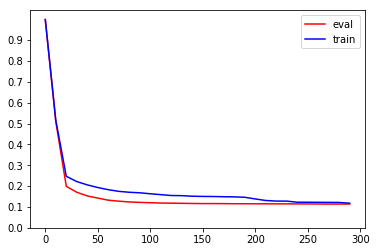

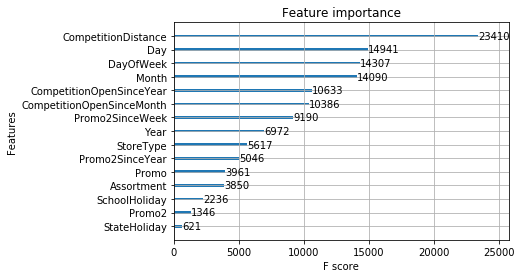

In [74]:
#从最终的训练importnace中看果然是时间序列影响比较大
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()
xgb.plot_importance(gbm2)

In [75]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm2.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [76]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)